# Import packages

In [1]:
# General
import pandas as pd
import numpy as np
import re

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_recall_curve, auc


# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Optimization
from sklearn.model_selection import GridSearchCV

# Metrics and calibration
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve

# Import the libraries for Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#Import google files to load the data on googlecolab
#from google.colab import files


#Import optuna to hyperpareters
import optuna

# Suppress all future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Import Data and inspect

In [2]:
# upload labels.csv to google drive
# data_file = files.upload()

In [3]:
raw = pd.read_csv('healthcare-dataset-stroke-data.csv')
raw.shape

(5110, 12)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
raw.set_index('id',inplace=True)
raw.head(2)

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1

# Preprocessing

In [6]:
# Make a copy of the raw data
df = raw.copy()

# Discretize age into groups found in research corresponding with strokes
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3475622/
df['age'] = pd.cut(df['age'],
                   bins=[0, 19, 44, 54, 64, 74, 84],
                   labels=['0-19', '20-44', '45-54', '55-64', '65-74', '75-84'])

# KNN Imputation
imputer = KNNImputer(n_neighbors=2)
df['bmi'] = imputer.fit_transform(df[['bmi']])

# Discretize bmi and avg_glucose_level into groups found in research corresponding with strokes
df['bmi'] = pd.cut(df['bmi'],
                   bins=[0, 18.5, 24.9, 29.9, 100],
                   labels=['underweight', 'normal', 'overweight', 'obese'])

df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'],
                   bins=[0, 99, 125, 200, 500],
                   labels=['normal', 'pre-diabetic', 'diabetic', 'very diabetic'])

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=df.columns[:-1], drop_first=False)

# Resulting dataframe
df_encoded = df_encoded.astype(int)
df_encoded.head()

stroke  gender_Female  gender_Male  gender_Other  age_0-19  age_20-44  \
id                                                                             
9046        1              0            1             0         0          0   
51676       1              1            0             0         0          0   
31112       1              0            1             0         0          0   
60182       1              1            0             0         0          0   
1665        1              1            0             0         0          0   

       age_45-54  age_55-64  age_65-74  age_75-84  ...  \
id                                                 ...   
9046           0          0          1          0  ...   
51676          0          1          0          0  ...   
31112          0          0          0          1  ...   
60182          1          0          0          0  ...   
1665           0          0          0          1  ...   

       avg_glucose_level_diabetic  avg_glucose_level_very diabetic  \
id                                                                   
9046                            0                                1   
51676                           0                                1   
31112                           0                                0   
60182                           1                                0   
1665                            1                                0   

       bmi_underweight  bmi_normal  bmi_overweight  bmi_obese  \
id                                                              
9046                 0           0               0          1   
51676                0           0               1          0   
31112                0           0               0          1   
60182                0           0               0          1   
1665                 0           1               0          0   

       smoking_status_Unknown  smoking_status_formerly smoked  \
id                                                              
9046                        0                               1   
51676                       0                               0   
31112                       0                               0   
60182                       0                               0   
1665                        0                               0   

       smoking_status_never smoked  smoking_status_smokes  
id                                                         
9046                             0                      0  
51676                            1                      0  
31112                            1                      0  
60182                            0                      1  
1665                             1                      0  

[5 rows x 35 columns]

# Correlation Check

In [7]:
# Remove stroke from rows
styled_df = df_encoded.corr().iloc[1:,:].copy()

# Eliminate the diagonal
styled_df.replace(1,0,inplace=True)
styled_df

# Sort columns by sum of correlations
sort_columns =list(styled_df.sum().sort_values(ascending=False).T.index)
sort_columns

# Style and round the dataframe
display = styled_df[sort_columns].sort_values('stroke',ascending=False).style.background_gradient(cmap='coolwarm').format("{:.2f}")\
                    .set_properties(**{'text-align': 'center', 'border-color': 'black', 'border-style': 'solid', 'border-width': '1px'}) \
                    .set_table_styles([{'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', 'black')]}]) \
                    .set_caption("Correlation Matrix by 'Stroke'")
display

# Oversample the minority class and undersample the majority class

In [8]:
# Correct sampling
X = df_encoded.drop('stroke', axis=1)
y = df_encoded.stroke

# Train and Tune Model

In [9]:
# Assuming 'X' and 'y' are your features and labels respectively
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=101, test_size=0.1, stratify=y_temp)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('Original dataset shape', len(df_encoded))
print('Resampled dataset shape', len(y_res))
print('Validation dataset shape', y_val.value_counts())
print('Stroke count in resampled dataset', y_res.value_counts())

clf = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# Custom scorer
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score, zero_division=0)
precision_scorer = make_scorer(precision_score, zero_division=0, average='binary')
f1_scorer = make_scorer(f1_score, zero_division=0, average='binary')
auc_scorer = make_scorer(roc_auc_score)

# Now put them in a dictionary
scorers = {
    'Accuracy': accuracy_scorer,
    'Recall': recall_scorer,
    'Precision': precision_scorer,
    'F1': f1_scorer,
    'AUC': 'roc_auc'
}

# Set up GridSearchCV with the scoring dictionary
grid = GridSearchCV(clf, param_grid, scoring=scorers, refit='F1', return_train_score=True, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid.fit(X_res, y_res)

# Get best estimator found by grid search and print predictions on the training set
best_estimator = grid.best_estimator_
y_res_pred = best_estimator.predict(X_res)

# Classification report for the training set
train_report = classification_report(y_res, y_res_pred)

# After finding the best hyperparameters, evaluate on the validation set
y_val_pred = grid.predict(X_val)
val_report = classification_report(y_val, y_val_pred)

# Predictions on the validation set
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
train_confusion_matrix = confusion_matrix(y_res, y_res_pred)
val_confusion_df = pd.DataFrame(val_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])
train_confusion_df = pd.DataFrame(train_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])

Original dataset shape 5110
Resampled dataset shape 7778
Validation dataset shape stroke
0    874
1     45
Name: count, dtype: int64
Stroke count in resampled dataset stroke
0    3889
1    3889
Name: count, dtype: int64


# Performance results

## Metrics

In [10]:
# Get the results
print(f"Best Parameters:\n{grid.best_params_}\n")
print(f"Best Estimator:\n{grid.best_estimator_}\n")
print(f"Best AUC: {grid.best_score_:.2f}\n")
print("Train Confusion Matrix:")
print(train_confusion_df)
print("\nValidation Confusion Matrix:")
print(val_confusion_df)

Best Parameters:
{'C': 100}

Best Estimator:
LogisticRegression(C=100, max_iter=1000)

Best AUC: 0.96

Train Confusion Matrix:
               Predicted_Negative  Predicted_Positive
True_Negative                3883                   6
True_Positive                 248                3641

Validation Confusion Matrix:
               Predicted_Negative  Predicted_Positive
True_Negative                 871                   3
True_Positive                  42                   3


In [11]:
# Classification reports
print("Training Classification Report:\n", train_report)
print("Validation Classification Report:\n", val_report)

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3889
           1       1.00      0.94      0.97      3889

    accuracy                           0.97      7778
   macro avg       0.97      0.97      0.97      7778
weighted avg       0.97      0.97      0.97      7778

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       874
           1       0.50      0.07      0.12        45

    accuracy                           0.95       919
   macro avg       0.73      0.53      0.55       919
weighted avg       0.93      0.95      0.93       919



## Visualizations

In [12]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))


Length of X_train: 4088
Length of y_train: 4088


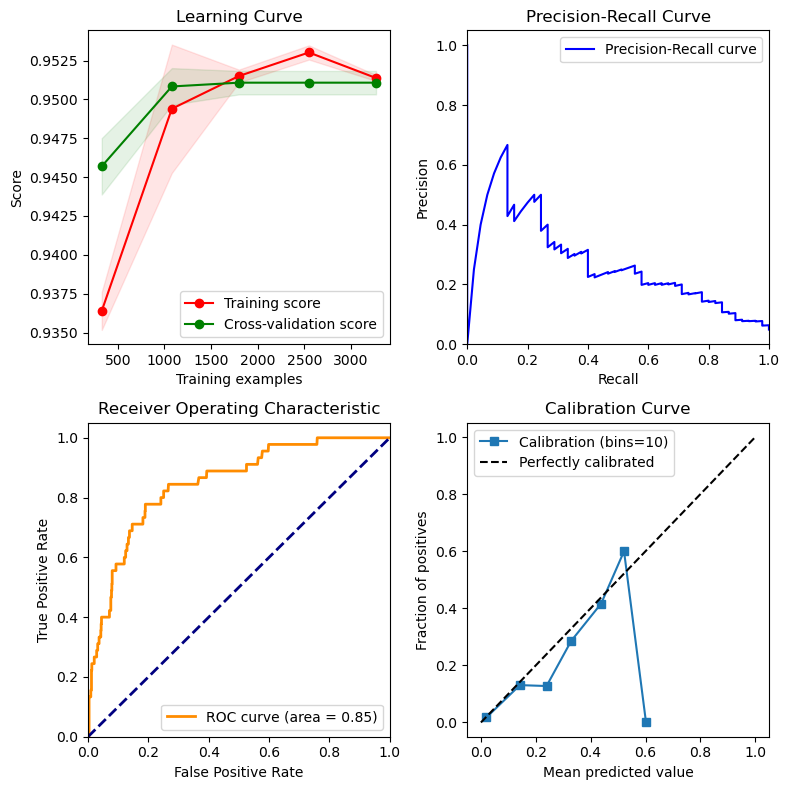

In [13]:
# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_estimator,
    X = X_train,
    y = y_train,
    train_sizes = [0.1, 0.33, 0.55, 0.78, 1. ],
    cv = 5,
    scoring = 'accuracy'
)

# Calculating mean and standard deviation for train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# For the ROC and precision-recall curves, you need probability scores
y_train_scores = grid.predict_proba(X_train)[:, 1]  # Probabilities for the positive class on the training set
y_val_scores = grid.predict_proba(X_val)[:, 1]      # Probabilities for the positive class on the validation set

# ROC Curve for Validation Set
fpr, tpr, _ = roc_curve(y_val, y_val_scores)
roc_auc = roc_auc_score(y_val, y_val_scores)

# Precision-Recall Curve for Validation Set
precision, recall, _ = precision_recall_curve(y_val, y_val_scores)

# Calibration Curve for Validation Set
prob_true, prob_pred = calibration_curve(y_val, y_val_scores, n_bins=10)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Learning Curve
axes[0, 0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
axes[0, 0].fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                        validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
axes[0, 0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0, 0].plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0, 0].set_title("Learning Curve")
axes[0, 0].set_xlabel("Training examples")
axes[0, 0].set_ylabel("Score")
axes[0, 0].legend(loc="best")

# Update the precision-recall curve plot to a continuous line graph
axes[0, 1].clear()  # Clearing the previous step plot
axes[0, 1].plot(recall, precision, color='b', label='Precision-Recall curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="best")

# ROC Curve
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Receiver Operating Characteristic')
axes[1, 0].legend(loc="lower right")

# Calibration Curve
axes[1, 1].plot(prob_pred, prob_true, 's-', label='Calibration (bins=10)')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
axes[1, 1].set_ylabel('Fraction of positives')
axes[1, 1].set_xlabel('Mean predicted value')
axes[1, 1].set_title('Calibration Curve')
axes[1, 1].legend(loc="best")

plt.tight_layout()
plt.show()


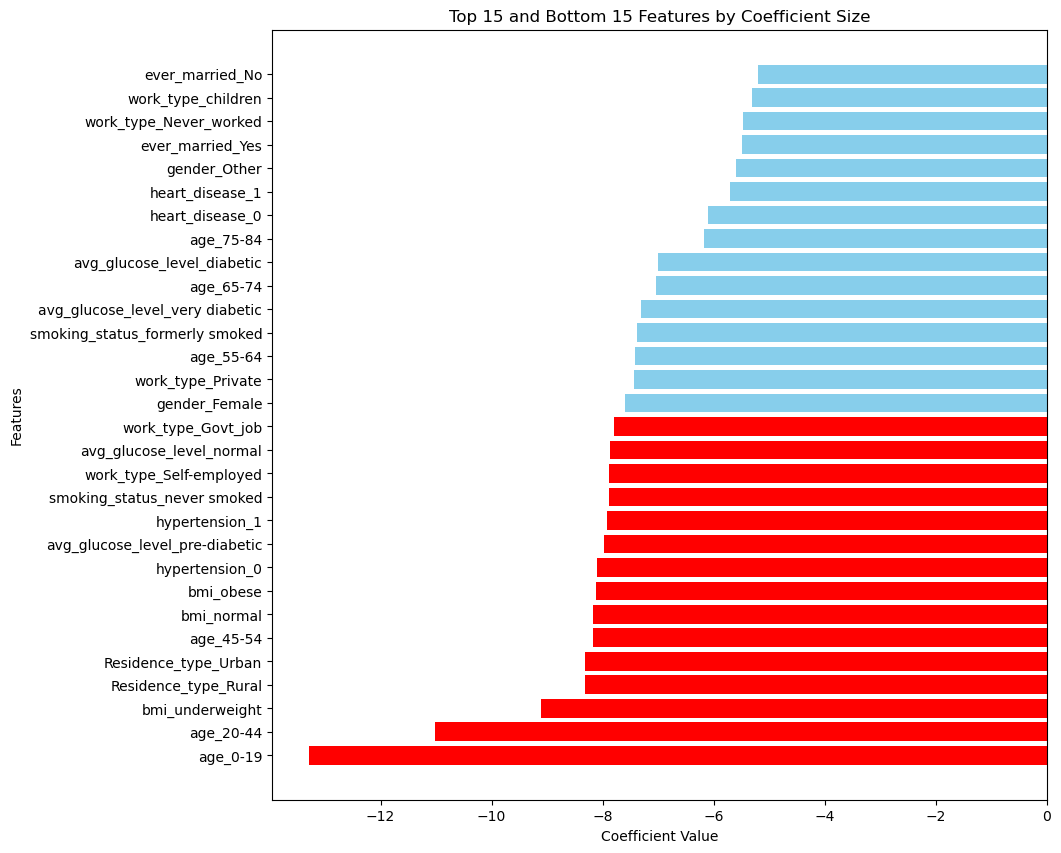

In [14]:
# Extracting coefficients
coefficients = best_estimator.coef_[0]

# Assuming 'X_train' columns are the feature names
feature_names = X_train.columns

# Creating a DataFrame for features and coefficients
coef_df = pd.DataFrame({'feat': feature_names, 'coef': coefficients})

# Sorting coefficients
coef_df.sort_values('coef', ascending=True, inplace=True)

# Selecting top 10 and bottom 10 features
num_to_show = 15
top = coef_df.head(num_to_show)
bottom = coef_df.tail(num_to_show)

# Concatenating for the plot
selected_features = pd.concat([top, bottom])

# Coloring top and bottom bars differently
plt.figure(figsize=(10, 10))
plt.barh(top['feat'], top['coef'], color='red')
plt.barh(bottom['feat'], bottom['coef'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Top {num_to_show} and Bottom {num_to_show} Features by Coefficient Size')
plt.show()


In [15]:
# coef_df.sort_values('coef',ascending=False).head()
coef_df.max()

feat    work_type_children
coef             -5.201223
dtype: object

In [16]:
train_confusion_df

Predicted_Negative  Predicted_Positive
True_Negative                3883                   6
True_Positive                 248                3641

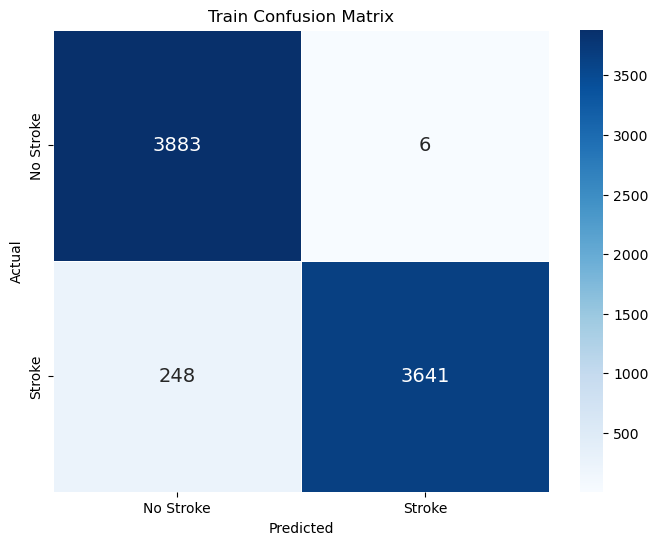

In [17]:
# Plotting training confusion matrix
train_confusion_df.rename(index   = {'True_Negative': 'No Stroke','True_Positive': 'Stroke'},
                          columns = {'Predicted_Negative': 'No Stroke','Predicted_Positive': 'Stroke'}, inplace=True)
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, annot_kws={"size": 14})
plt.title('Train Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

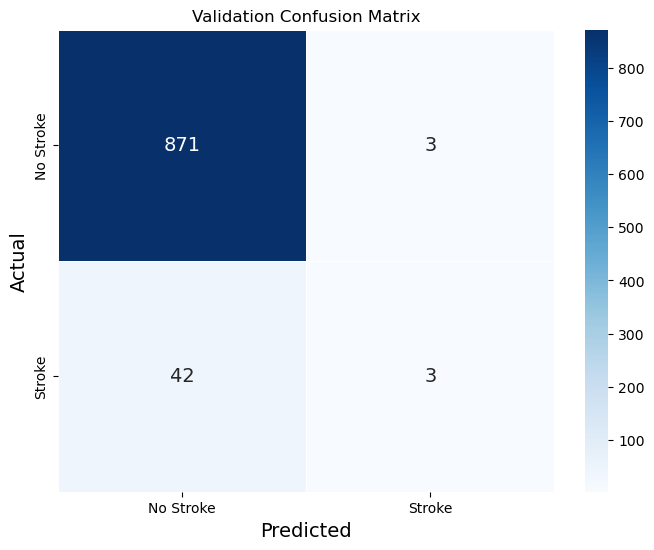

In [18]:
# Plotting validation confusion matrix
val_confusion_df.rename(index   = {'True_Negative': 'No Stroke','True_Positive': 'Stroke'},
                        columns = {'Predicted_Negative': 'No Stroke','Predicted_Positive': 'Stroke'}, inplace=True)
plt.figure(figsize=(8, 6))
sns.heatmap(val_confusion_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, annot_kws={"size": 14})
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()

## Deep Learning

In [19]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    #tf.random.set_seed(0)

    # Start with a Sequential model
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.layers.Input(shape=(34)))
    # Flatten
    model.add(tf.keras.layers.Flatten())
    # Add hidden layers
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation))

    # Add output layer
    # Note: Final layer activation is "sigmoid" for binary classification
    model.add(tf.keras.layers.Dense(units=n_classes,
                                    use_bias=True,
                                    activation='sigmoid',
                                    #kernel_initializer=initializers.RandomNormal(stddev=0.01),
                                    #bias_initializer=initializers.RandomNormal(stddev=0.01)
                                   ))

    # Add optimizer, if specified as 'Adam'
    if optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam()
    # Else optimizer = 'SGD'
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

2023-12-12 14:39:21.464858: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


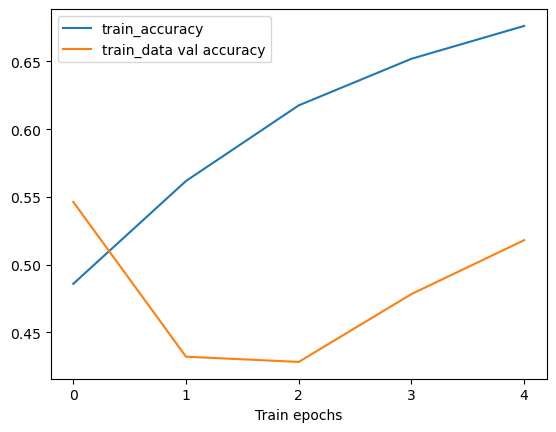

For hidden_layer_sizes=[], actv=tanh, opt=SGD, learning_rate=0.01, num_epochs=5
#PARAMETERS:  35
Accuracy from actual validation data :  0.8335146903991699

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


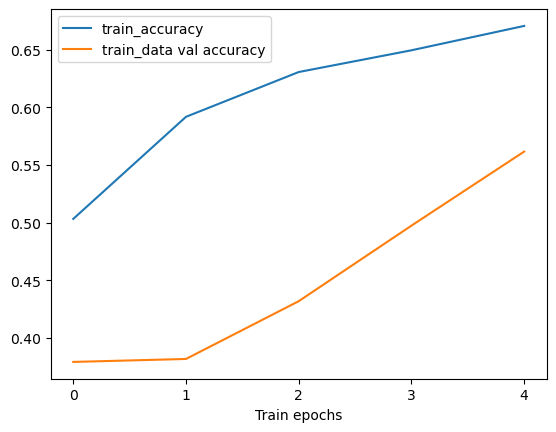

For hidden_layer_sizes=[8], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5
#PARAMETERS:  289
Accuracy from actual validation data :  0.7508161067962646

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


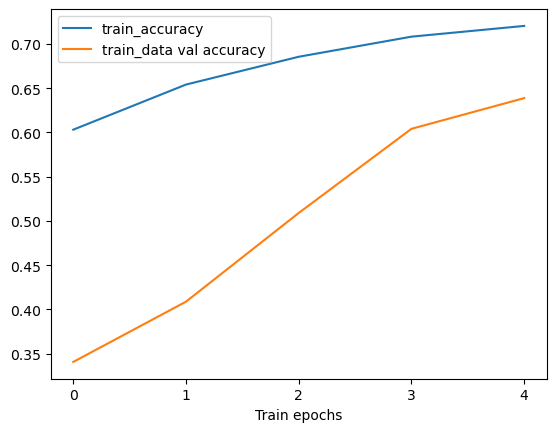

For hidden_layer_sizes=[16], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5
#PARAMETERS:  577
Accuracy from actual validation data :  0.835690975189209

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


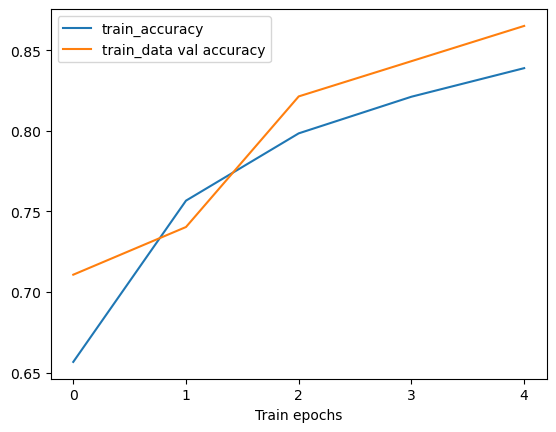

For hidden_layer_sizes=[16], actv=tanh, opt=Adam, learning_rate=0.01, num_epochs=5
#PARAMETERS:  577
Accuracy from actual validation data :  0.8498367667198181

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


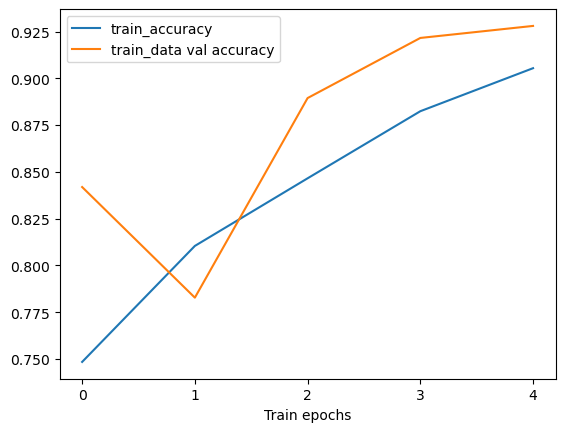

For hidden_layer_sizes=[64], actv=tanh, opt=SGD, learning_rate=0.1, num_epochs=5
#PARAMETERS:  2305
Accuracy from actual validation data :  0.9238302707672119



In [20]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    # convert the numpy array to DataFrame
    
    print(cm)
    cm_df = pd.DataFrame(cm,
                         index=['No Stroke', 'Stroke'],
                         columns=['No Stroke', 'Stroke'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', linewidths=.5, annot_kws={"size": 14})
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_model(n_classes=1,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset.
  X_DL_train = X_res
  X_DL_val = X_val
  Y_DL_train = y_res
  Y_DL_val = y_val

  print("X_DL_train.shape = ", X_DL_train.shape)
  print("X_DL_val.shape = ", X_DL_val.shape)
  print("Y_DL_train.shape = ", Y_DL_train.shape)
  print("Y_DL_val.shape = ", Y_DL_val.shape)

  # Train the model.
  print('Training model ...')
  history = model.fit(
    x=X_DL_train,
    y=Y_DL_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  train_val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(train_val_accuracy, label='train_data val accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  #Now evaluate on **actual** validation data
  actual_val_accuracy = model.evaluate(x=X_DL_val, y=Y_DL_val, verbose=0,
                                 return_dict=True)['accuracy']

  # NOTE: Modified this function to compute the paramter count
  total_params = model.count_params()
    
#   train_predictions = model.predict(X_DL_train)
#   # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
#   train_predicted_labels = (train_predictions > 0.5).astype(int)

#    # Calculate confusion matrix
#   cm = confusion_matrix(Y_DL_train, train_predicted_labels)
#   tn, fp, fn, tp = cm.ravel()
#   # Plot the confusion matrix
#   plot_confusion_matrix(cm, title='Train Confusion Matrix')
    
#   train_f1_score = f1_score(Y_DL_train, train_predicted_labels, average='macro')
#   train_precision = precision_score(Y_DL_train, train_predicted_labels, average='macro')
#   train_recall = recall_score(Y_DL_train, train_predicted_labels, average='macro')
#   train_accuracy = accuracy_score(Y_DL_train, train_predicted_labels)
    
#   print()
#   print()
#   print("Train data F1_SCORE = ", train_f1_score)
#   print("Train data PRECISION = ", train_precision)
#   print("Train data RECALL = ", train_recall)
#   print("Train data ACCURACY = ", train_accuracy)
#   print()
#   print()

#   val_predictions = model.predict(X_DL_val)
#   # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
#   val_predicted_labels = (val_predictions > 0.5).astype(int)

#   val_f1_score = f1_score(Y_DL_val, val_predicted_labels, average='macro')
#   val_precision = precision_score(Y_DL_val, val_predicted_labels, average='macro')
#   val_recall = recall_score(Y_DL_val, val_predicted_labels, average='macro')
#   val_accuracy = accuracy_score(Y_DL_val, val_predicted_labels)
    
#   print()
#   print()
#   print("Val data F1_SCORE = ", val_f1_score)
#   print("Val data PRECISION = ", val_precision)
#   print("Val data RECALL = ", val_recall)
#   print("Val data ACCURACY = ", val_accuracy)
#   print()
#   print()
    
#   test_predictions = model.predict(X_test)
#   # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
#   test_predicted_labels = (test_predictions > 0.5).astype(int)

#   test_f1_score = f1_score(y_test, test_predicted_labels, average='macro')
#   test_precision = precision_score(y_test, test_predicted_labels, average='macro')
#   test_recall = recall_score(y_test, test_predicted_labels, average='macro')
#   test_accuracy = accuracy_score(y_test, test_predicted_labels)

#   print()
#   print()
#   print("Test data F1_SCORE = ", test_f1_score)
#   print("Test data PRECISION = ", test_precision)
#   print("Test data RECALL = ", test_recall)
#   print("Test data ACCURACY = ", test_accuracy)
#   print()

  # NOTE: Modified this function to also return total_params
  return actual_val_accuracy, total_params


# Experiments Results

val_accuracy, total_params = train_and_evaluate([], 'tanh', 'SGD', 0.01, 5)
print('For hidden_layer_sizes=[], actv=tanh, opt=SGD, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([8], 'relu', 'SGD', 0.01, 5)
print('For hidden_layer_sizes=[8], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([16], 'tanh', 'SGD', 0.01, 5)
print('For hidden_layer_sizes=[16], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([16], 'tanh', 'Adam', 0.01, 5)
print('For hidden_layer_sizes=[16], actv=tanh, opt=Adam, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([64], 'tanh', 'SGD', 0.1, 5)
print('For hidden_layer_sizes=[64], actv=tanh, opt=SGD, learning_rate=0.1, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

# val_accuracy, total_params = train_and_evaluate([97], 'tanh', 'Adam', 0.025342599583490992, 5)
# print('For hidden_layer_sizes=[97], actv=tanh, opt=Adam, learning_rate=0.025342599583490992, num_epochs=5')
# print('#PARAMETERS: ', total_params)
# print('Accuracy from actual validation data : ', val_accuracy)
# print()
  


## Train and evaluate with parameter function and number of FP, FN, TP and TN

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


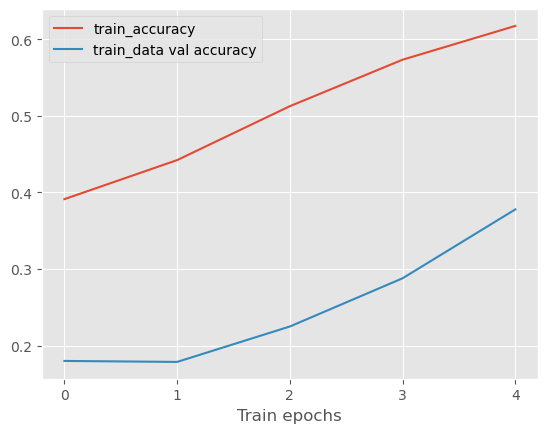

29/29 [==============================] - 0s 272us/step
[[774 100]
 [ 35  10]]


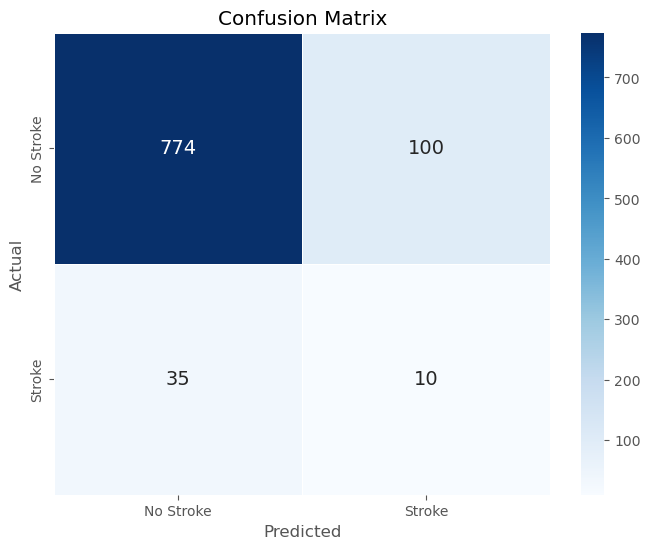

Experiment with Configuration: {'hidden_layer_sizes': [], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 35, 'validation_accuracy': 0.8531011939048767, 'validation_recall': 0.5539028731248411, 'validation_F1_score': 0.5244091771606003, 'validation_precision': 0.5238229014496011, 'validation_pr_auc': 0.0781080429400932, 'TP': 10, 'FP': 100, 'TN': 774, 'FN': 35, 'confusion_matrix': array([[774, 100],
       [ 35,  10]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


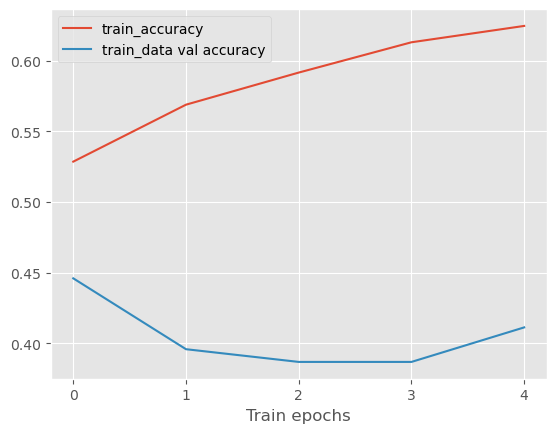

29/29 [==============================] - 0s 254us/step
[[744 130]
 [ 28  17]]


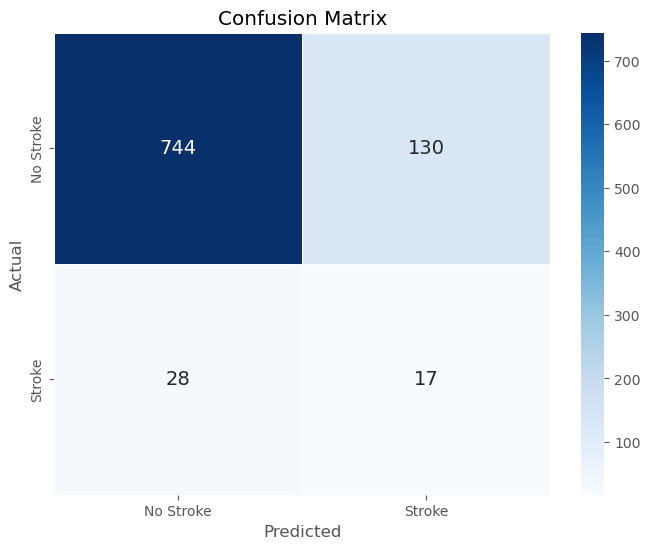

Experiment with Configuration: {'hidden_layer_sizes': [8], 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 289, 'validation_accuracy': 0.8280739784240723, 'validation_recall': 0.6145181795067378, 'validation_F1_score': 0.5405465269339813, 'validation_precision': 0.5396884142257939, 'validation_pr_auc': 0.10614630018567162, 'TP': 17, 'FP': 130, 'TN': 744, 'FN': 28, 'confusion_matrix': array([[744, 130],
       [ 28,  17]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


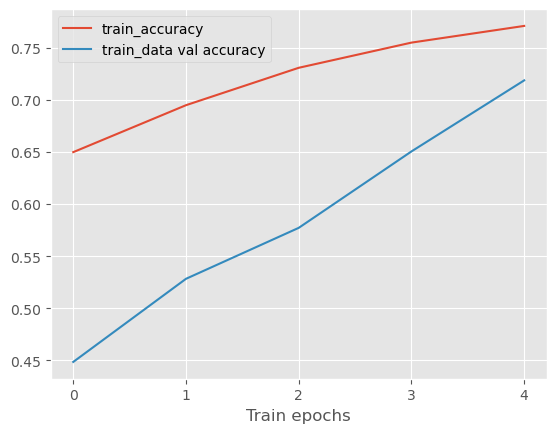

29/29 [==============================] - 0s 228us/step
[[766 108]
 [ 16  29]]


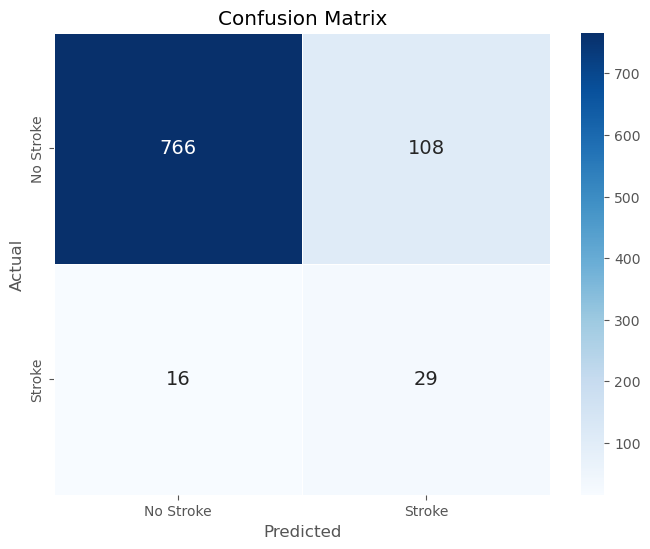

Experiment with Configuration: {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 577, 'validation_accuracy': 0.8650707006454468, 'validation_recall': 0.7604373251970507, 'validation_F1_score': 0.6219010458140892, 'validation_precision': 0.5956092370302611, 'validation_pr_auc': 0.2748574427931384, 'TP': 29, 'FP': 108, 'TN': 766, 'FN': 16, 'confusion_matrix': array([[766, 108],
       [ 16,  29]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


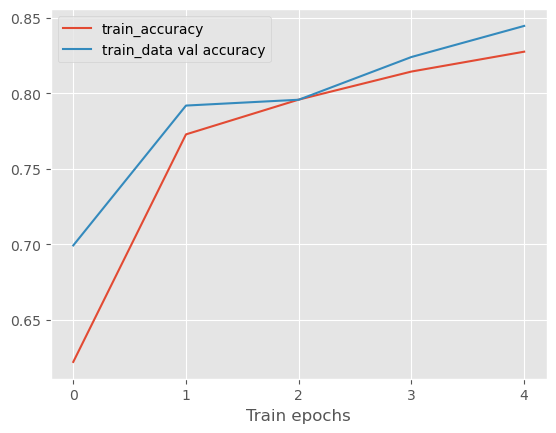

29/29 [==============================] - 0s 277us/step
[[754 120]
 [ 13  32]]


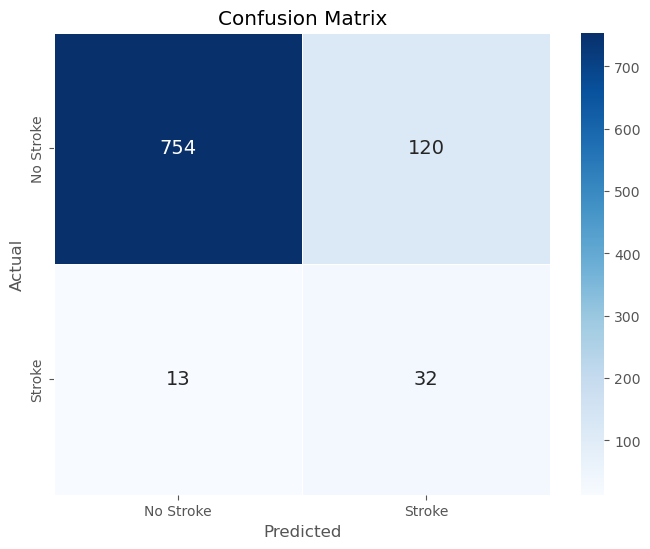

Experiment with Configuration: {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 577, 'validation_accuracy': 0.8552774786949158, 'validation_recall': 0.7869056699720316, 'validation_F1_score': 0.6219124775347458, 'validation_precision': 0.5967885816235504, 'validation_pr_auc': 0.2576815457659879, 'TP': 32, 'FP': 120, 'TN': 754, 'FN': 13, 'confusion_matrix': array([[754, 120],
       [ 13,  32]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


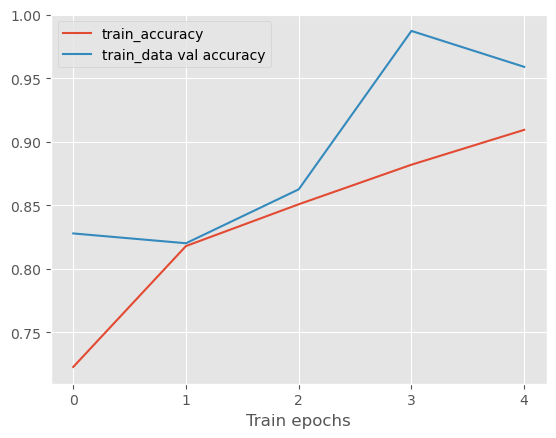

29/29 [==============================] - 0s 265us/step
[[821  53]
 [ 29  16]]


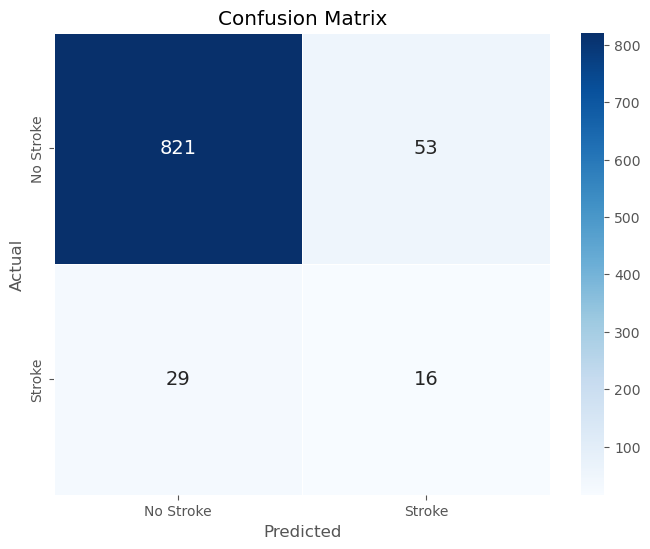

Experiment with Configuration: {'hidden_layer_sizes': [64], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5, 'total_parameters': 2305, 'validation_accuracy': 0.9107725620269775, 'validation_recall': 0.6474574116450547, 'validation_F1_score': 0.6165689746407783, 'validation_precision': 0.5988832054560955, 'validation_pr_auc': 0.24190375193630045, 'TP': 16, 'FP': 53, 'TN': 821, 'FN': 29, 'confusion_matrix': array([[821,  53],
       [ 29,  16]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


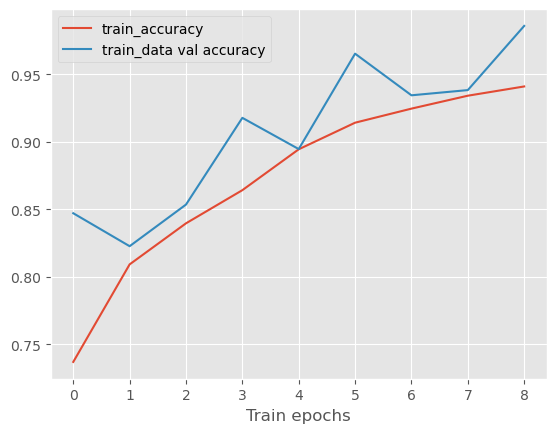

29/29 [==============================] - 0s 229us/step
[[831  43]
 [ 26  19]]


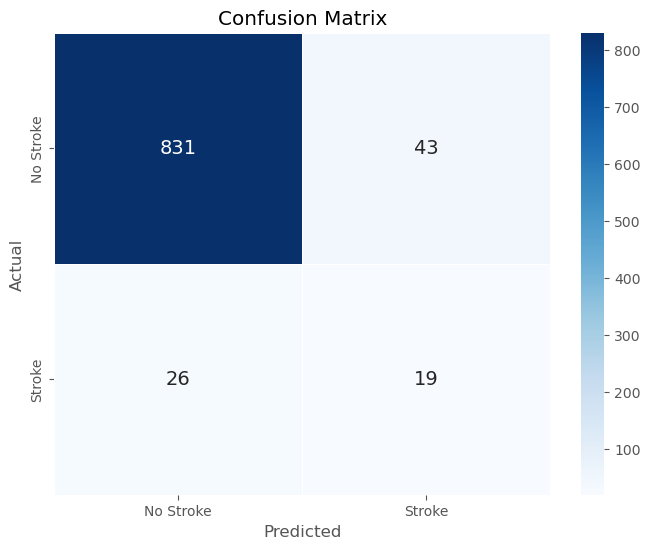

Experiment with Configuration: {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.08260765279918306, 'num_epochs': 9, 'total_parameters': 2917, 'validation_accuracy': 0.9249184131622314, 'validation_recall': 0.686511568777015, 'validation_F1_score': 0.6576394175480653, 'validation_precision': 0.638056611585802, 'validation_pr_auc': 0.24053917756033755, 'TP': 19, 'FP': 43, 'TN': 831, 'FN': 26, 'confusion_matrix': array([[831,  43],
       [ 26,  19]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


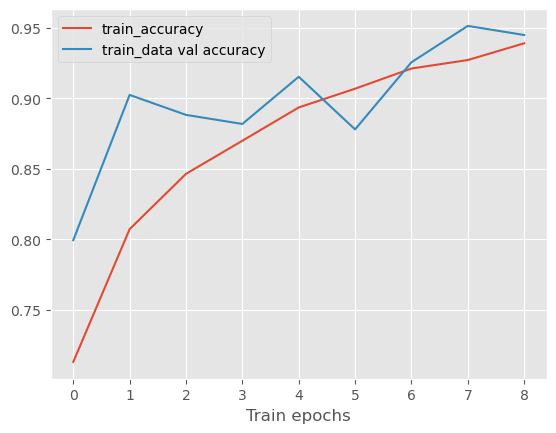

29/29 [==============================] - 0s 229us/step
[[863  11]
 [ 40   5]]


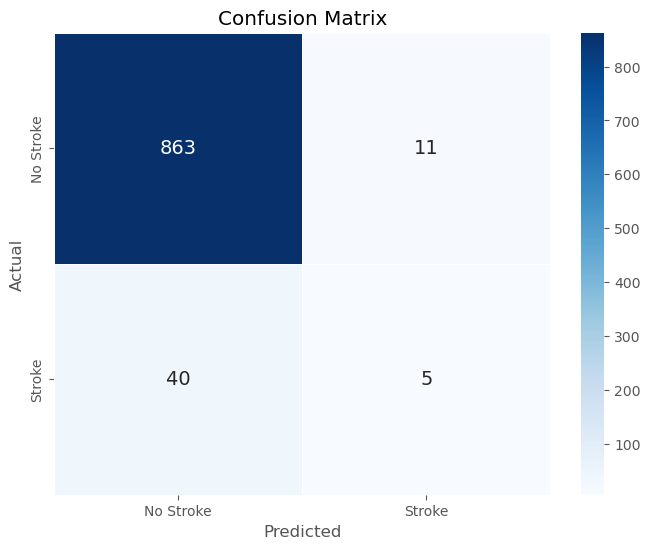

Experiment with Configuration: {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020248551640979554, 'num_epochs': 9, 'total_parameters': 2917, 'validation_accuracy': 0.9445049166679382, 'validation_recall': 0.5492626493770658, 'validation_F1_score': 0.567617184977444, 'validation_precision': 0.6341016057585824, 'validation_pr_auc': 0.24235764686496408, 'TP': 5, 'FP': 11, 'TN': 863, 'FN': 40, 'confusion_matrix': array([[863,  11],
       [ 40,   5]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


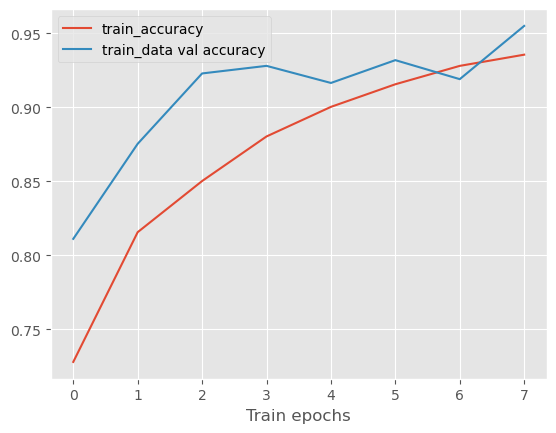

29/29 [==============================] - 0s 229us/step
[[841  33]
 [ 32  13]]


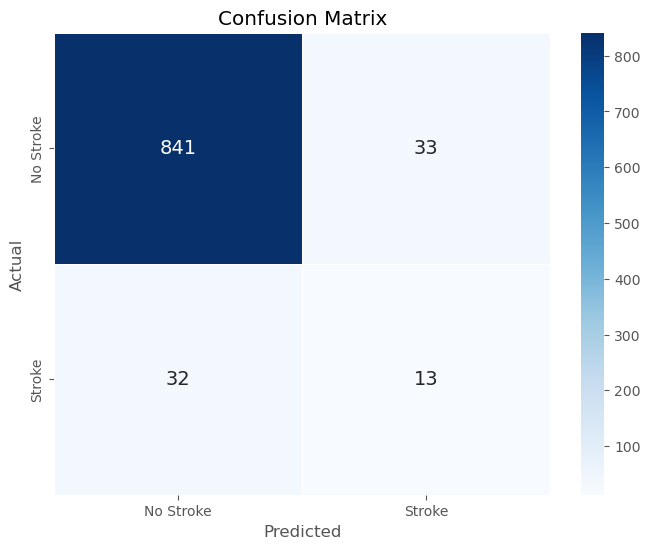

Experiment with Configuration: {'hidden_layer_sizes': [82], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.018556580032488137, 'num_epochs': 8, 'total_parameters': 2953, 'validation_accuracy': 0.9292709231376648, 'validation_recall': 0.6255657259089753, 'validation_F1_score': 0.6242538228800393, 'validation_precision': 0.622976741869615, 'validation_pr_auc': 0.23502405047302904, 'TP': 13, 'FP': 33, 'TN': 841, 'FN': 32, 'confusion_matrix': array([[841,  33],
       [ 32,  13]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


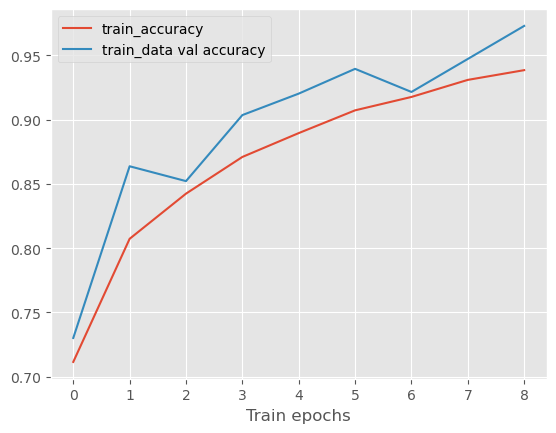

29/29 [==============================] - 0s 264us/step
[[819  55]
 [ 27  18]]


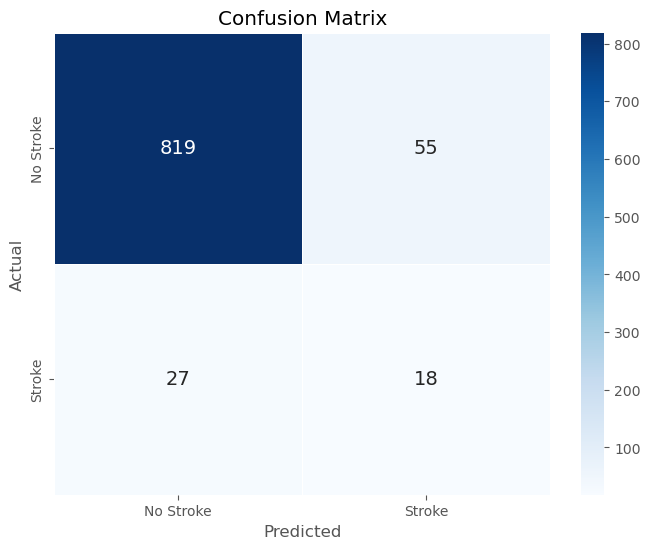

Experiment with Configuration: {'hidden_layer_sizes': [84], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.019154807186818695, 'num_epochs': 9, 'total_parameters': 3025, 'validation_accuracy': 0.9107725620269775, 'validation_recall': 0.6685354691075516, 'validation_F1_score': 0.6287051635790304, 'validation_precision': 0.6073302244243661, 'validation_pr_auc': 0.2199172124307101, 'TP': 18, 'FP': 55, 'TN': 819, 'FN': 27, 'confusion_matrix': array([[819,  55],
       [ 27,  18]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


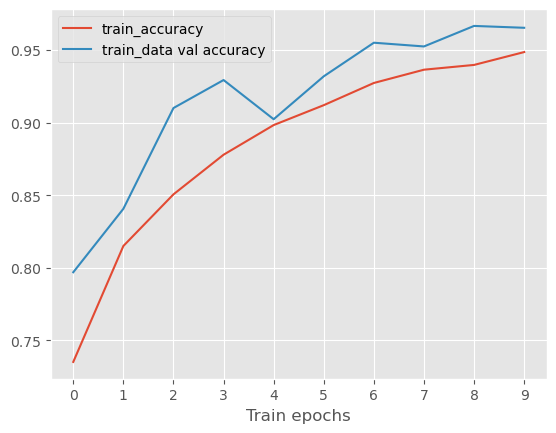

29/29 [==============================] - 0s 229us/step
[[863  11]
 [ 38   7]]


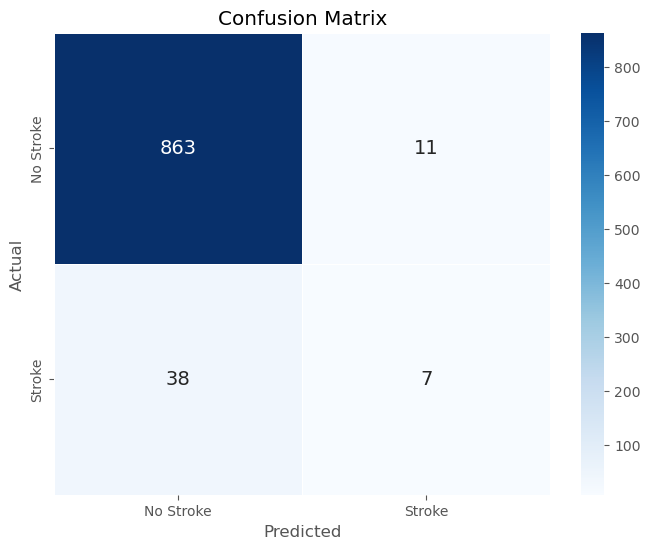

Experiment with Configuration: {'hidden_layer_sizes': [115], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013250663299162593, 'num_epochs': 10, 'total_parameters': 4141, 'validation_accuracy': 0.9466812014579773, 'validation_recall': 0.5714848715992881, 'validation_F1_score': 0.5973082942097027, 'validation_precision': 0.6733567640892835, 'validation_pr_auc': 0.2828824694559757, 'TP': 7, 'FP': 11, 'TN': 863, 'FN': 38, 'confusion_matrix': array([[863,  11],
       [ 38,   7]])}



In [47]:
# train and evaluate with parameter function and add FP,FN,TP and TN + confusion matrix to return function

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    # convert the numpy array to DataFrame
    
    print(cm)
    cm_df = pd.DataFrame(cm,
                         index=['No Stroke', 'Stroke'],
                         columns=['No Stroke', 'Stroke'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', linewidths=.5, annot_kws={"size": 14})
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# F1 score compute modification
def train_and_evaluate_for_optuna(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5):


  # Build the model
  model = build_model(n_classes=1,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset
  X_DL_train = X_res
  X_DL_val = X_val
  Y_DL_train = y_res
  Y_DL_val = y_val

  print("X_DL_train.shape = ", X_DL_train.shape)
  print("X_DL_val.shape = ", X_DL_val.shape)
  print("Y_DL_train.shape = ", Y_DL_train.shape)
  print("Y_DL_val.shape = ", Y_DL_val.shape)

  # Train the model
  print('Training model ...')
  history = model.fit(
    x=X_DL_train,
    y=Y_DL_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics after each train epoch
  train_accuracy = history.history['accuracy']
  train_val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(train_val_accuracy, label='train_data val accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()


  # Compute the parameter count
  total_params = model.count_params()

  # Evaluate on actual validation data
  actual_val_accuracy = model.evaluate(x=X_DL_val, y=Y_DL_val, verbose=0,return_dict=True)['accuracy']

  # Predictions for the actual validation set
  predictions = model.predict(X_DL_val)
  # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
  predicted_labels = (predictions > 0.5).astype(int)

  # Calculate confusion matrix
  cm = confusion_matrix(Y_DL_val, predicted_labels)
  tn, fp, fn, tp = cm.ravel()
  
  actual_val_precision = precision_score(Y_DL_val, predicted_labels , average='macro')
  # actual_val_recall = tp/(tp + fn)
  actual_val_recall = recall_score(Y_DL_val, predicted_labels , average='macro')
  # actual_val_f1_score = 2*(actual_val_precision*actual_val_recall)/(actual_val_precision+actual_val_recall)
  actual_val_f1_score = f1_score(Y_DL_val, predicted_labels , average='macro')
    
  # added on Dec 10, 2023
  X_preds_ravel = model.predict(X_DL_val).ravel()
  precision, recall, _ = precision_recall_curve(Y_DL_val, X_preds_ravel)
  actual_val_pr_auc = auc(recall, precision)

  # Plot the confusion matrix
  plot_confusion_matrix(cm, title='Confusion Matrix')

  # Return a summary dictionary instead of individual prints
  return {
      'hidden_layer_sizes': hidden_layer_sizes,
      'activation': activation,
      'optimizer': optimizer,
      'learning_rate': learning_rate,
      'num_epochs': num_epochs,
      'total_parameters': total_params,
      'validation_accuracy': actual_val_accuracy,
      'validation_recall': actual_val_recall,
      'validation_F1_score': actual_val_f1_score,
      'validation_precision': actual_val_precision,
      'validation_pr_auc': actual_val_pr_auc,
      'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
      'confusion_matrix': cm
  }

# List of experiments to run
experiments = [
    {'hidden_layer_sizes': [], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [8], 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [64], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5},
    
    {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.08260765279918306, 'num_epochs': 9},
    {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020248551640979554, 'num_epochs': 9},
    {'hidden_layer_sizes': [82], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.018556580032488137, 'num_epochs': 8},
    {'hidden_layer_sizes': [84], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.019154807186818695, 'num_epochs': 9},
    {'hidden_layer_sizes': [115], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013250663299162593, 'num_epochs': 10},
]

# Running all experiments and printing results
for exp in experiments:
    result = train_and_evaluate_for_optuna(**exp)
    print('Experiment with Configuration:', result)
    print()

## Visualizations

In [22]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))

Length of X_train: 4088
Length of y_train: 4088


[I 2023-12-10 19:23:46,581] A new study created in memory with name: no-name-0ee8c92d-2e13-4f69-a91c-20eb7161606d
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


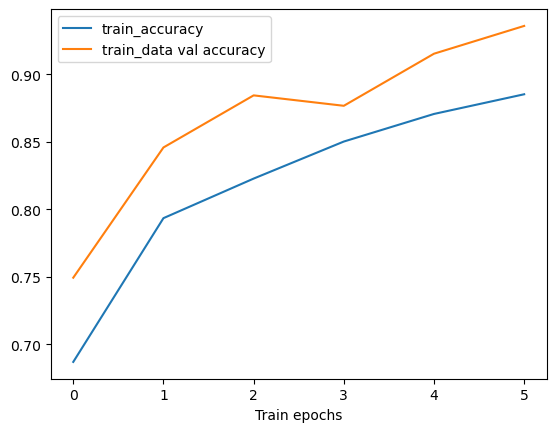

29/29 [==============================] - 0s 278us/step


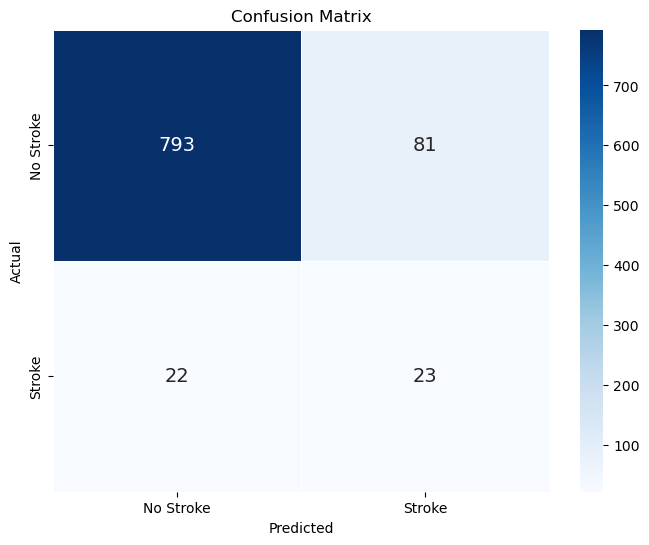

[I 2023-12-10 19:23:47,328] Trial 0 finished with value: 0.6238710010688983 and parameters: {'units_layer': 97, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.012253684878526756, 'num_epochs': 6}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


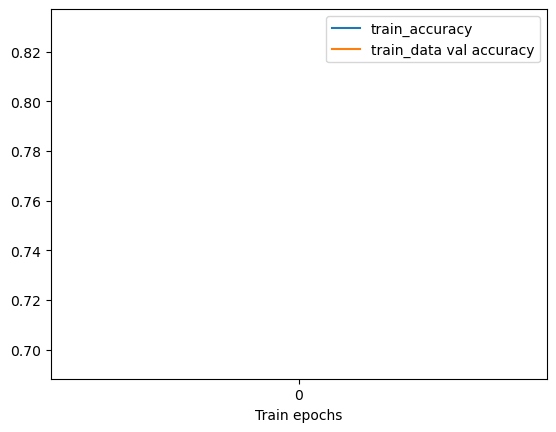

29/29 [==============================] - 0s 294us/step


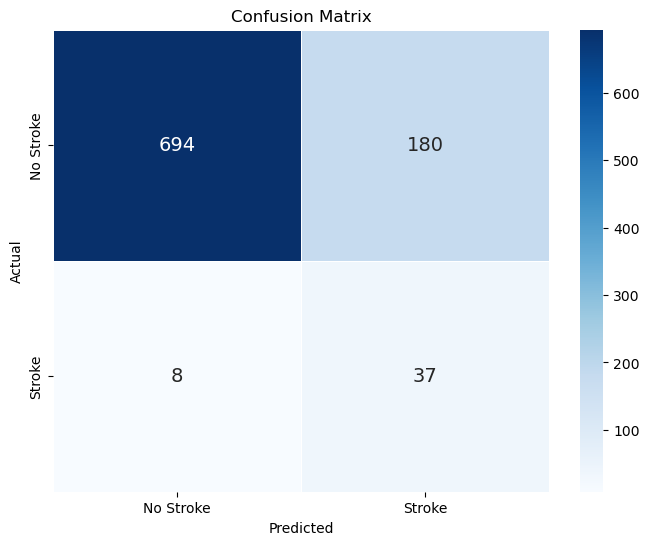

[I 2023-12-10 19:23:47,813] Trial 1 finished with value: 0.5815767039950401 and parameters: {'units_layer': 97, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.04016299964909098, 'num_epochs': 1}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


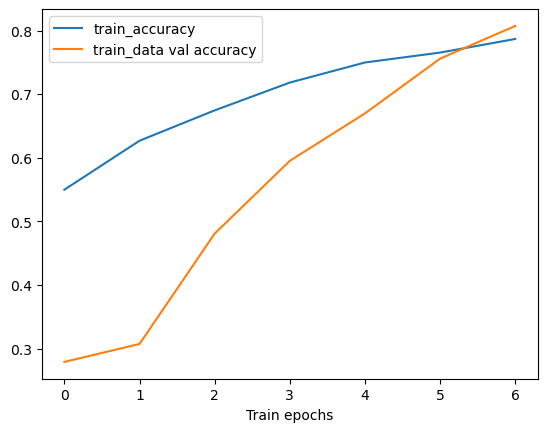

29/29 [==============================] - 0s 257us/step


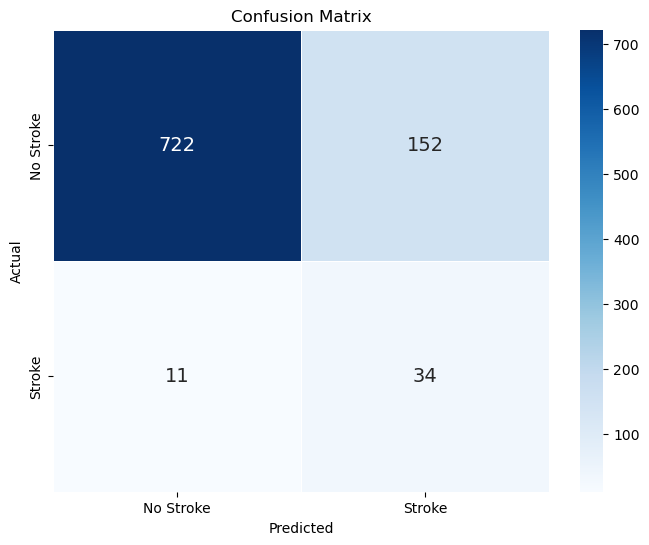

[I 2023-12-10 19:23:48,497] Trial 2 finished with value: 0.5964705280199991 and parameters: {'units_layer': 1, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.061147233992822174, 'num_epochs': 7}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


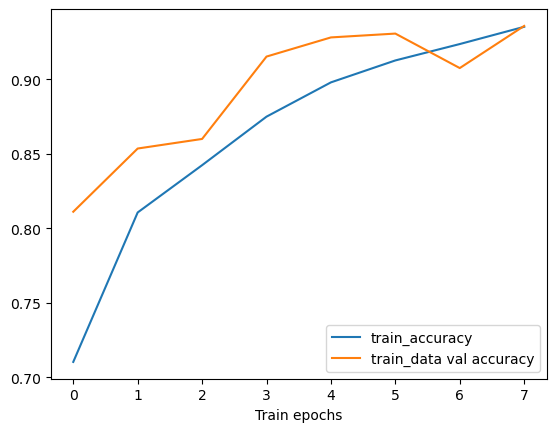

29/29 [==============================] - 0s 254us/step


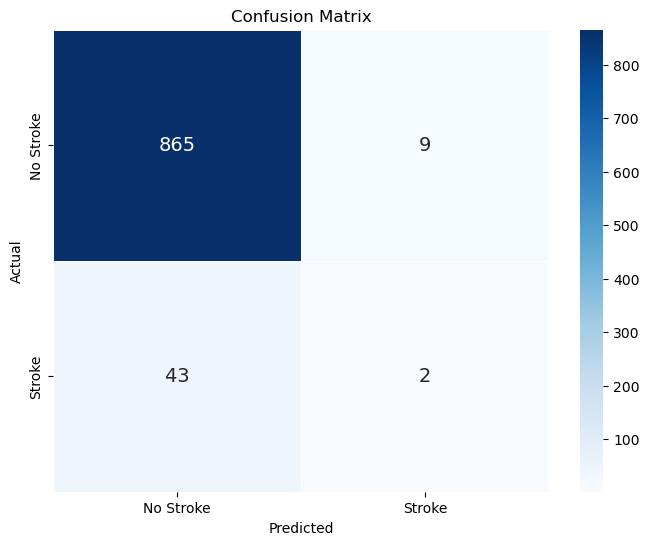

[I 2023-12-10 19:23:49,356] Trial 3 finished with value: 0.5211239377906045 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011702218780816237, 'num_epochs': 8}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


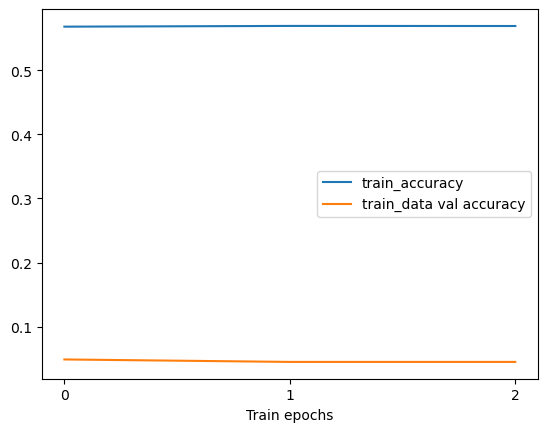

29/29 [==============================] - 0s 248us/step


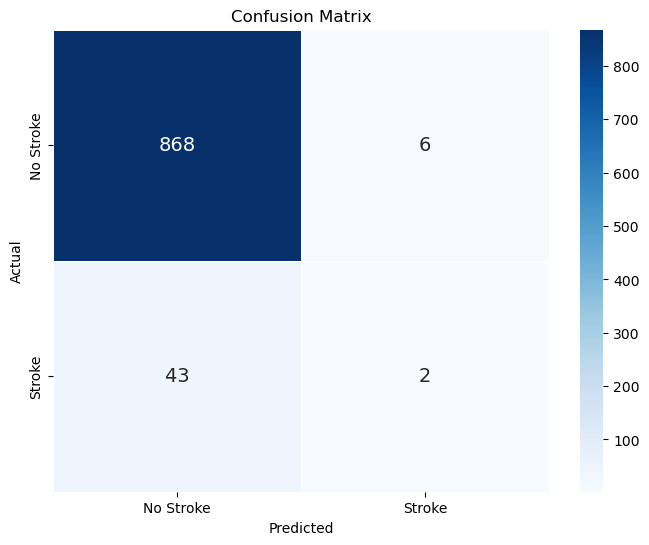

[I 2023-12-10 19:23:49,877] Trial 4 finished with value: 0.5240103588605254 and parameters: {'units_layer': 1, 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01103672614909289, 'num_epochs': 3}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


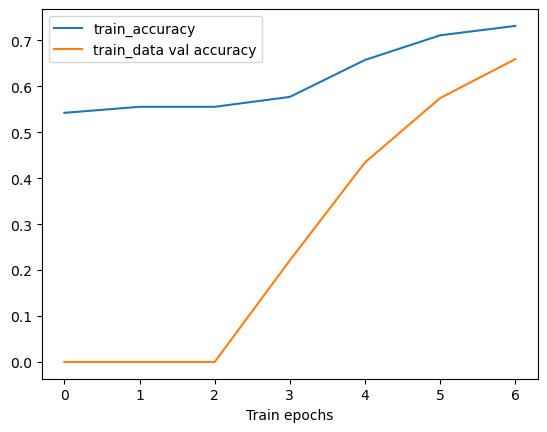

29/29 [==============================] - 0s 250us/step


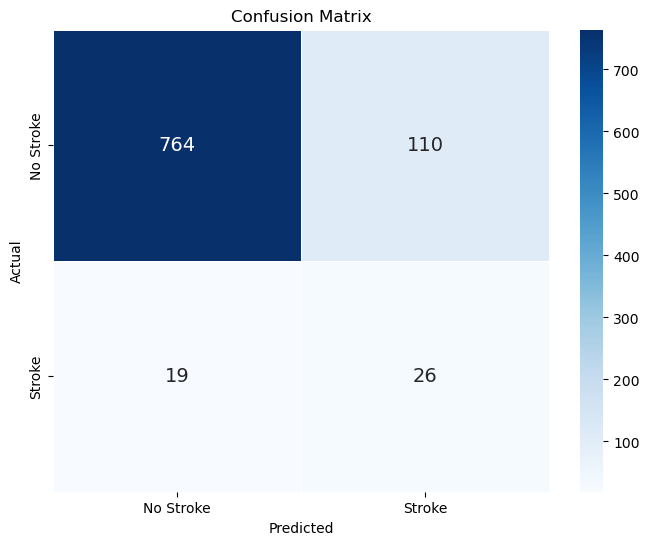

[I 2023-12-10 19:23:50,553] Trial 5 finished with value: 0.6047206393768942 and parameters: {'units_layer': 1, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.053597312273078436, 'num_epochs': 7}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


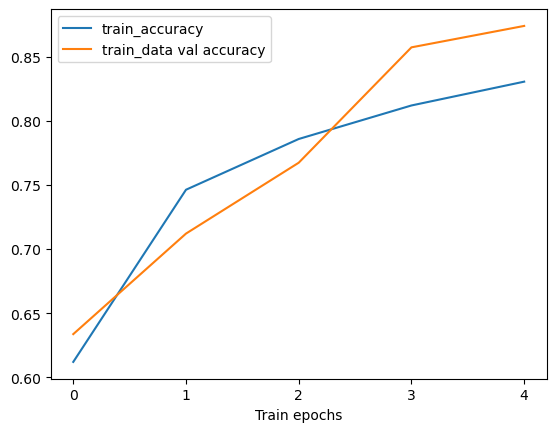

29/29 [==============================] - 0s 254us/step


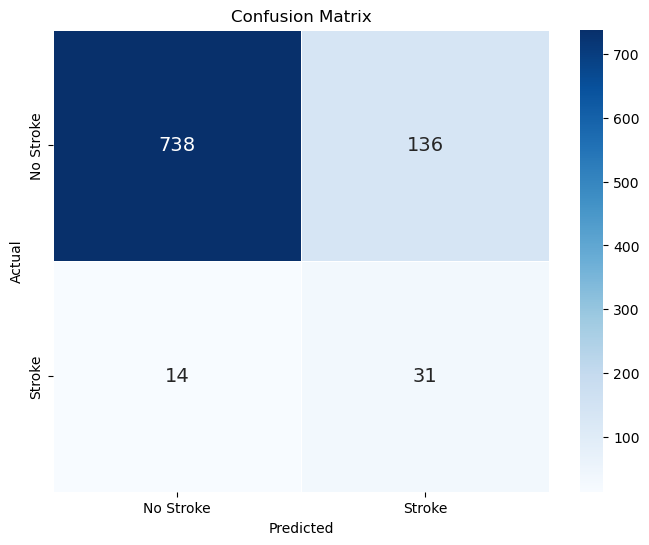

[I 2023-12-10 19:23:51,289] Trial 6 finished with value: 0.6001009538397271 and parameters: {'units_layer': 97, 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.03467168384124089, 'num_epochs': 5}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


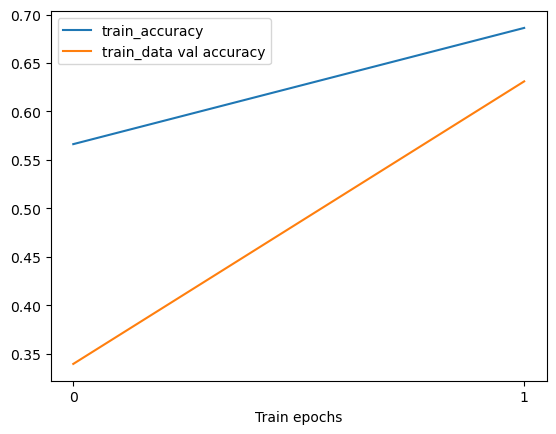

29/29 [==============================] - 0s 276us/step


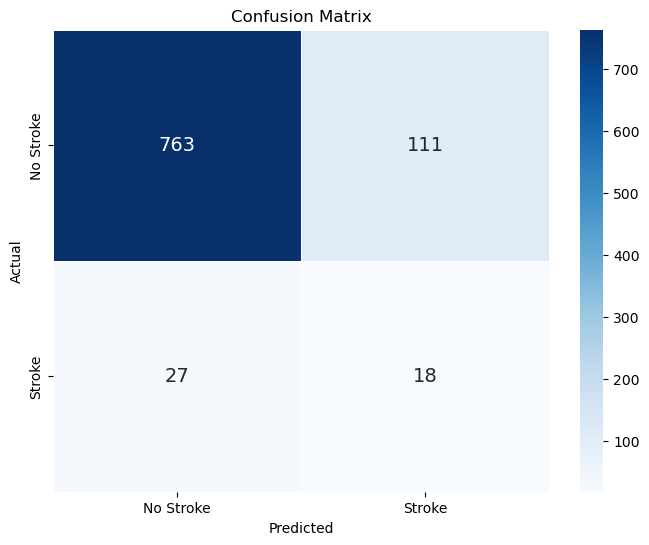

[I 2023-12-10 19:23:51,763] Trial 7 finished with value: 0.5619819297082228 and parameters: {'units_layer': 33, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.014099604863503134, 'num_epochs': 2}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


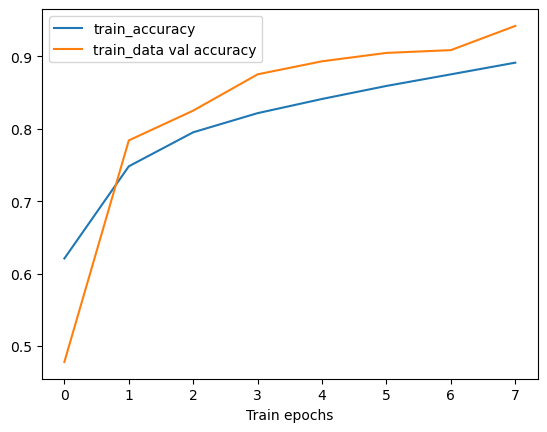

29/29 [==============================] - 0s 269us/step


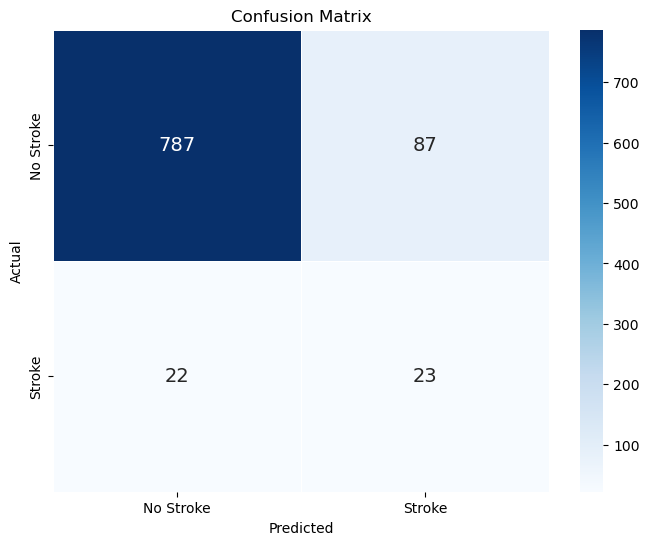

[I 2023-12-10 19:23:52,561] Trial 8 finished with value: 0.6160044467444847 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.06377749863142855, 'num_epochs': 8}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


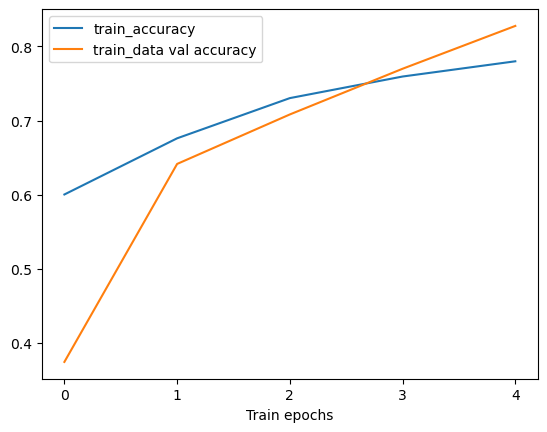

29/29 [==============================] - 0s 262us/step


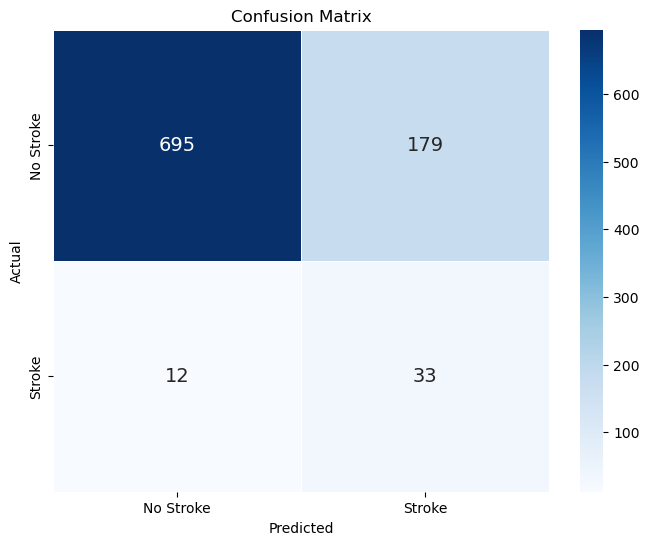

[I 2023-12-10 19:23:53,147] Trial 9 finished with value: 0.5679998621765765 and parameters: {'units_layer': 33, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.019218836554751748, 'num_epochs': 5}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


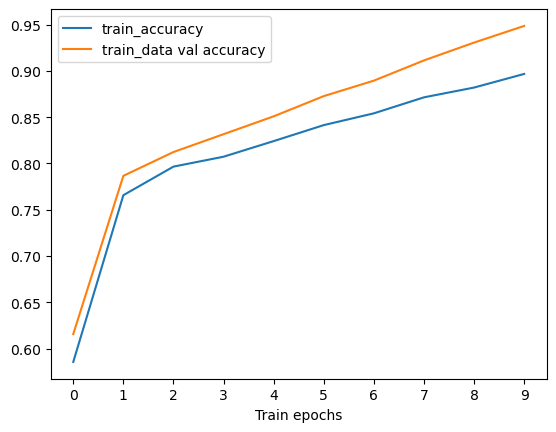

29/29 [==============================] - 0s 270us/step


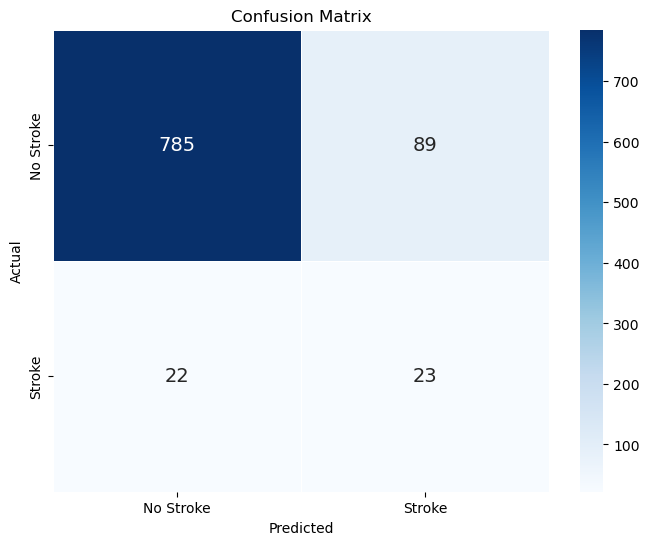

[I 2023-12-10 19:23:54,028] Trial 10 finished with value: 0.6134807534186885 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.09953063144065748, 'num_epochs': 10}. Best is trial 0 with value: 0.6238710010688983.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


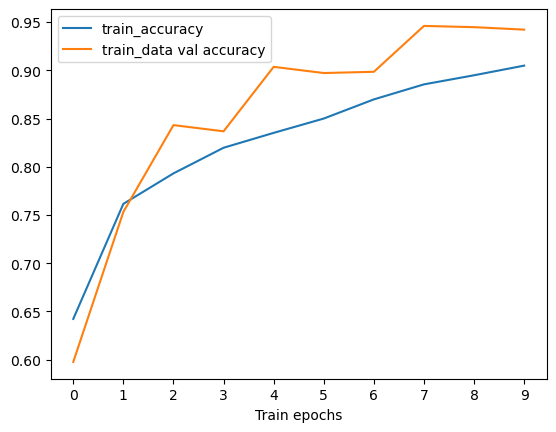

29/29 [==============================] - 0s 263us/step


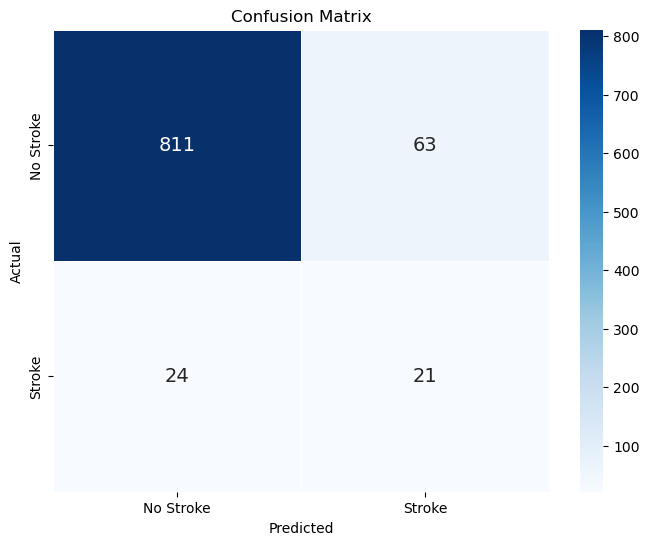

[I 2023-12-10 19:23:54,906] Trial 11 finished with value: 0.63733721610625 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.02318700018266427, 'num_epochs': 10}. Best is trial 11 with value: 0.63733721610625.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


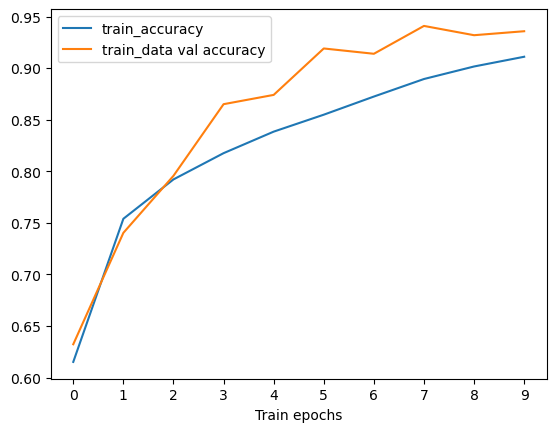

29/29 [==============================] - 0s 266us/step


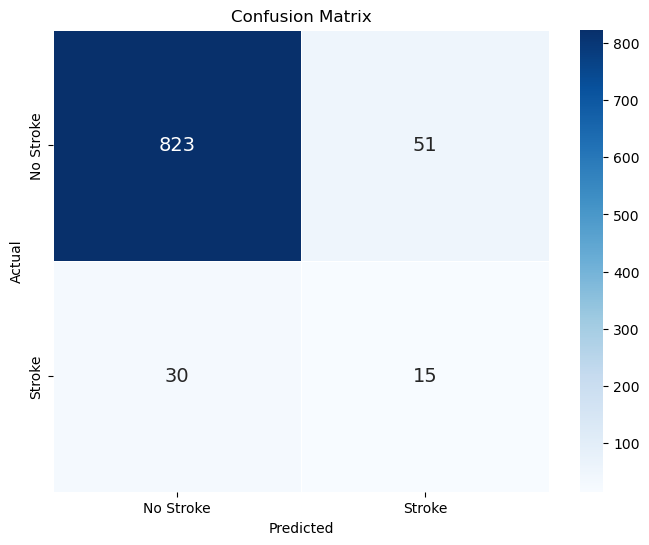

[I 2023-12-10 19:23:55,780] Trial 12 finished with value: 0.6116840639133632 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.021592758887742643, 'num_epochs': 10}. Best is trial 11 with value: 0.63733721610625.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


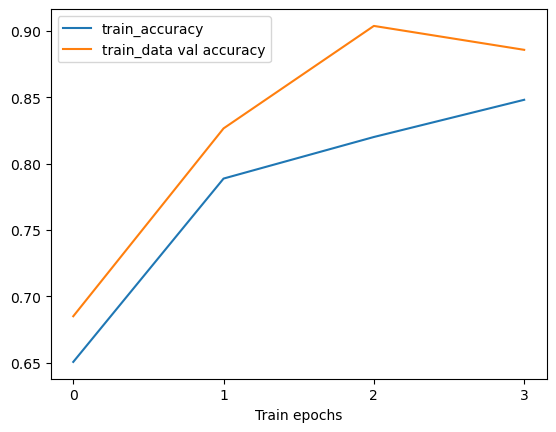

29/29 [==============================] - 0s 252us/step


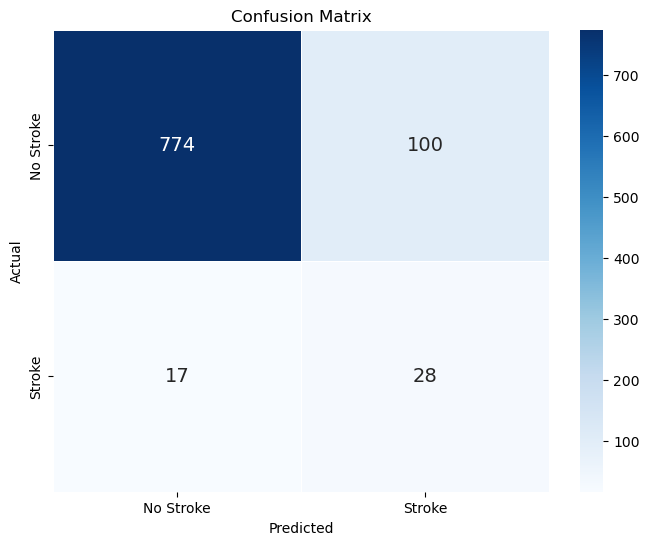

[I 2023-12-10 19:23:56,405] Trial 13 finished with value: 0.6267145758475239 and parameters: {'units_layer': 97, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.020811859458407828, 'num_epochs': 4}. Best is trial 11 with value: 0.63733721610625.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


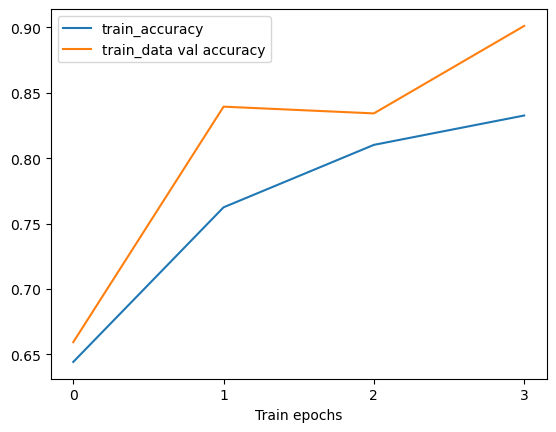

29/29 [==============================] - 0s 249us/step


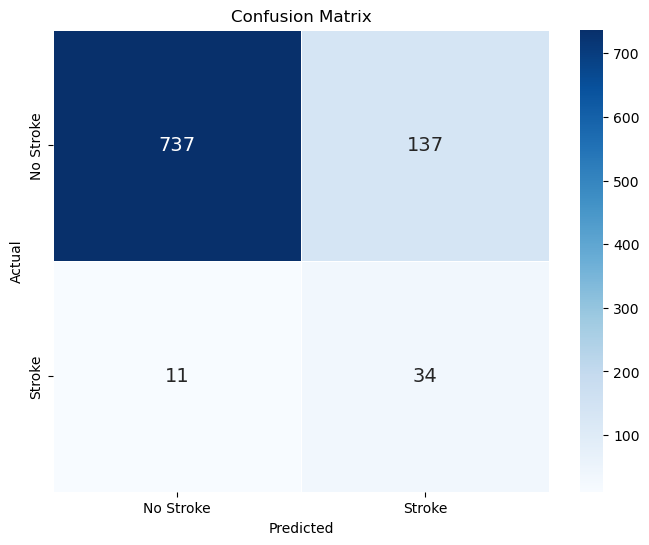

[I 2023-12-10 19:23:57,000] Trial 14 finished with value: 0.61178471936795 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.025964371554309886, 'num_epochs': 4}. Best is trial 11 with value: 0.63733721610625.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


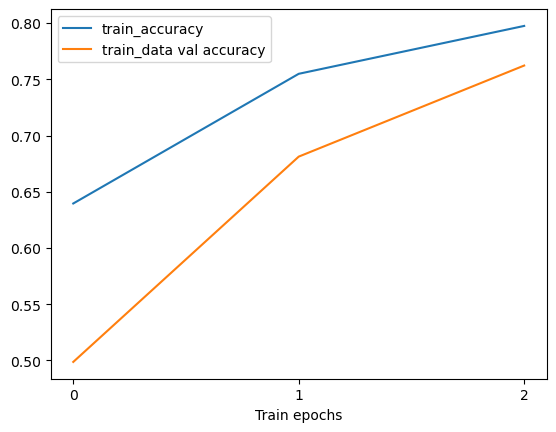

29/29 [==============================] - 0s 252us/step


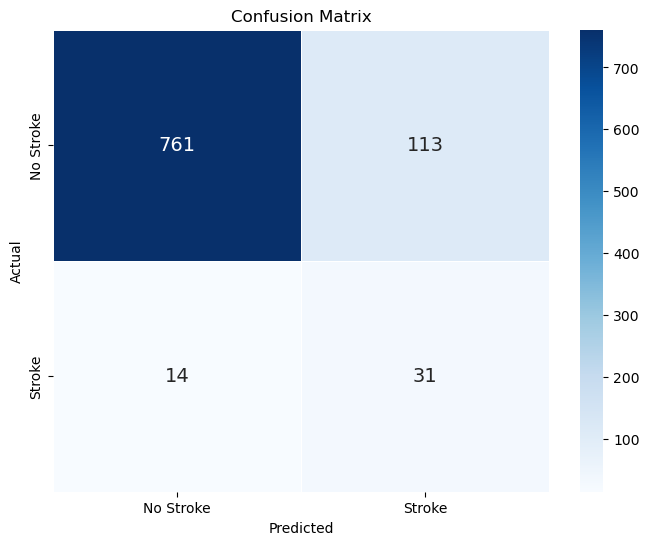

[I 2023-12-10 19:23:57,558] Trial 15 finished with value: 0.6255129772412975 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.015673472420702928, 'num_epochs': 3}. Best is trial 11 with value: 0.63733721610625.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


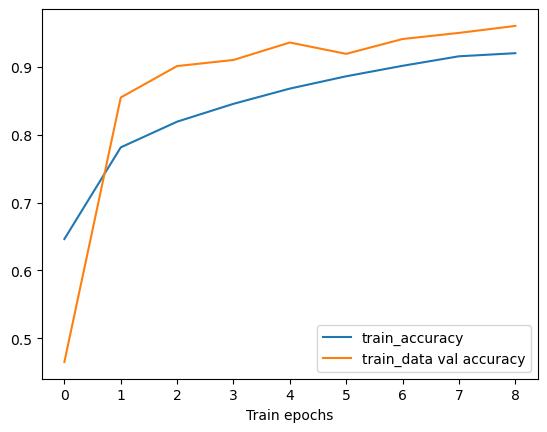

29/29 [==============================] - 0s 242us/step


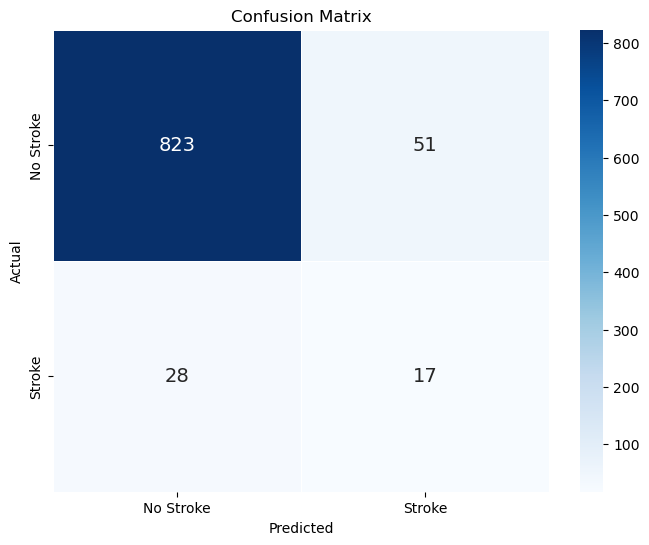

[I 2023-12-10 19:23:58,457] Trial 16 finished with value: 0.6275439271514685 and parameters: {'units_layer': 97, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.028403033667038207, 'num_epochs': 9}. Best is trial 11 with value: 0.63733721610625.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


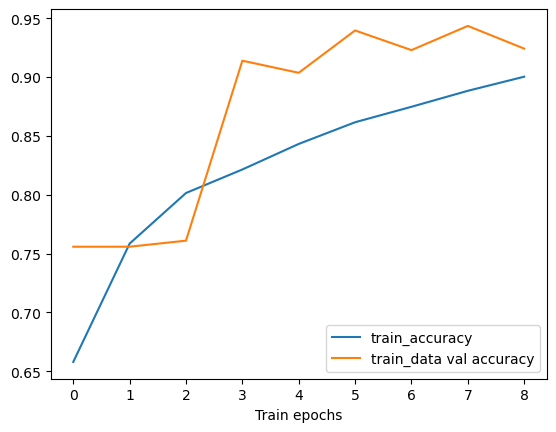

29/29 [==============================] - 0s 268us/step


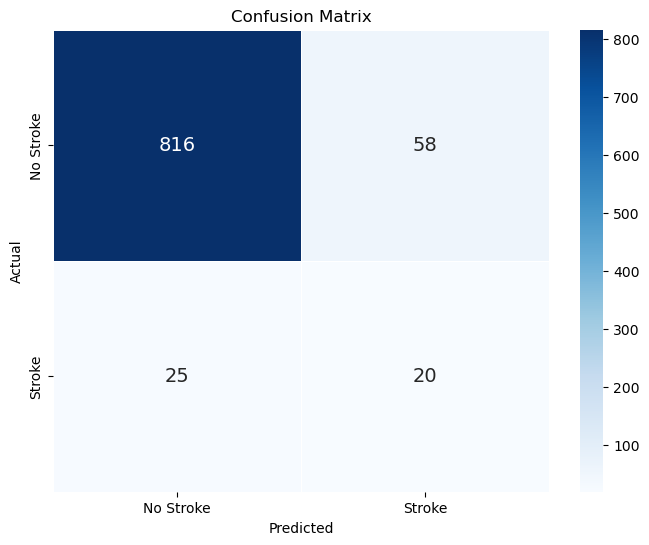

[I 2023-12-10 19:23:59,442] Trial 17 finished with value: 0.6384033752873972 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.029199507929922743, 'num_epochs': 9}. Best is trial 17 with value: 0.6384033752873972.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


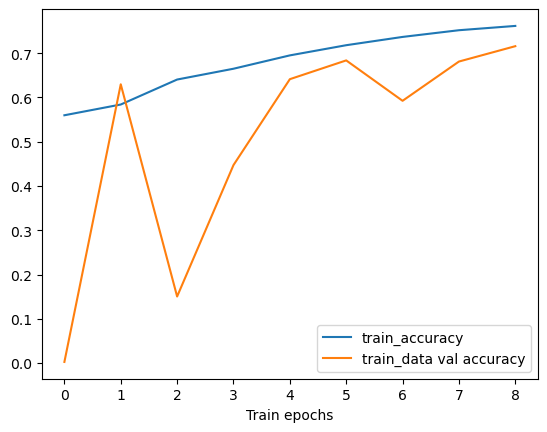

29/29 [==============================] - 0s 246us/step


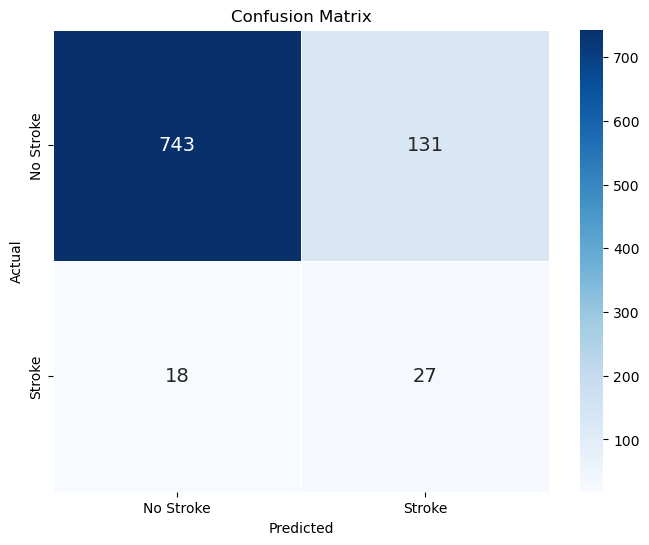

[I 2023-12-10 19:24:00,179] Trial 18 finished with value: 0.5874391768729004 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'SGD', 'learning_rate': 0.02715680162809684, 'num_epochs': 9}. Best is trial 17 with value: 0.6384033752873972.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


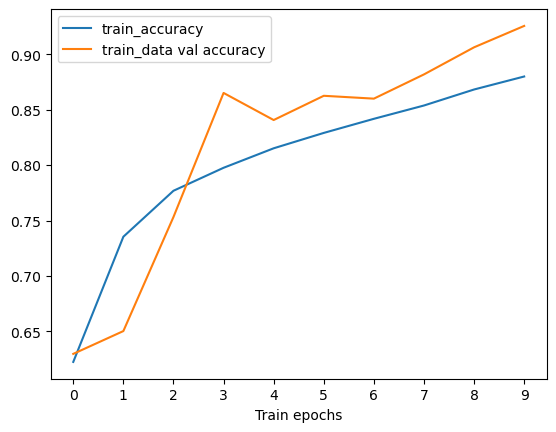

29/29 [==============================] - 0s 258us/step


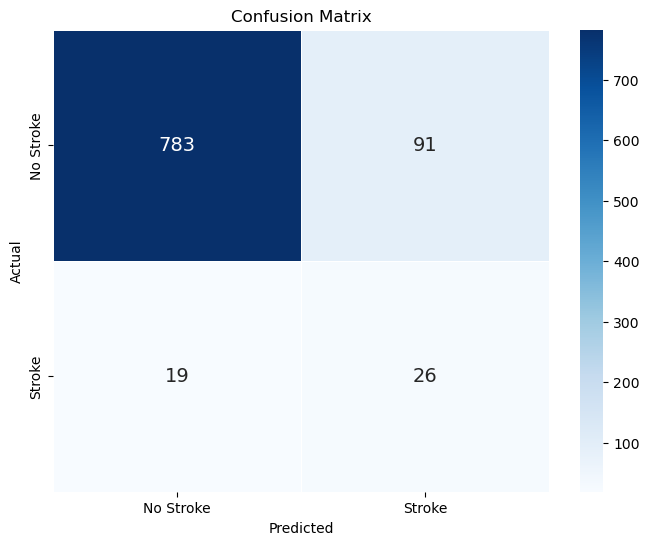

[I 2023-12-10 19:24:01,036] Trial 19 finished with value: 0.6276775980435487 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03573344217385483, 'num_epochs': 10}. Best is trial 17 with value: 0.6384033752873972.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


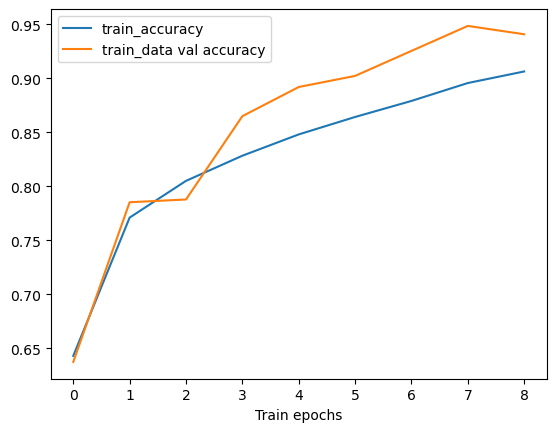

29/29 [==============================] - 0s 263us/step


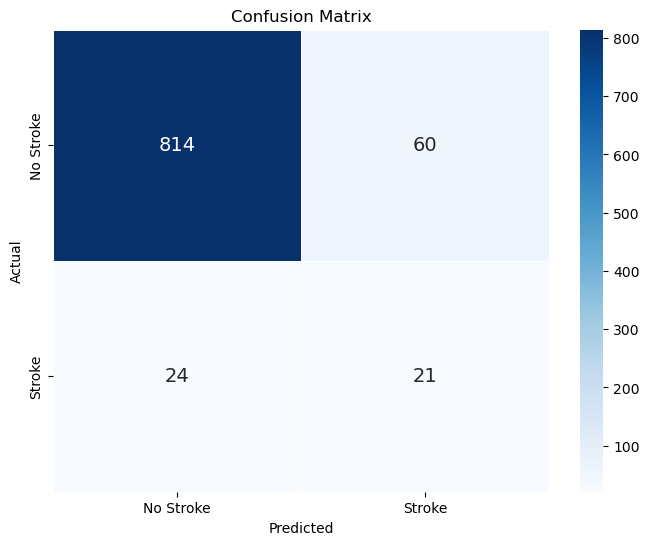

[I 2023-12-10 19:24:01,854] Trial 20 finished with value: 0.6421339563862929 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.016593170650914455, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


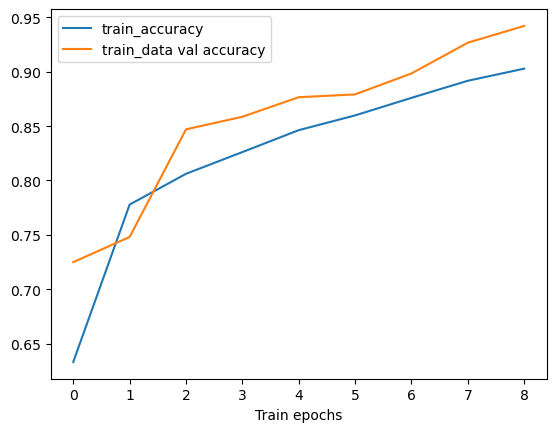

29/29 [==============================] - 0s 255us/step


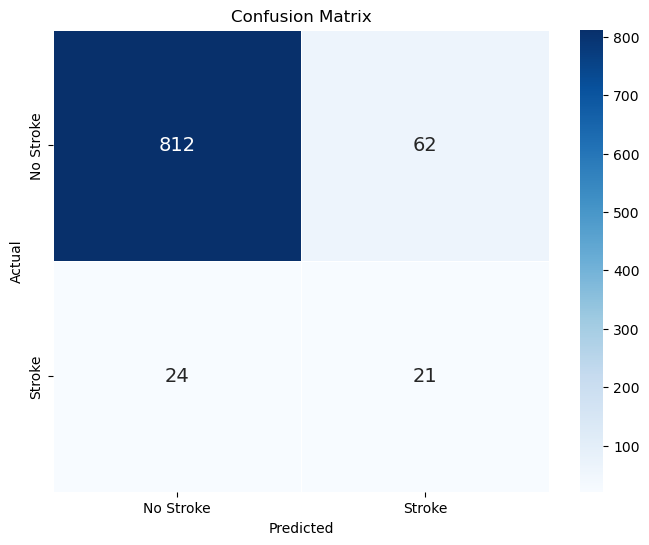

[I 2023-12-10 19:24:02,676] Trial 21 finished with value: 0.6389163011695906 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.017624975433556865, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


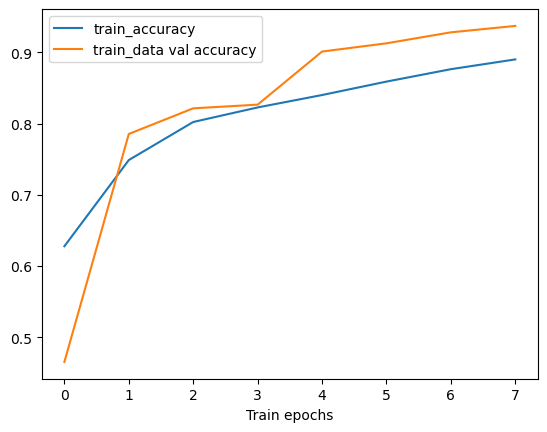

29/29 [==============================] - 0s 264us/step


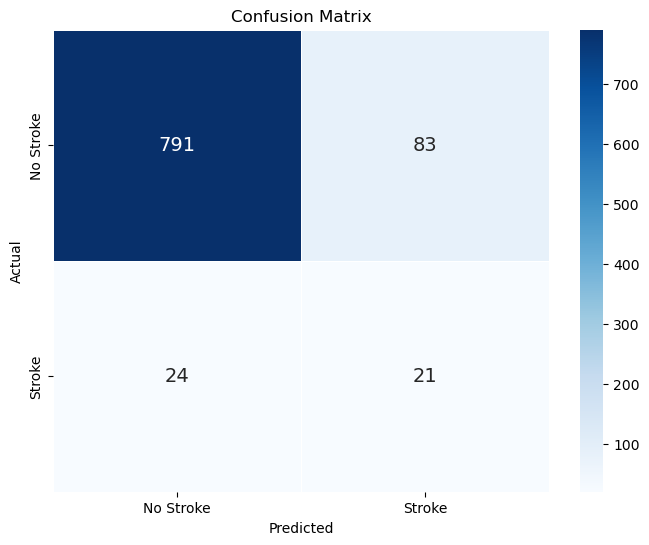

[I 2023-12-10 19:24:03,455] Trial 22 finished with value: 0.6092640496540982 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.01770272436303798, 'num_epochs': 8}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


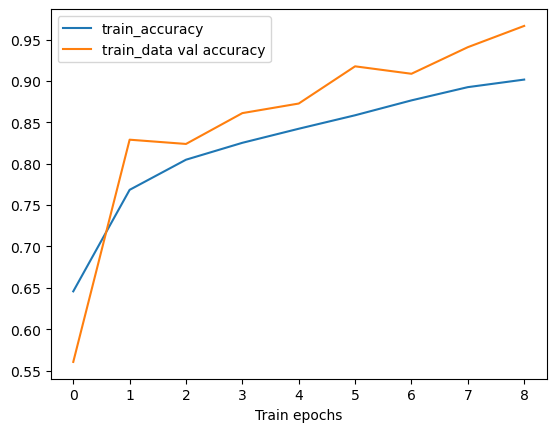

29/29 [==============================] - 0s 283us/step


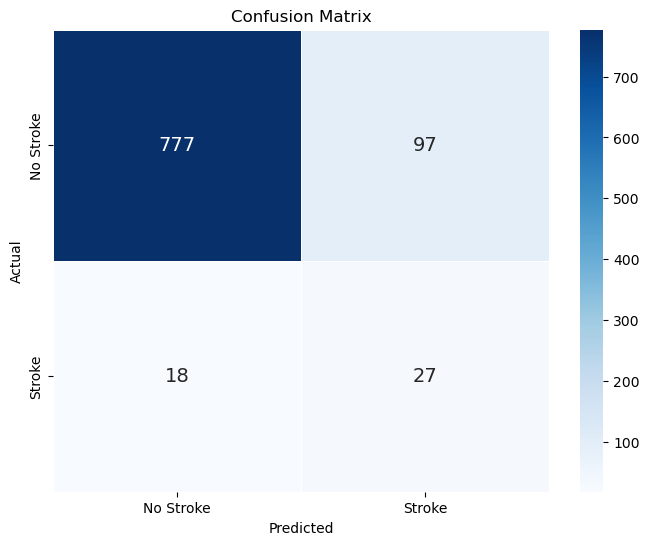

[I 2023-12-10 19:24:04,302] Trial 23 finished with value: 0.6253115460840031 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.015764443942050437, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


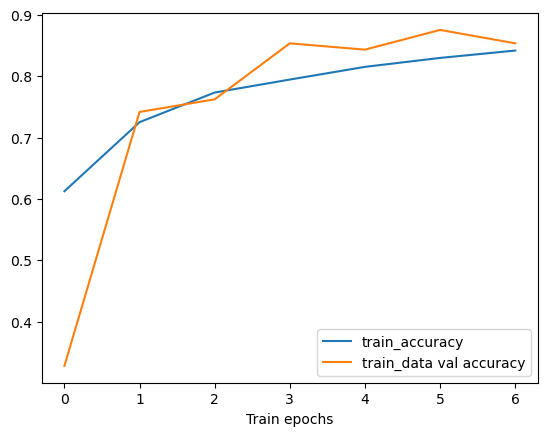

29/29 [==============================] - 0s 283us/step


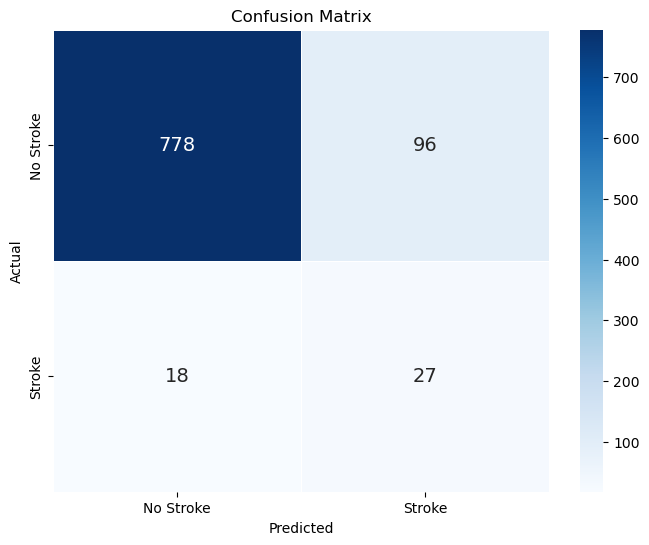

[I 2023-12-10 19:24:05,043] Trial 24 finished with value: 0.6265825491873396 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.010096171939066135, 'num_epochs': 7}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


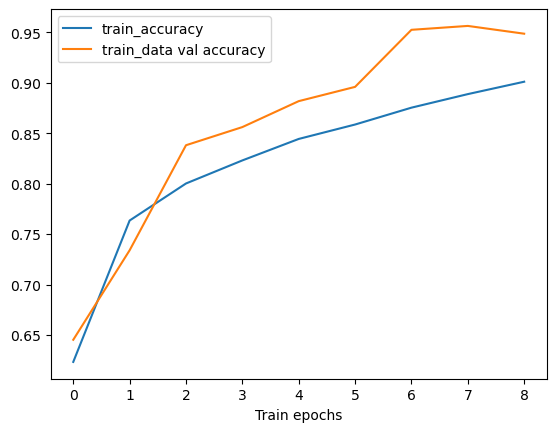

29/29 [==============================] - 0s 254us/step


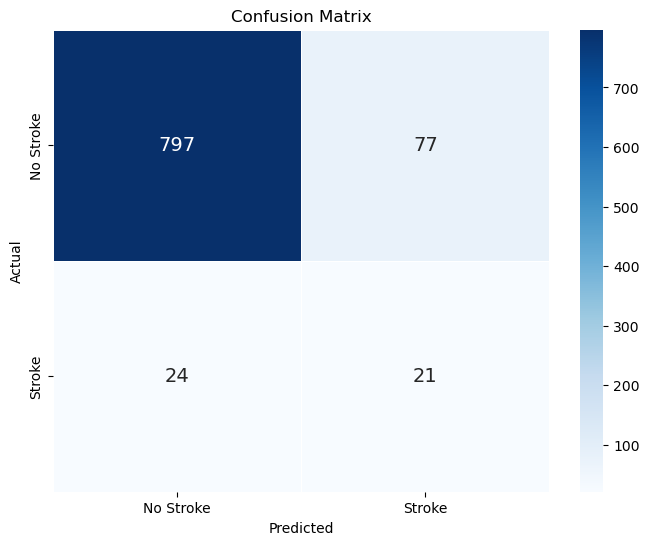

[I 2023-12-10 19:24:05,869] Trial 25 finished with value: 0.617059636528663 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.018292043560090454, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


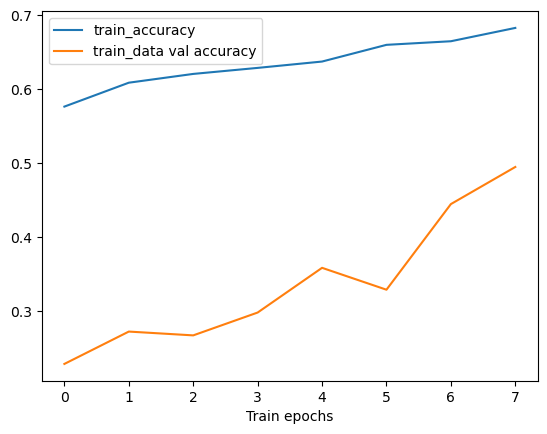

29/29 [==============================] - 0s 272us/step


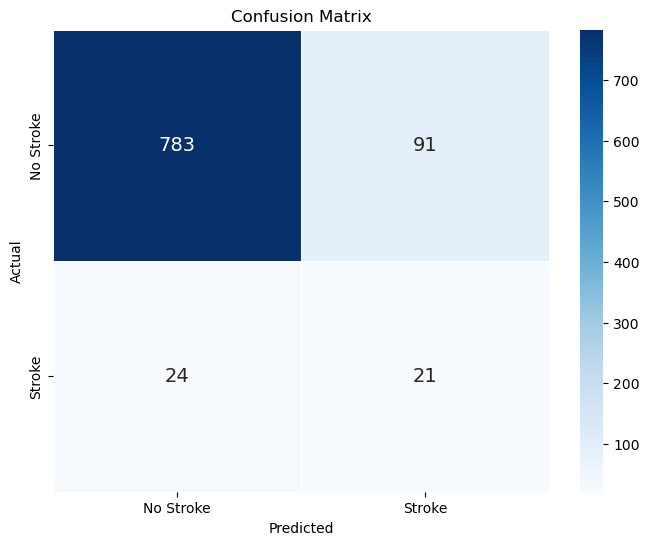

[I 2023-12-10 19:24:06,579] Trial 26 finished with value: 0.5995521319202628 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'SGD', 'learning_rate': 0.014328420541340451, 'num_epochs': 8}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


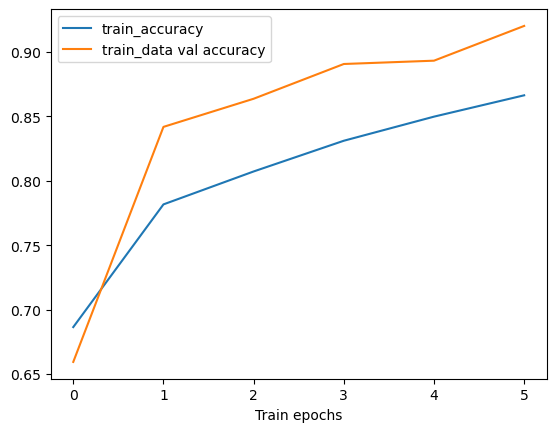

29/29 [==============================] - 0s 269us/step


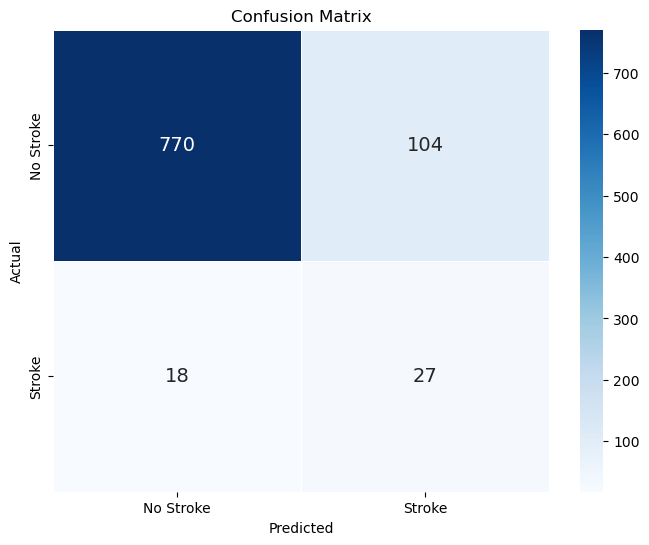

[I 2023-12-10 19:24:07,265] Trial 27 finished with value: 0.6167063231593918 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.022143923778013767, 'num_epochs': 6}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


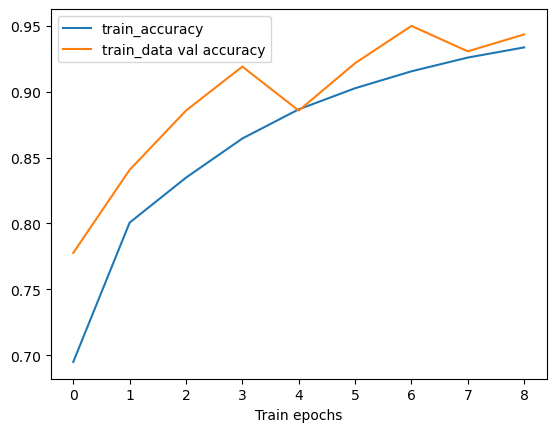

29/29 [==============================] - 0s 249us/step


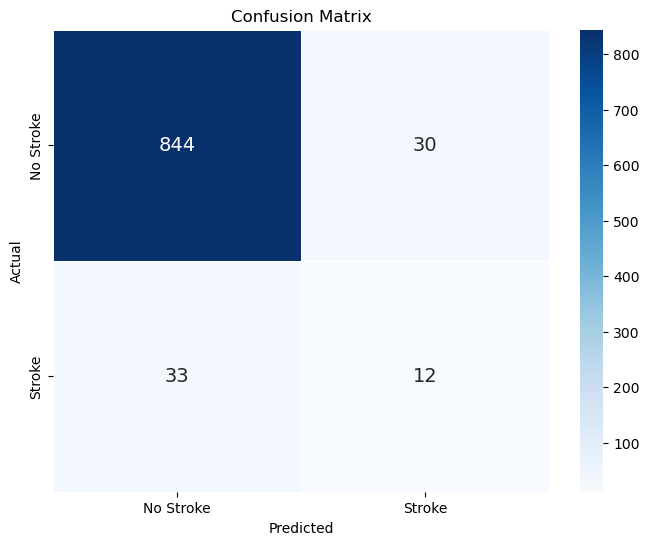

[I 2023-12-10 19:24:08,263] Trial 28 finished with value: 0.61994131432285 and parameters: {'units_layer': 65, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01731967445736994, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


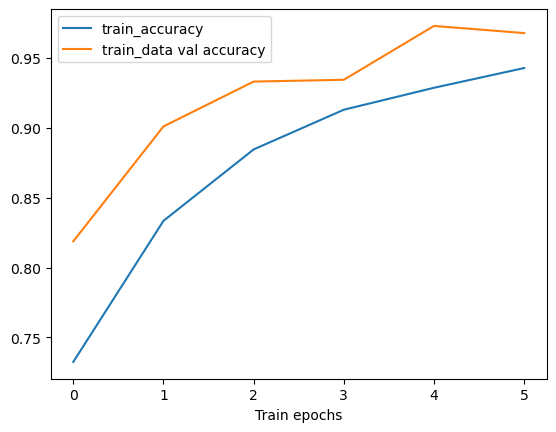

29/29 [==============================] - 0s 243us/step


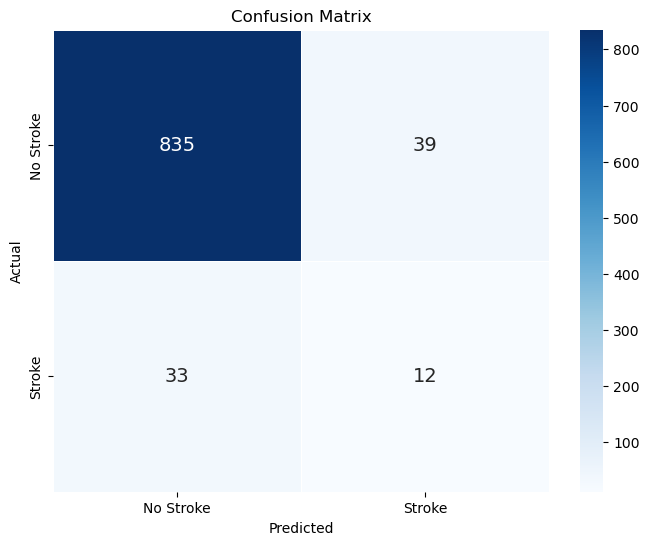

[I 2023-12-10 19:24:08,991] Trial 29 finished with value: 0.6043340987370838 and parameters: {'units_layer': 97, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.012833918704586212, 'num_epochs': 6}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


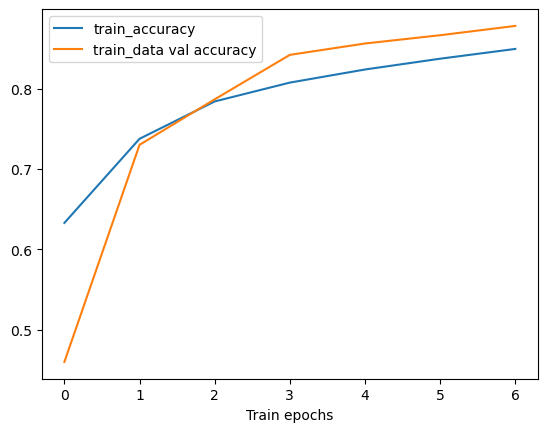

29/29 [==============================] - 0s 259us/step


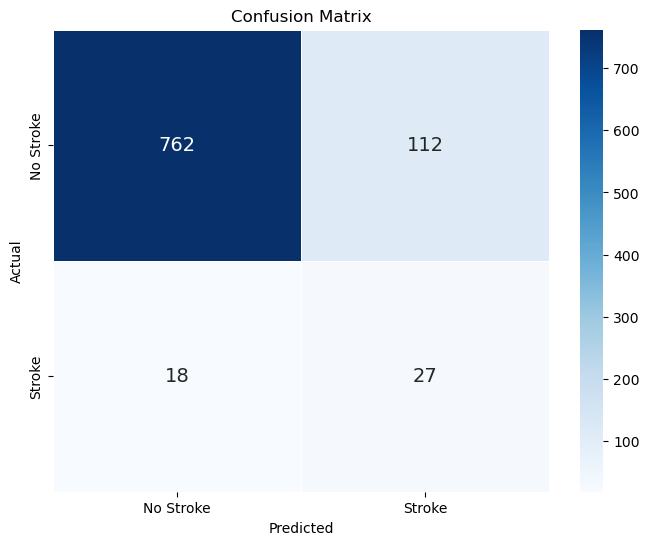

[I 2023-12-10 19:24:09,718] Trial 30 finished with value: 0.6074404605436097 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.024486337813854, 'num_epochs': 7}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


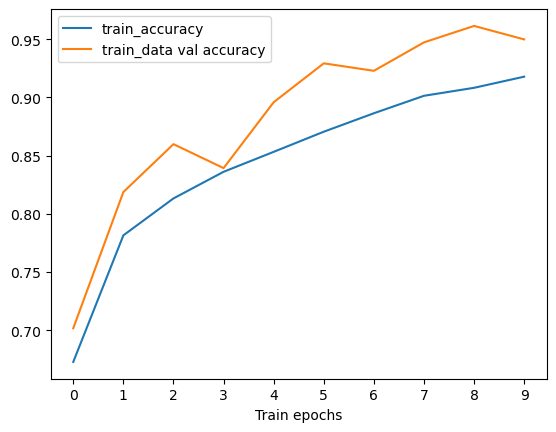

29/29 [==============================] - 0s 243us/step


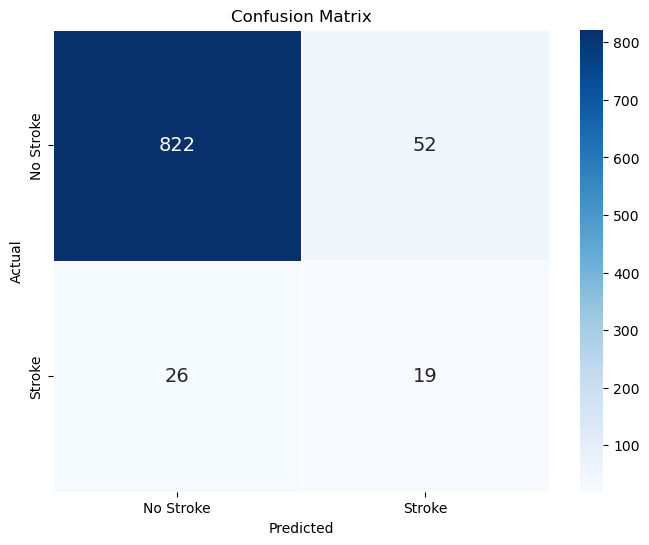

[I 2023-12-10 19:24:10,575] Trial 31 finished with value: 0.6411450198245825 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.022871024240004343, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


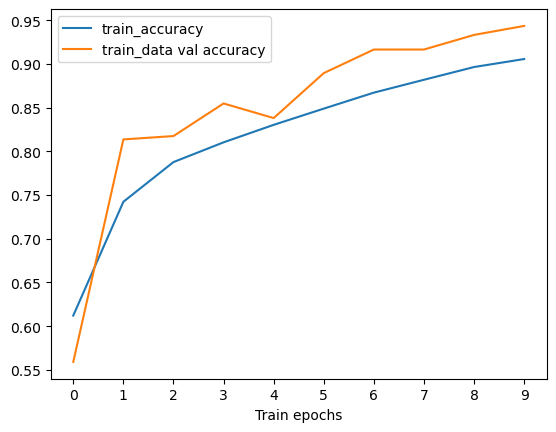

29/29 [==============================] - 0s 258us/step


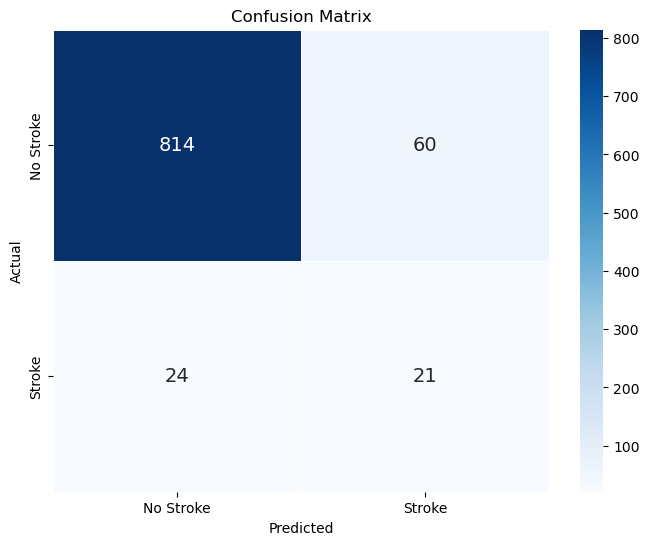

[I 2023-12-10 19:24:11,447] Trial 32 finished with value: 0.6421339563862929 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.030422332176475754, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


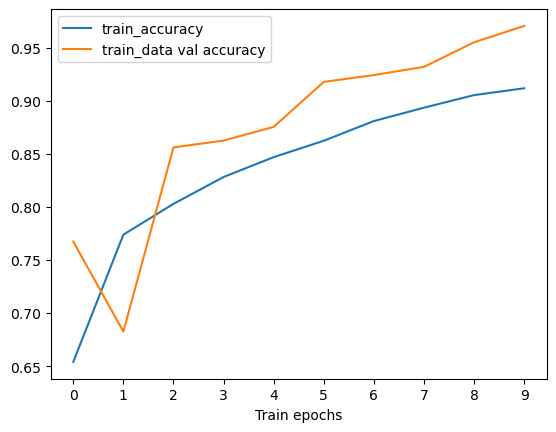

29/29 [==============================] - 0s 233us/step


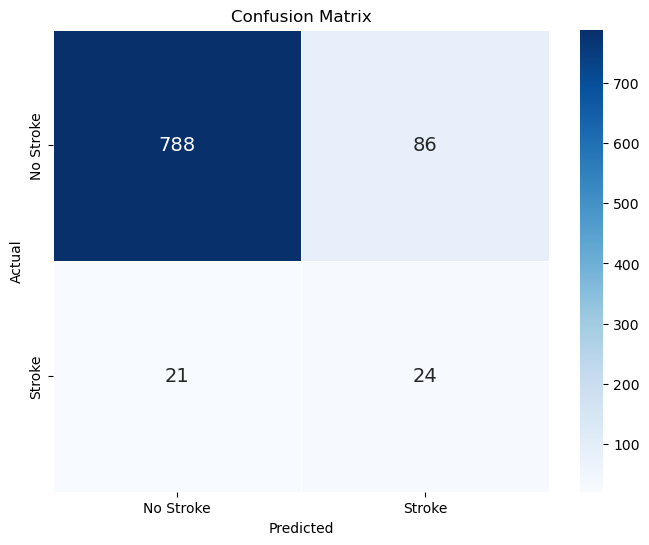

[I 2023-12-10 19:24:12,312] Trial 33 finished with value: 0.6230502367124757 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.019228252937618377, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


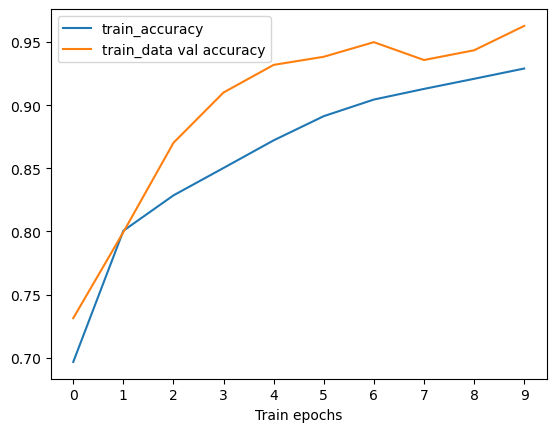

29/29 [==============================] - 0s 276us/step


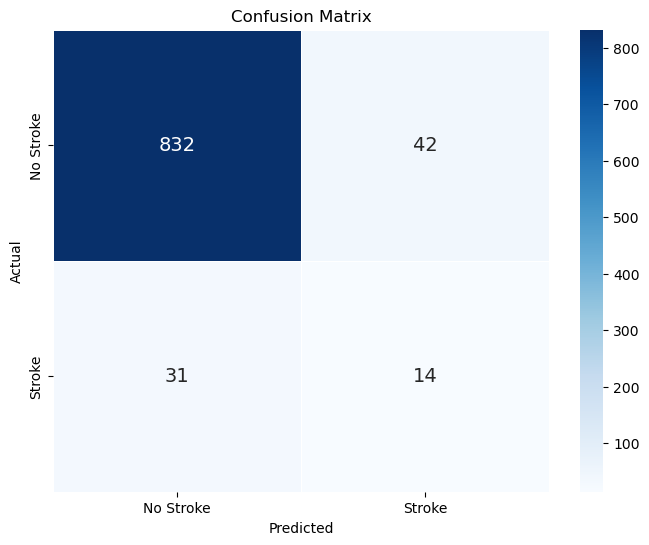

[I 2023-12-10 19:24:13,280] Trial 34 finished with value: 0.6176006201656434 and parameters: {'units_layer': 97, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03074504285905595, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


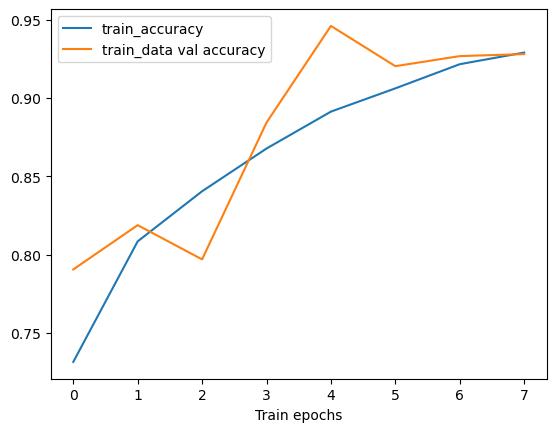

29/29 [==============================] - 0s 276us/step


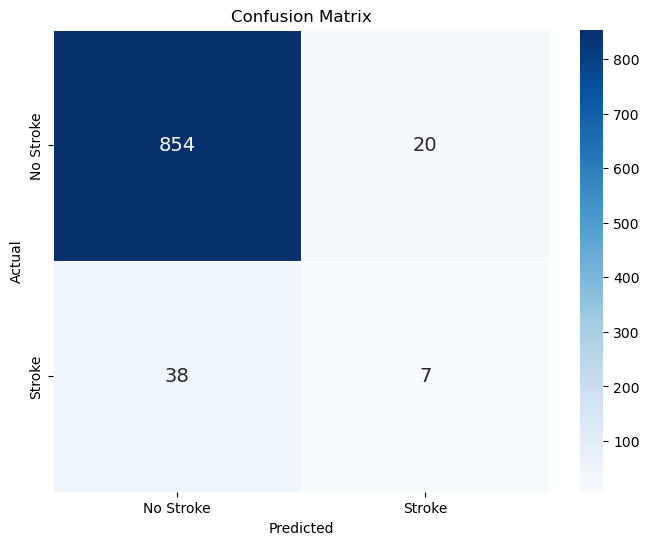

[I 2023-12-10 19:24:14,086] Trial 35 finished with value: 0.5808009311689946 and parameters: {'units_layer': 65, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020770581891390485, 'num_epochs': 8}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


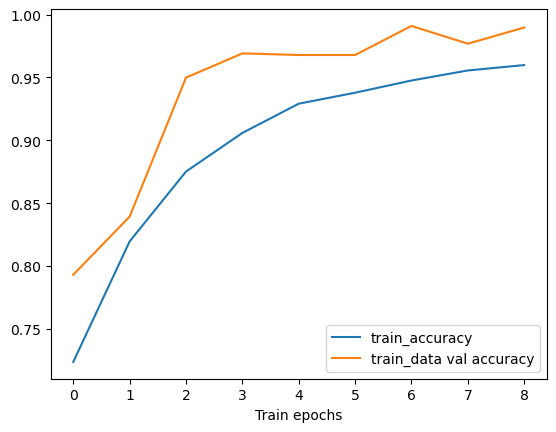

29/29 [==============================] - 0s 288us/step


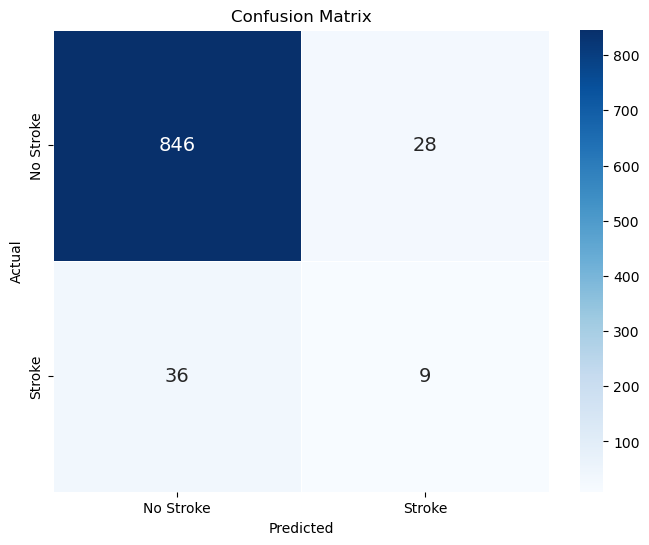

[I 2023-12-10 19:24:15,005] Trial 36 finished with value: 0.5915328629368298 and parameters: {'units_layer': 97, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.02460488330053982, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


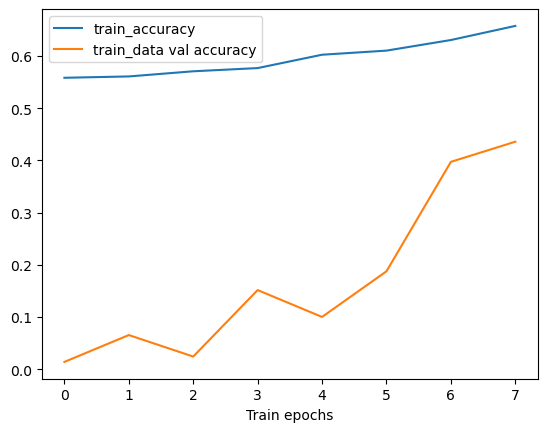

29/29 [==============================] - 0s 266us/step


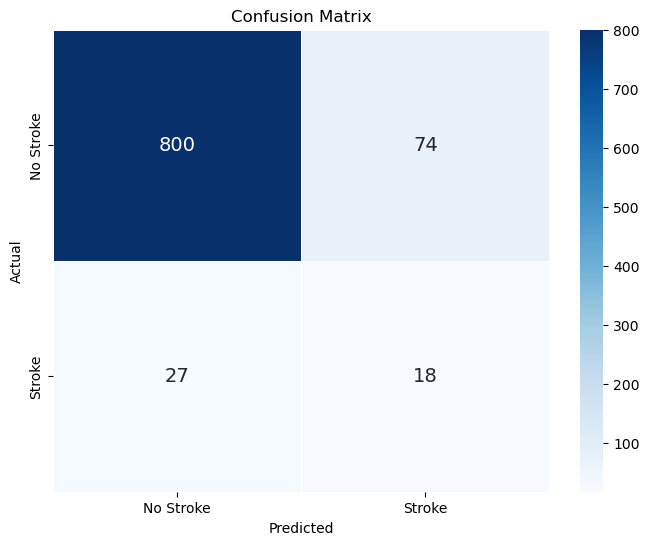

[I 2023-12-10 19:24:15,723] Trial 37 finished with value: 0.6016984427365611 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'SGD', 'learning_rate': 0.01259591867291005, 'num_epochs': 8}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


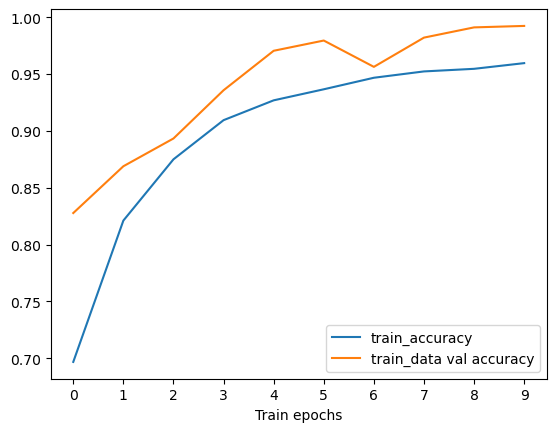

29/29 [==============================] - 0s 276us/step


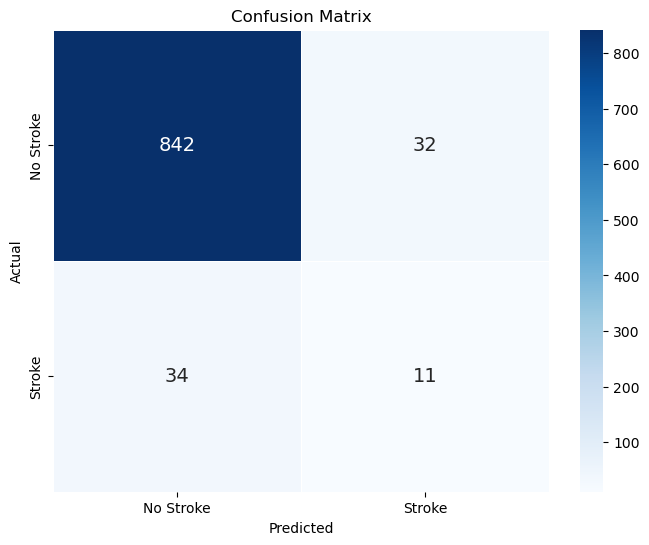

[I 2023-12-10 19:24:16,840] Trial 38 finished with value: 0.6061428571428571 and parameters: {'units_layer': 97, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.015975226582200113, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


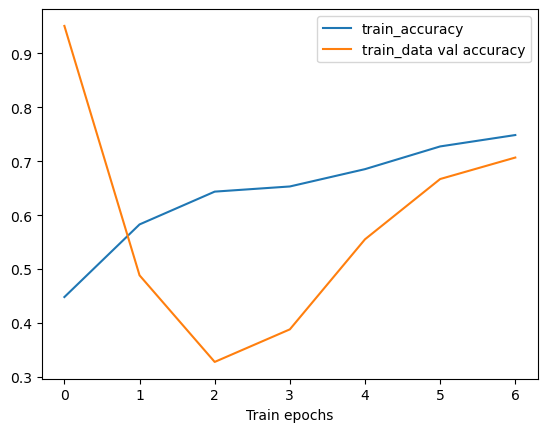

29/29 [==============================] - 0s 259us/step


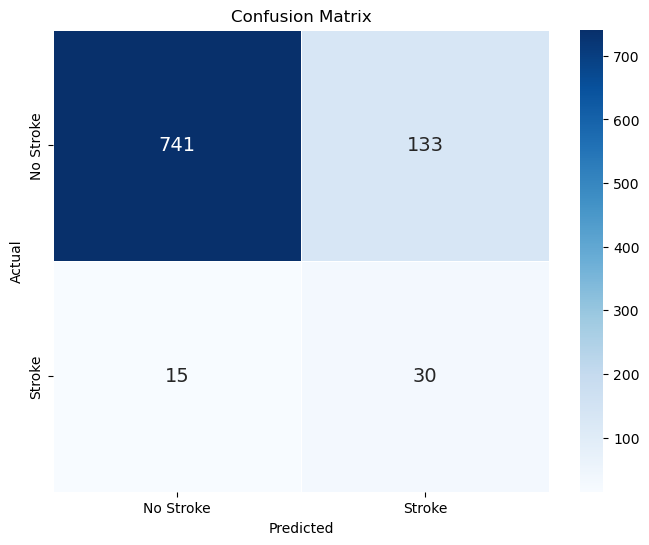

[I 2023-12-10 19:24:17,508] Trial 39 finished with value: 0.5988319962246342 and parameters: {'units_layer': 1, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03251335872353558, 'num_epochs': 7}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


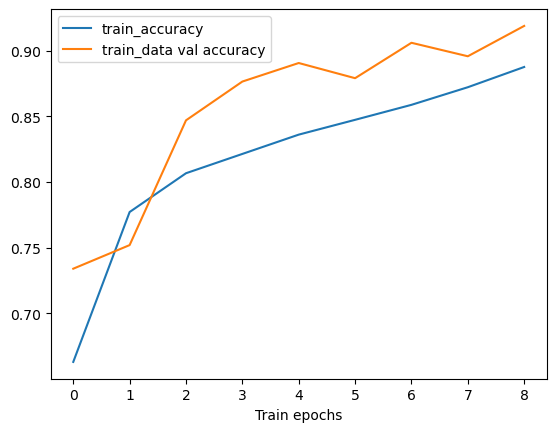

29/29 [==============================] - 0s 244us/step


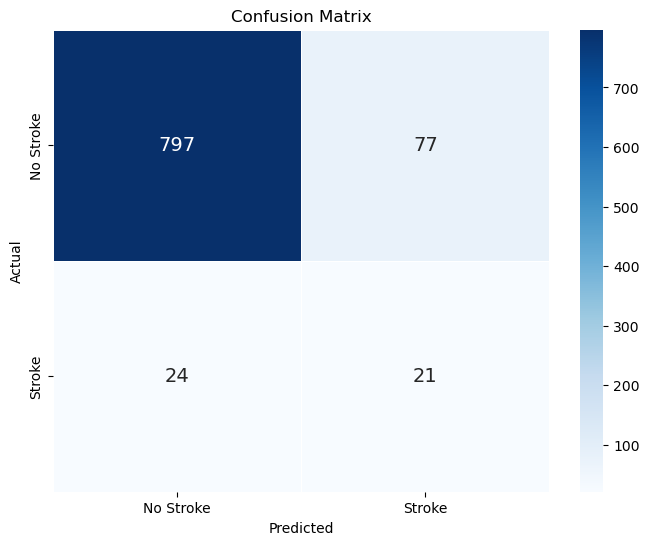

[I 2023-12-10 19:24:18,237] Trial 40 finished with value: 0.617059636528663 and parameters: {'units_layer': 65, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.039455094988677754, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


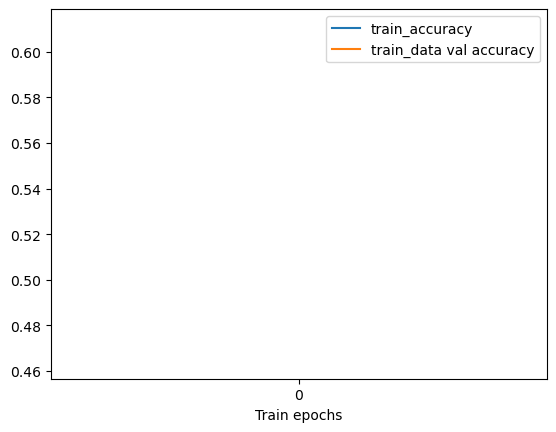

29/29 [==============================] - 0s 260us/step


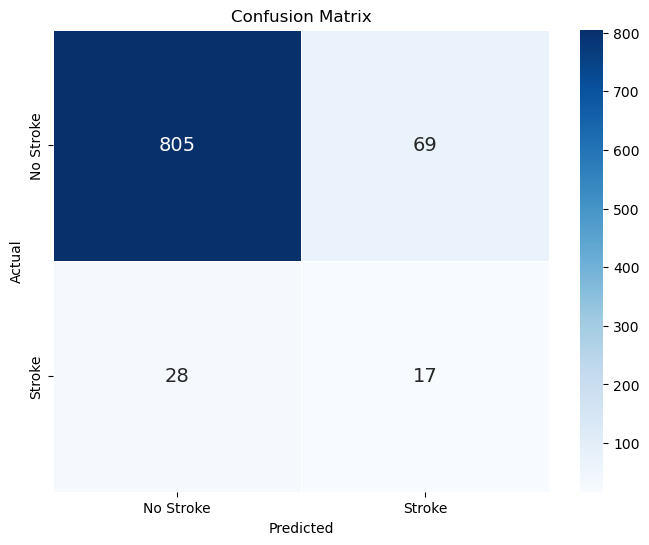

[I 2023-12-10 19:24:18,701] Trial 41 finished with value: 0.6013585729170858 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.02879790201601416, 'num_epochs': 1}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


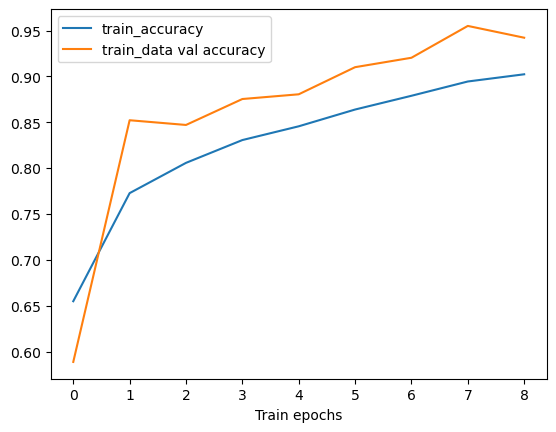

29/29 [==============================] - 0s 245us/step


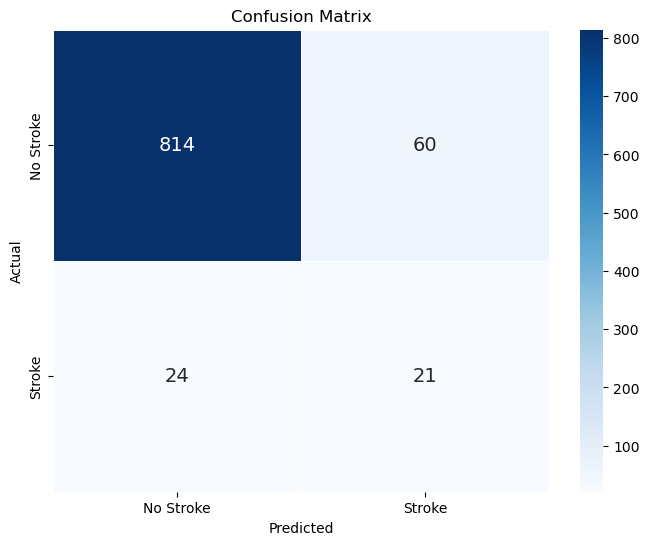

[I 2023-12-10 19:24:19,527] Trial 42 finished with value: 0.6421339563862929 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.025650609428763335, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


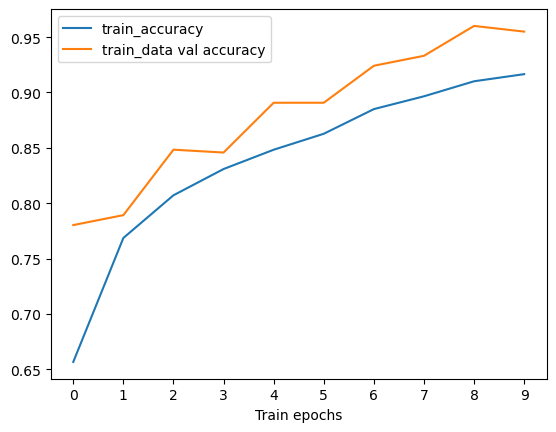

29/29 [==============================] - 0s 283us/step


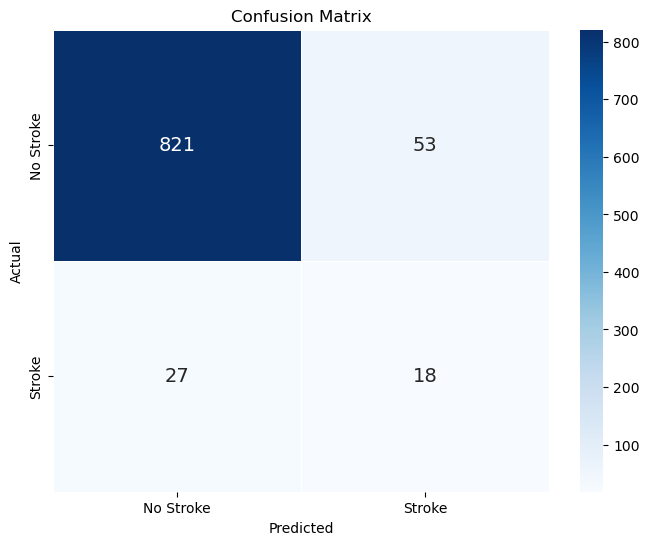

[I 2023-12-10 19:24:20,421] Trial 43 finished with value: 0.6319436100764948 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.023960282318634233, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


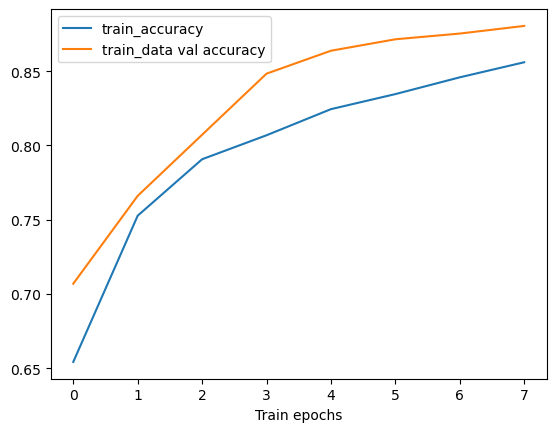

29/29 [==============================] - 0s 271us/step


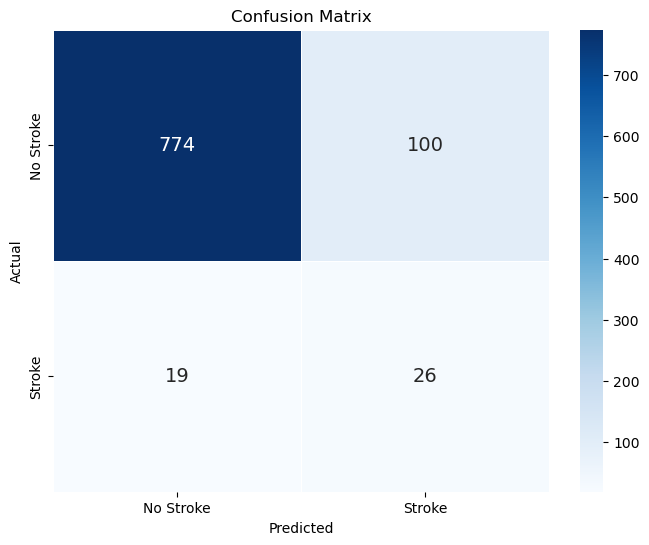

[I 2023-12-10 19:24:21,204] Trial 44 finished with value: 0.6163539221980165 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.019872621512713424, 'num_epochs': 8}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


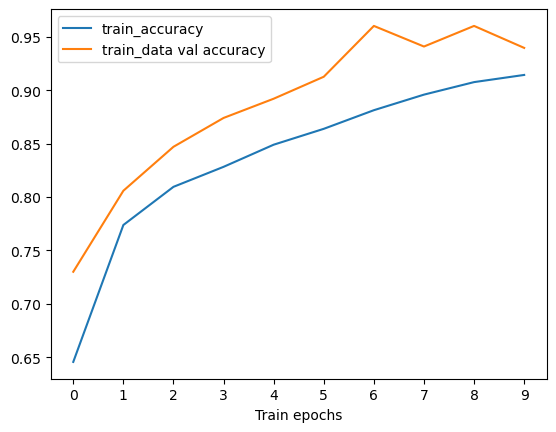

29/29 [==============================] - 0s 276us/step


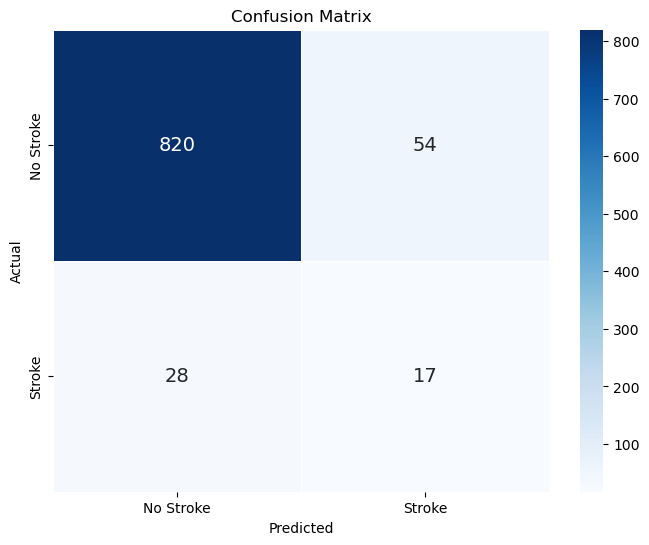

[I 2023-12-10 19:24:22,085] Trial 45 finished with value: 0.6227422003284072 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.025704352316848693, 'num_epochs': 10}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


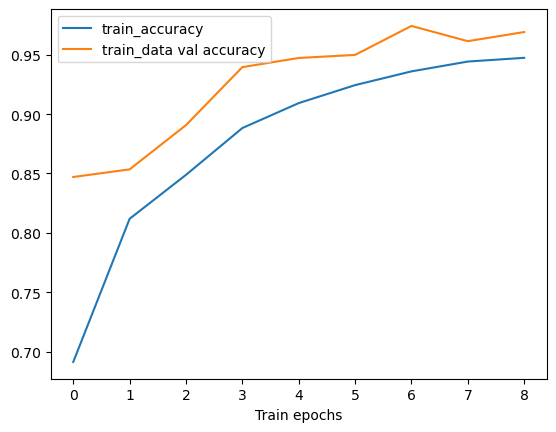

29/29 [==============================] - 0s 278us/step


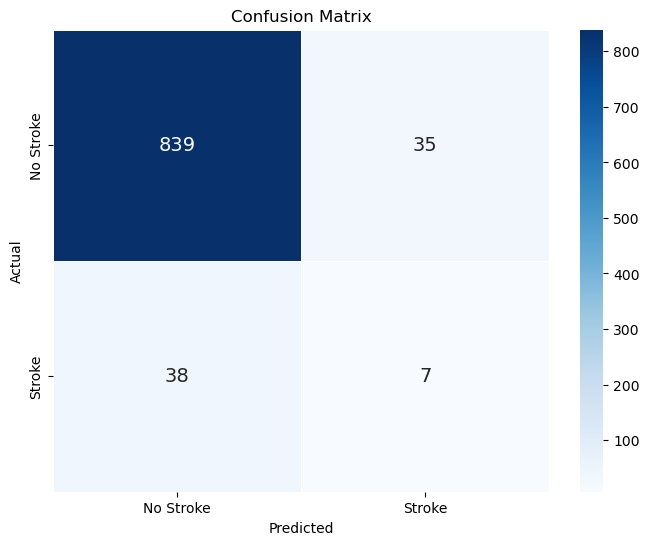

[I 2023-12-10 19:24:22,935] Trial 46 finished with value: 0.5596145388185405 and parameters: {'units_layer': 65, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.02216773727519957, 'num_epochs': 9}. Best is trial 20 with value: 0.6421339563862929.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


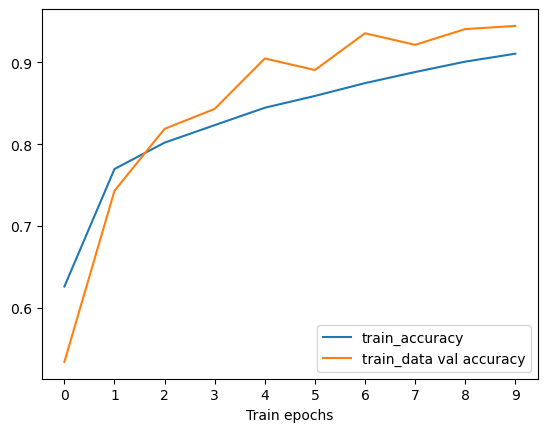

29/29 [==============================] - 0s 270us/step


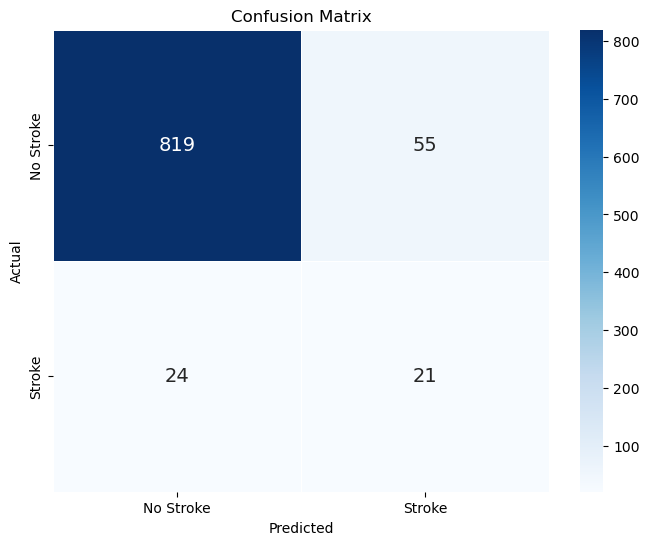

[I 2023-12-10 19:24:23,818] Trial 47 finished with value: 0.6505484773076239 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03194178206660875, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


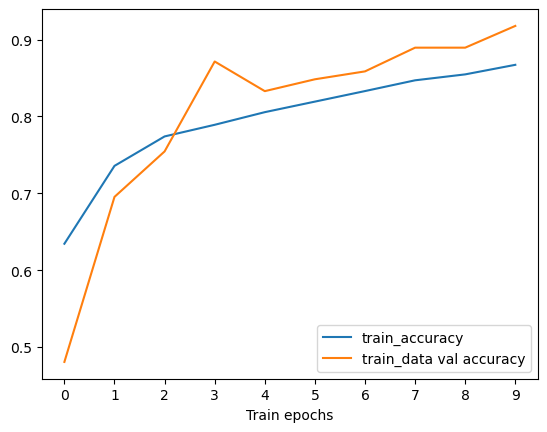

29/29 [==============================] - 0s 281us/step


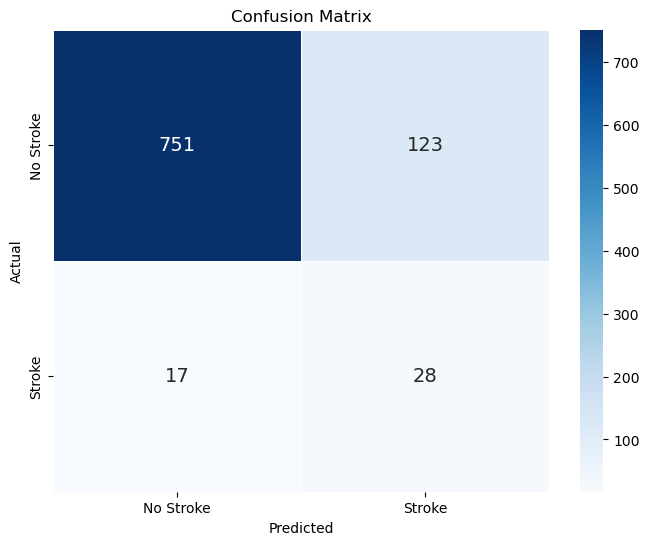

[I 2023-12-10 19:24:24,612] Trial 48 finished with value: 0.6002262049765095 and parameters: {'units_layer': 33, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.03145421590097916, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


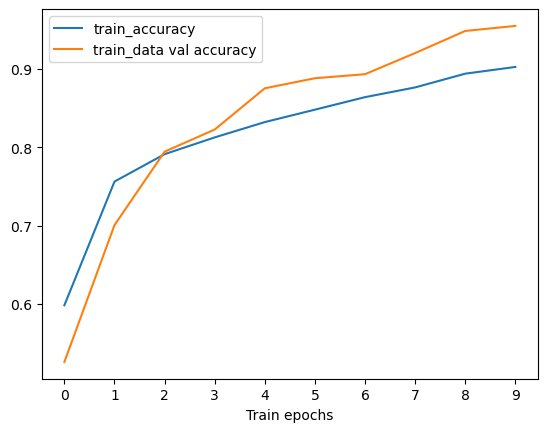

29/29 [==============================] - 0s 263us/step


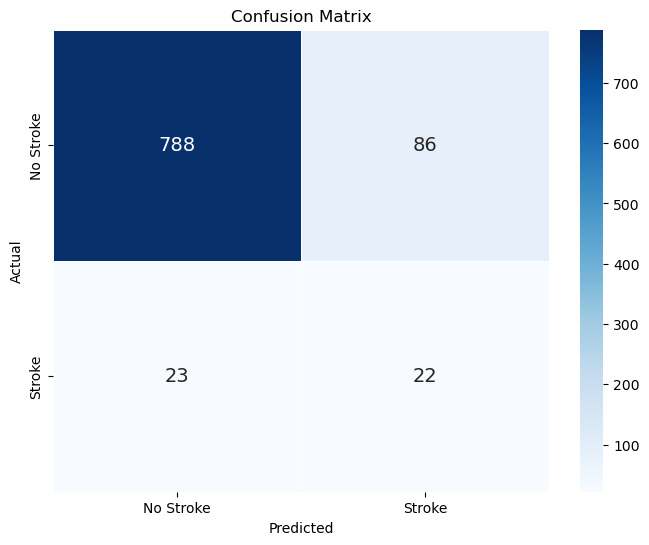

[I 2023-12-10 19:24:25,500] Trial 49 finished with value: 0.611446636023351 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.0363918992573478, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


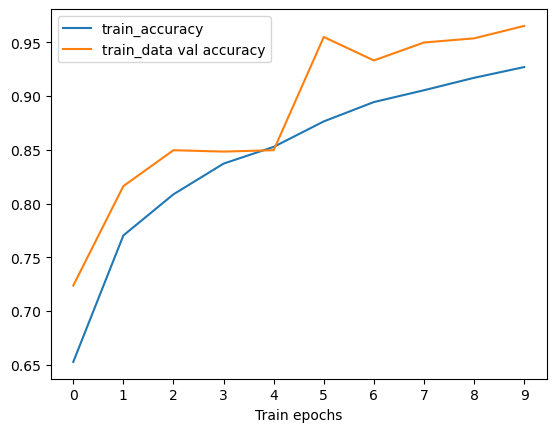

29/29 [==============================] - 0s 290us/step


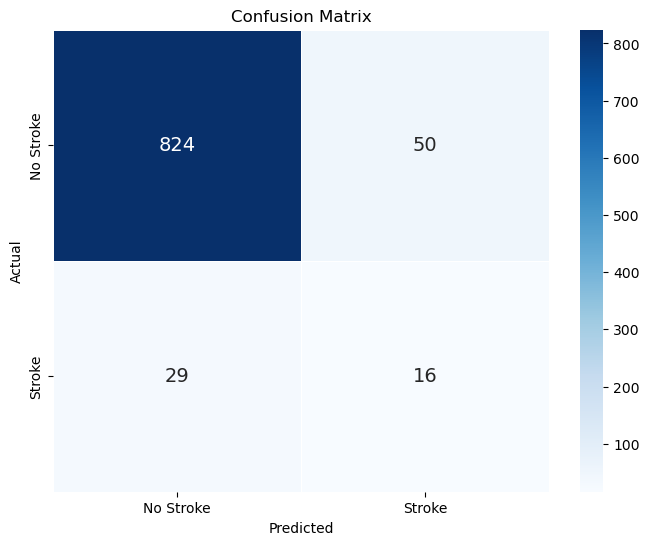

[I 2023-12-10 19:24:26,662] Trial 50 finished with value: 0.6212721117179716 and parameters: {'units_layer': 97, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.04484841250798164, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


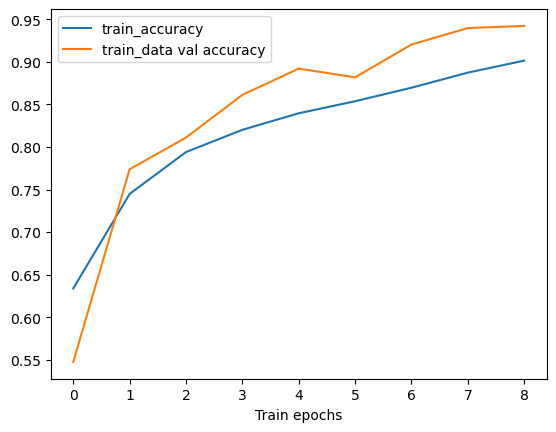

29/29 [==============================] - 0s 263us/step


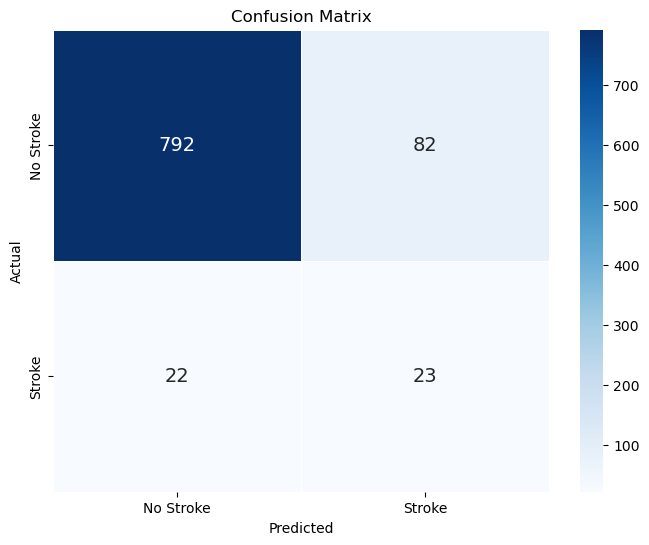

[I 2023-12-10 19:24:27,507] Trial 51 finished with value: 0.6225276461295419 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.026936339299833943, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


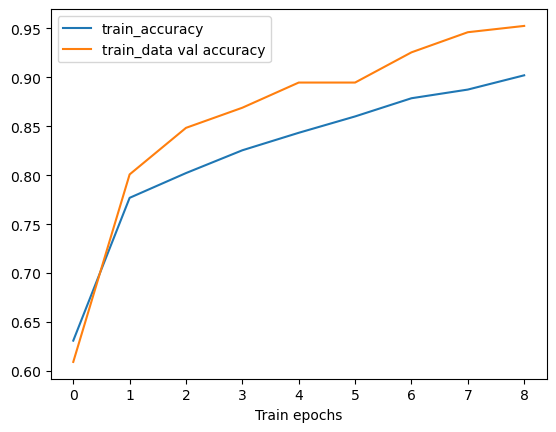

29/29 [==============================] - 0s 283us/step


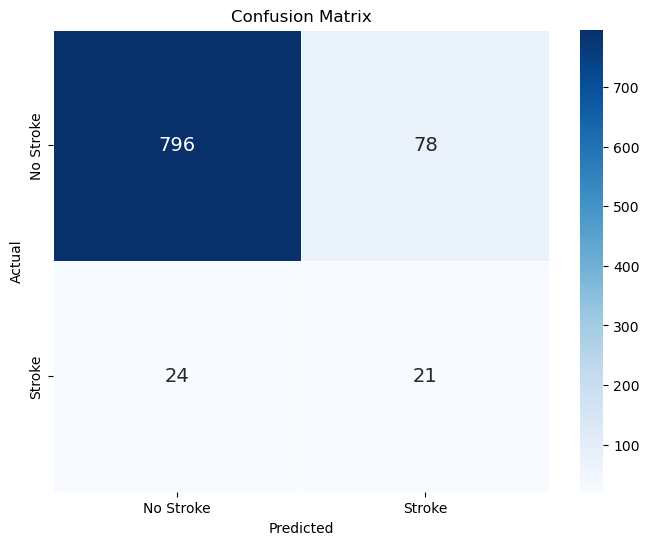

[I 2023-12-10 19:24:28,351] Trial 52 finished with value: 0.6157270759543486 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.022515983632971998, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


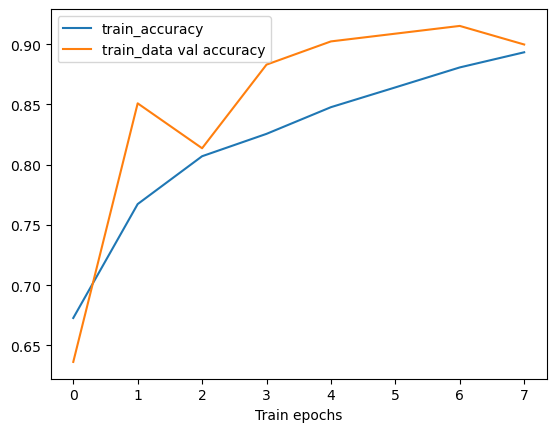

29/29 [==============================] - 0s 249us/step


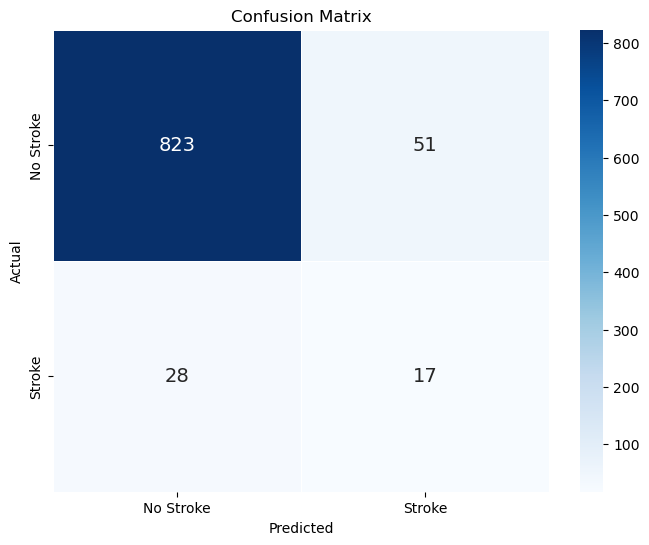

[I 2023-12-10 19:24:29,147] Trial 53 finished with value: 0.6275439271514685 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.020113373541525623, 'num_epochs': 8}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


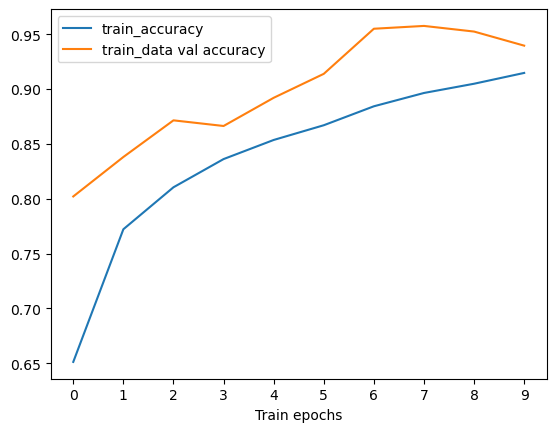

29/29 [==============================] - 0s 270us/step


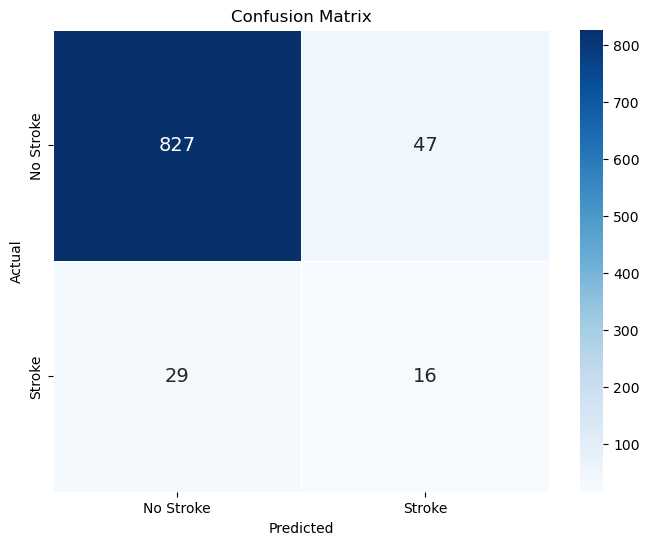

[I 2023-12-10 19:24:30,042] Trial 54 finished with value: 0.626182830229073 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.026975894717117897, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


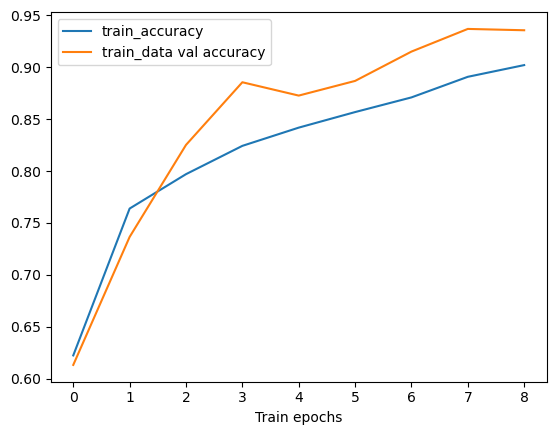

29/29 [==============================] - 0s 294us/step


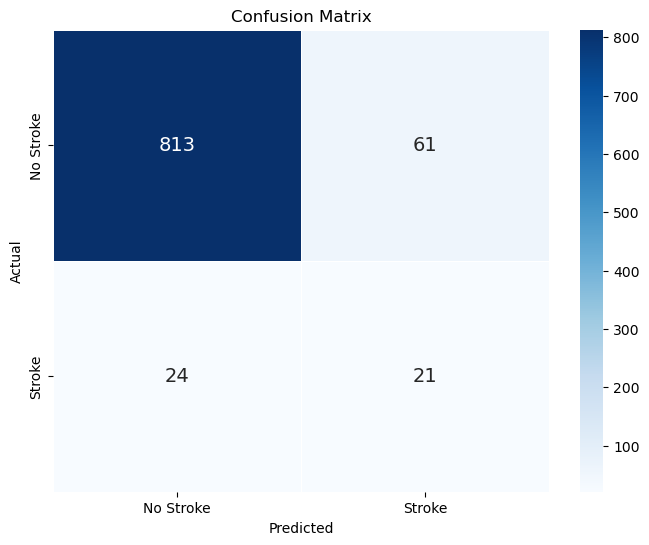

[I 2023-12-10 19:24:30,889] Trial 55 finished with value: 0.6405150554310459 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03257758137527722, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


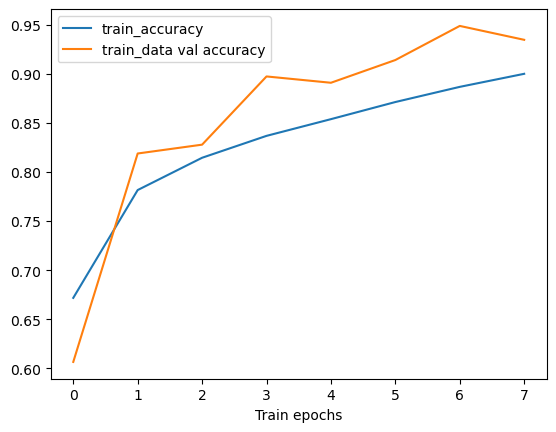

29/29 [==============================] - 0s 292us/step


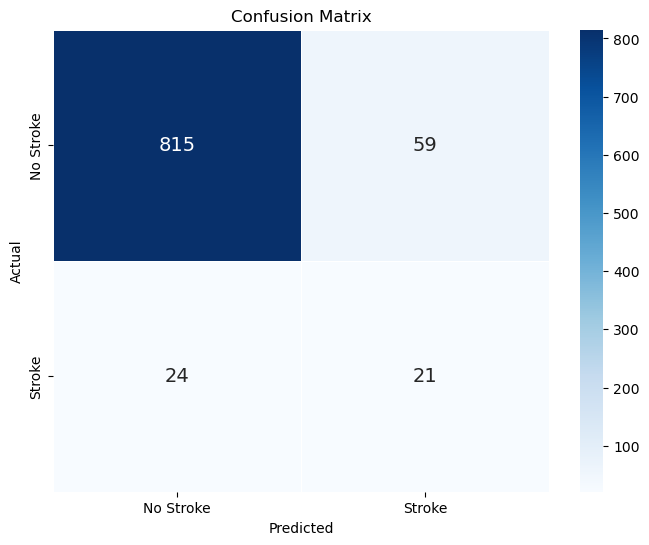

[I 2023-12-10 19:24:31,695] Trial 56 finished with value: 0.6437734967892587 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03313959301554093, 'num_epochs': 8}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


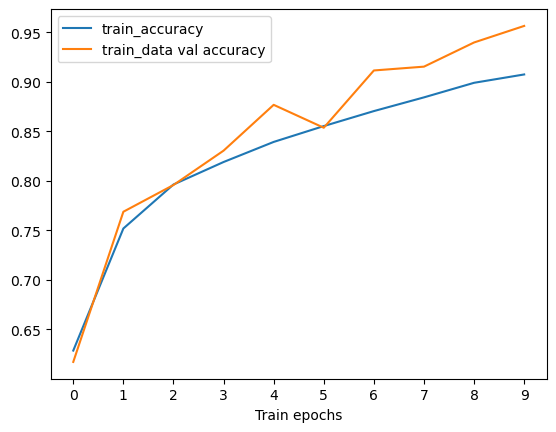

29/29 [==============================] - 0s 277us/step


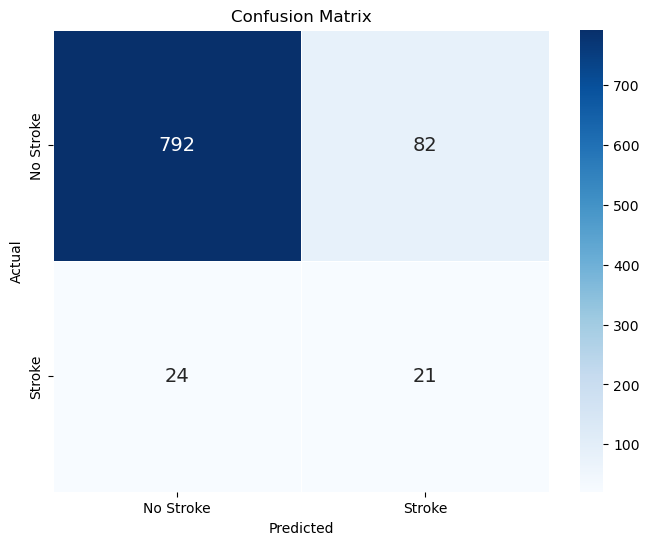

[I 2023-12-10 19:24:32,606] Trial 57 finished with value: 0.6105309451463298 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.029694518317533104, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


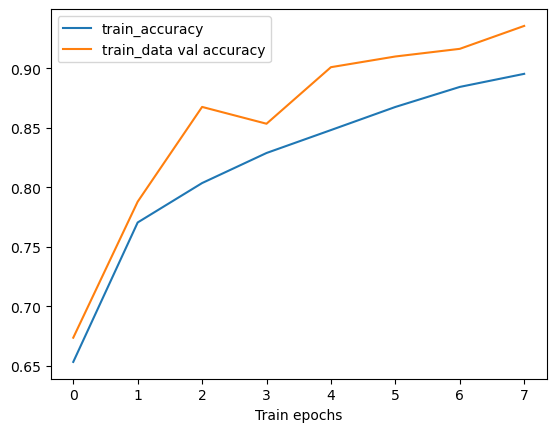

29/29 [==============================] - 0s 313us/step


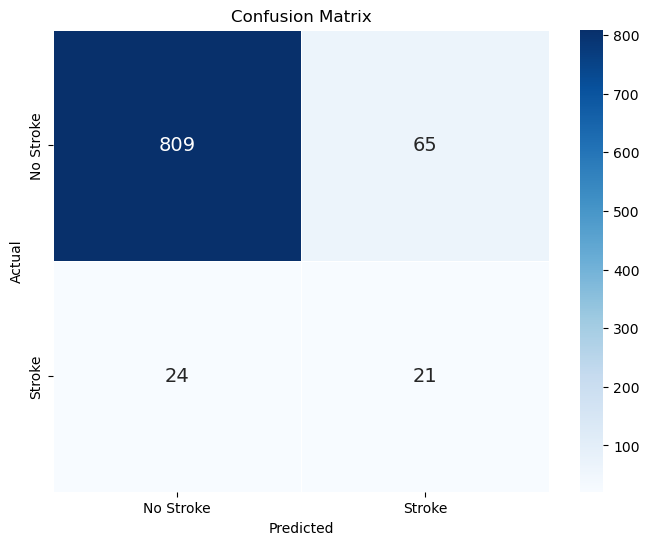

[I 2023-12-10 19:24:33,425] Trial 58 finished with value: 0.6342362163878417 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03332989128251782, 'num_epochs': 8}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


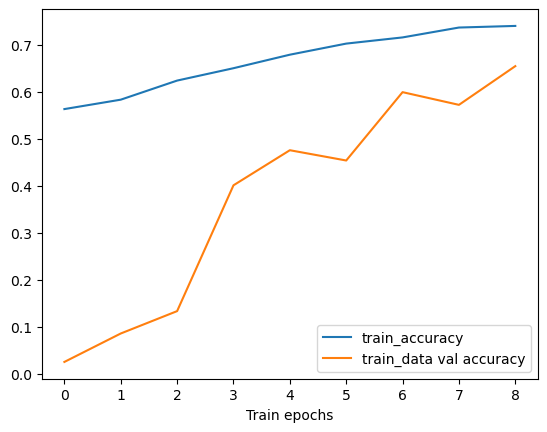

29/29 [==============================] - 0s 271us/step


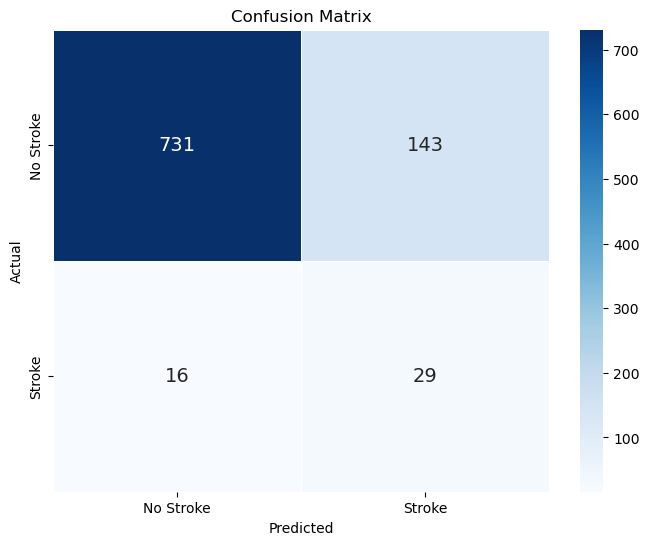

[I 2023-12-10 19:24:34,189] Trial 59 finished with value: 0.5845967528720111 and parameters: {'units_layer': 33, 'activation': 'sigmoid', 'optimizer': 'SGD', 'learning_rate': 0.029204051518903845, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


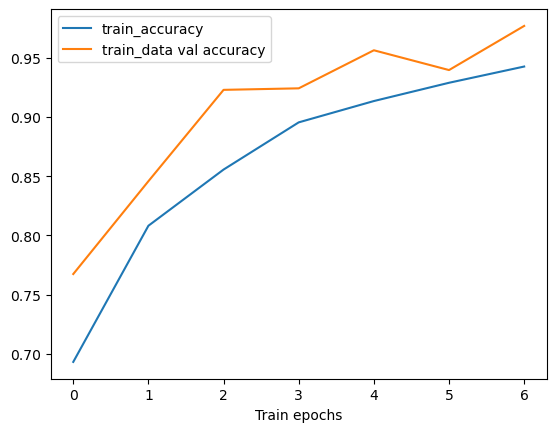

29/29 [==============================] - 0s 252us/step


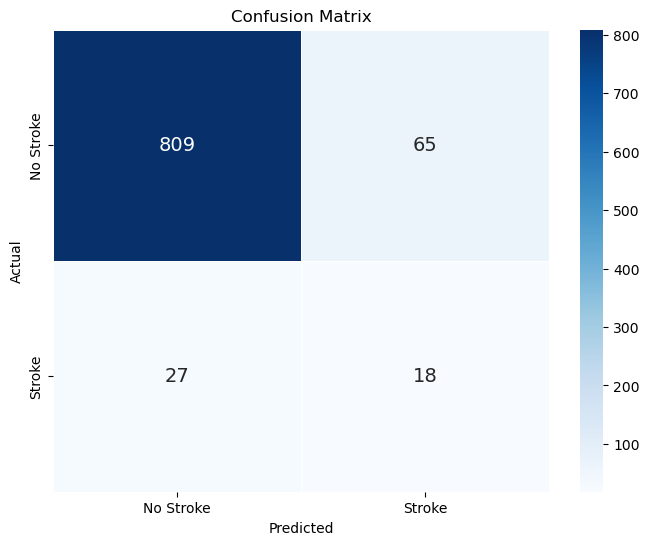

[I 2023-12-10 19:24:34,955] Trial 60 finished with value: 0.6137244152046784 and parameters: {'units_layer': 65, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.03620438414406662, 'num_epochs': 7}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


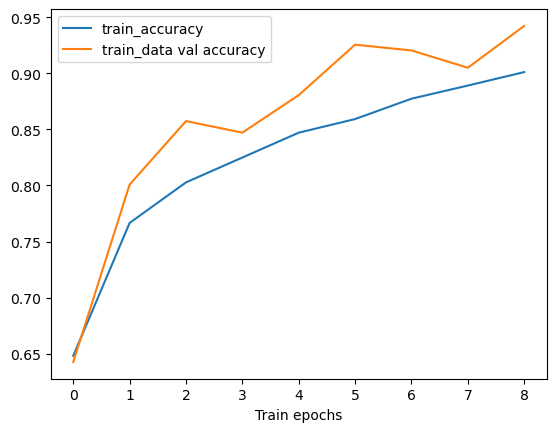

29/29 [==============================] - 0s 268us/step


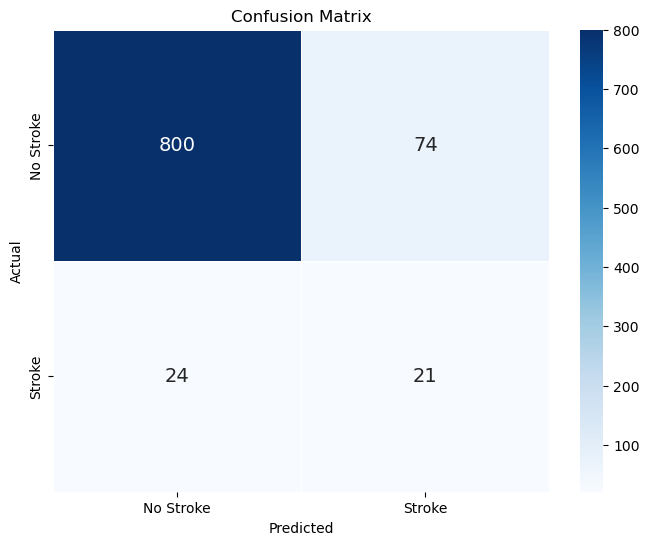

[I 2023-12-10 19:24:35,971] Trial 61 finished with value: 0.6211425206124853 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.031737712074674025, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


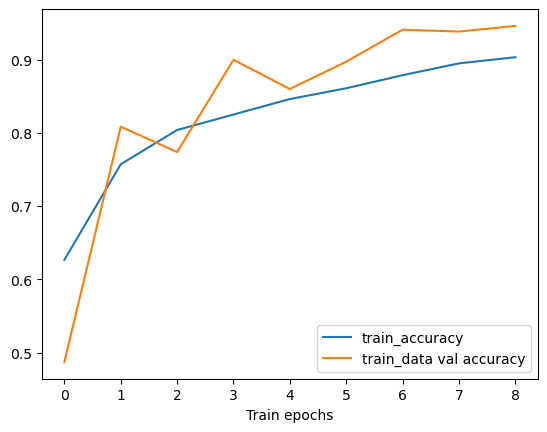

29/29 [==============================] - 0s 302us/step


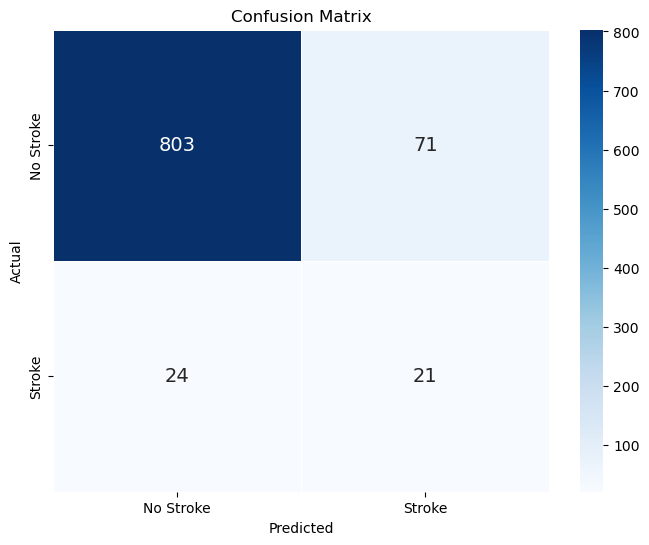

[I 2023-12-10 19:24:36,829] Trial 62 finished with value: 0.6253599213858744 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.026345501204066472, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


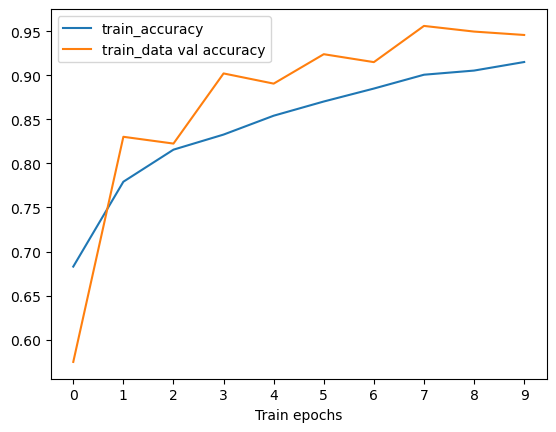

29/29 [==============================] - 0s 266us/step


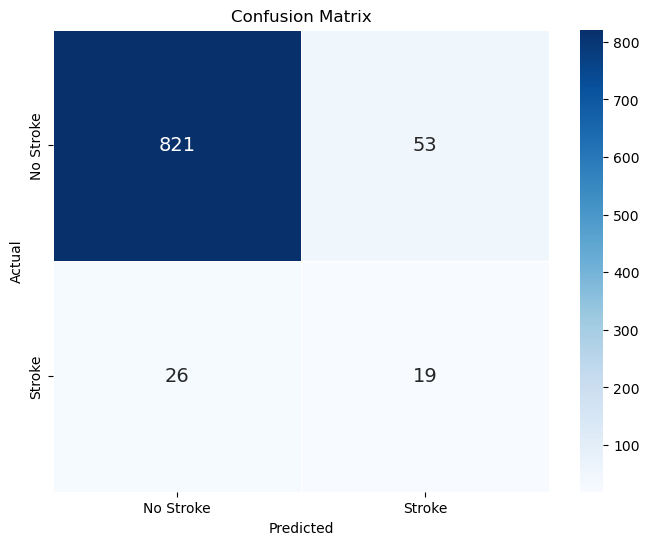

[I 2023-12-10 19:24:37,747] Trial 63 finished with value: 0.6394413901677121 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.03405219763814098, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


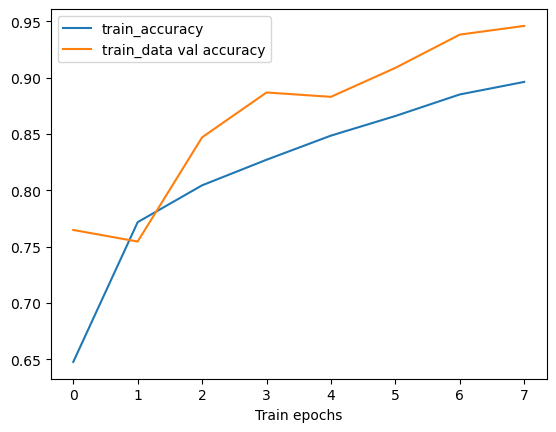

29/29 [==============================] - 0s 269us/step


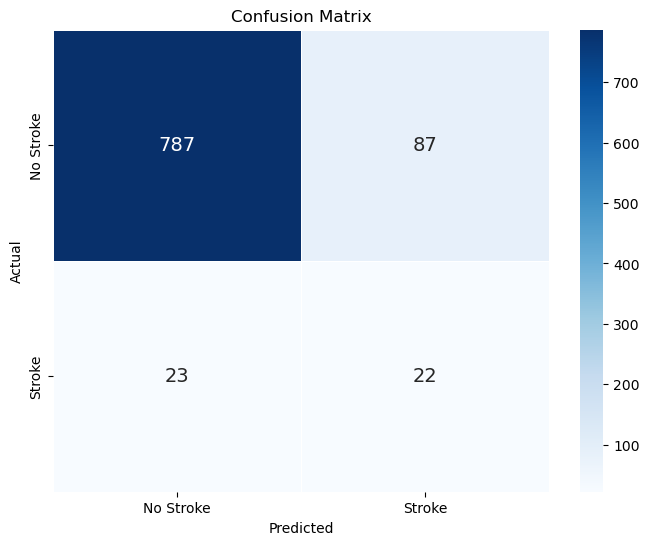

[I 2023-12-10 19:24:38,522] Trial 64 finished with value: 0.6101968103155752 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.023752129765199616, 'num_epochs': 8}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


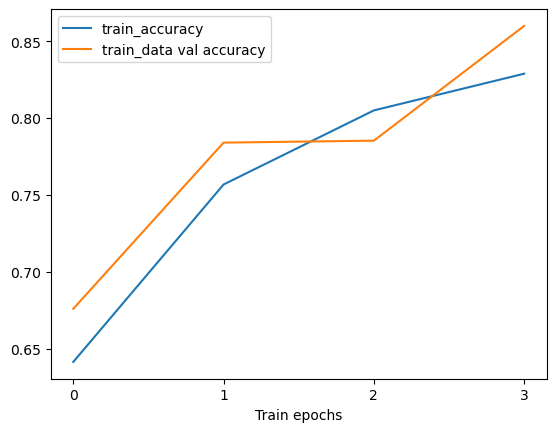

29/29 [==============================] - 0s 253us/step


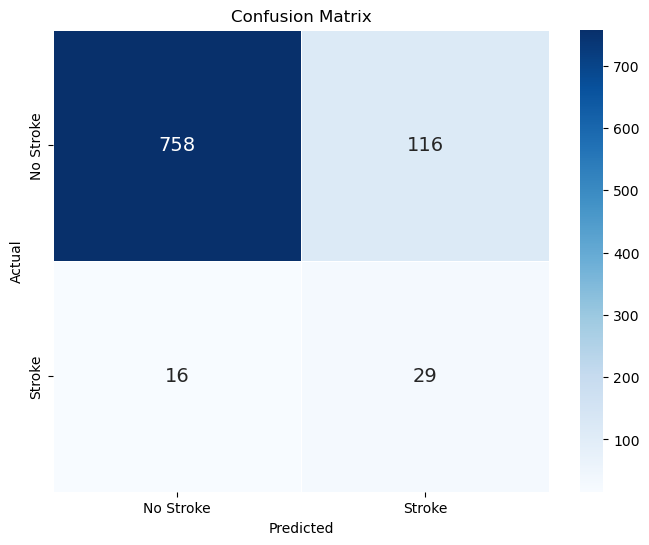

[I 2023-12-10 19:24:39,113] Trial 65 finished with value: 0.612583035258048 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.028598178991589236, 'num_epochs': 4}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


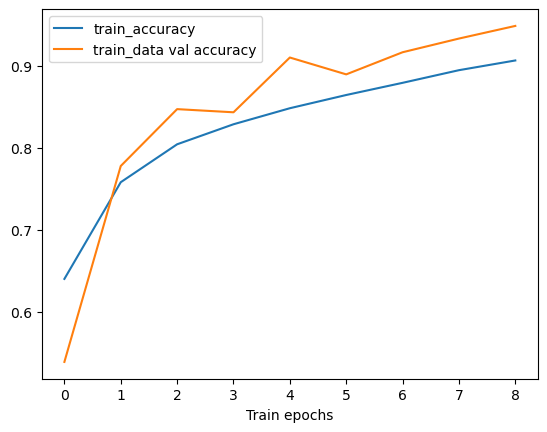

29/29 [==============================] - 0s 257us/step


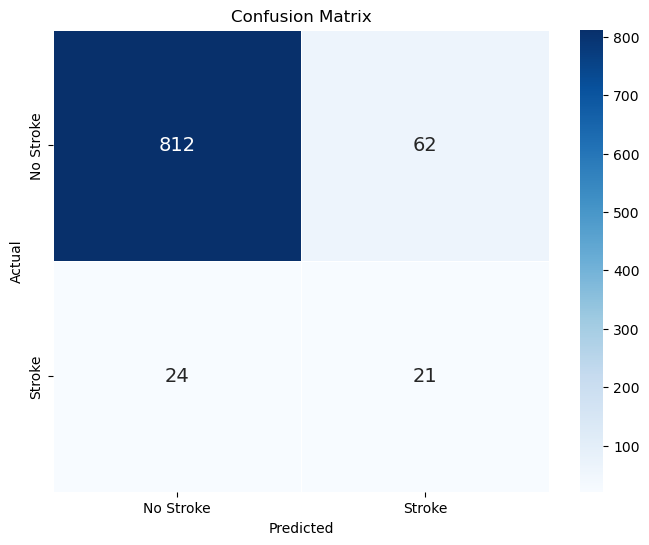

[I 2023-12-10 19:24:39,939] Trial 66 finished with value: 0.6389163011695906 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.030878510666623355, 'num_epochs': 9}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


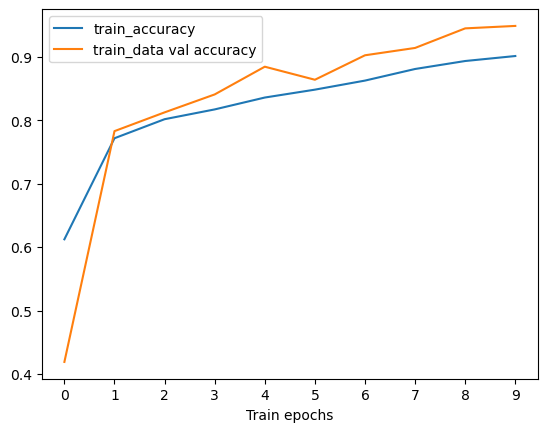

29/29 [==============================] - 0s 241us/step


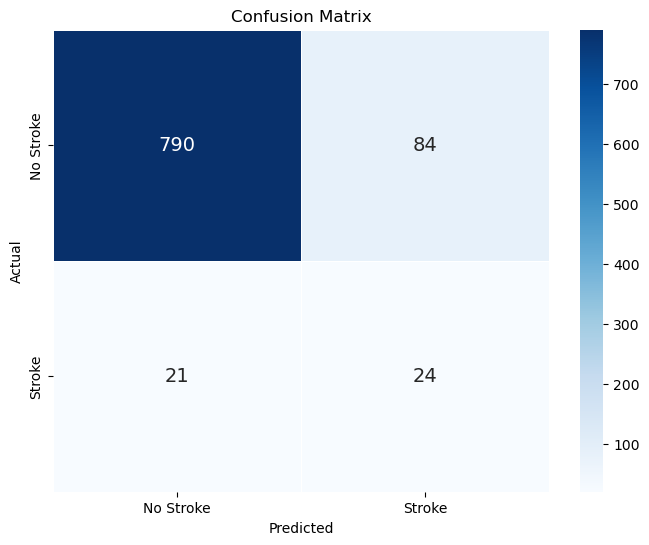

[I 2023-12-10 19:24:40,806] Trial 67 finished with value: 0.6257054750683656 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.04066291591011265, 'num_epochs': 10}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


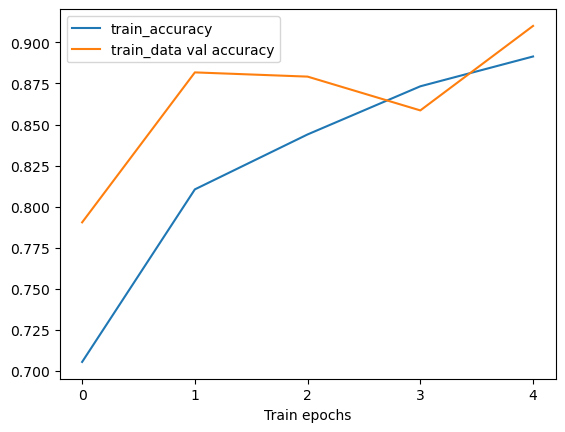

29/29 [==============================] - 0s 266us/step


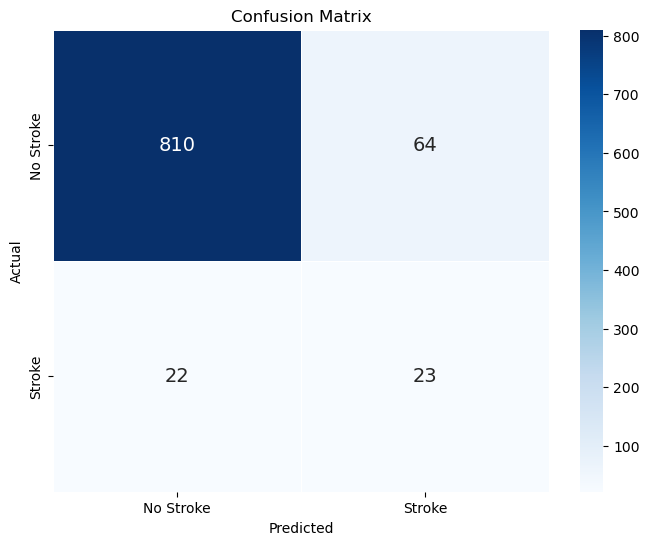

[I 2023-12-10 19:24:41,533] Trial 68 finished with value: 0.649037265977477 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02186984681026323, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


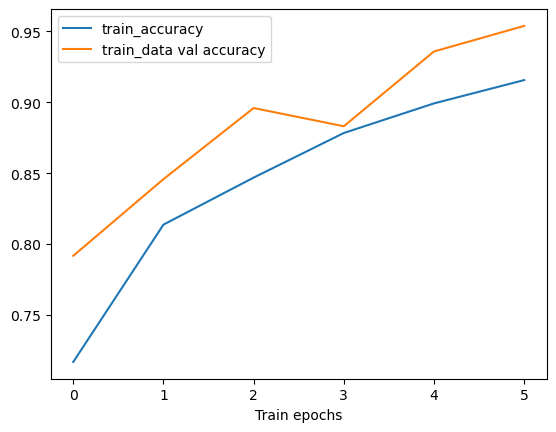

29/29 [==============================] - 0s 287us/step


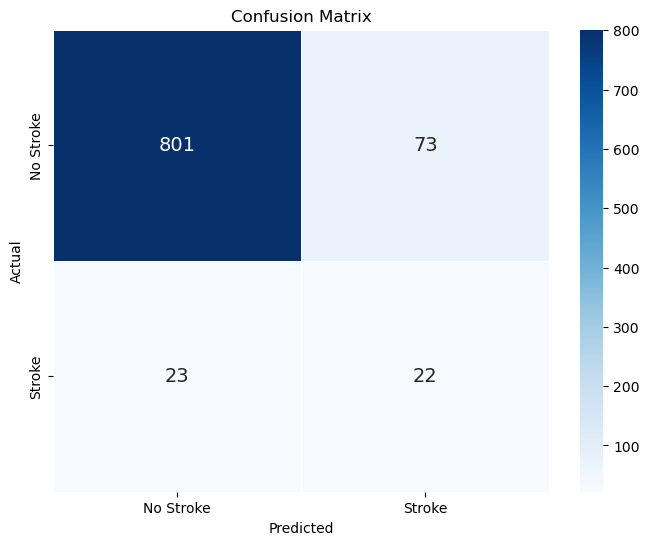

[I 2023-12-10 19:24:42,300] Trial 69 finished with value: 0.628874305906108 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02136614388188868, 'num_epochs': 6}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


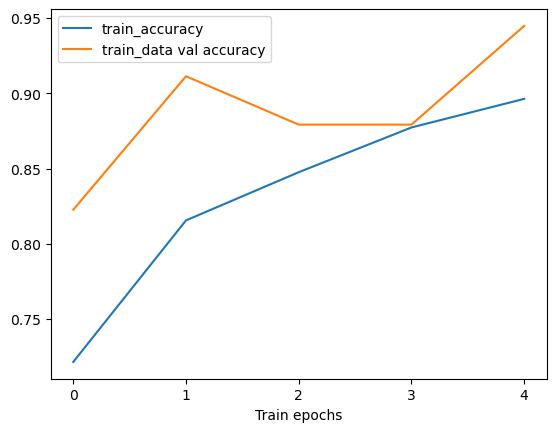

29/29 [==============================] - 0s 293us/step


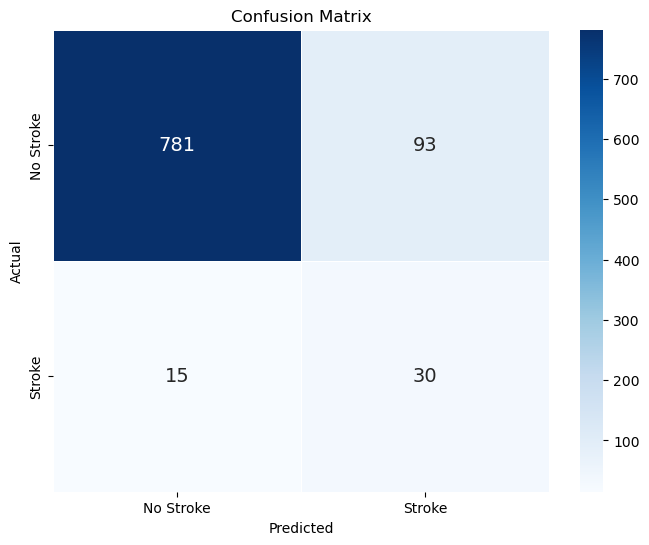

[I 2023-12-10 19:24:43,004] Trial 70 finished with value: 0.6462360992301112 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025256443813861496, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


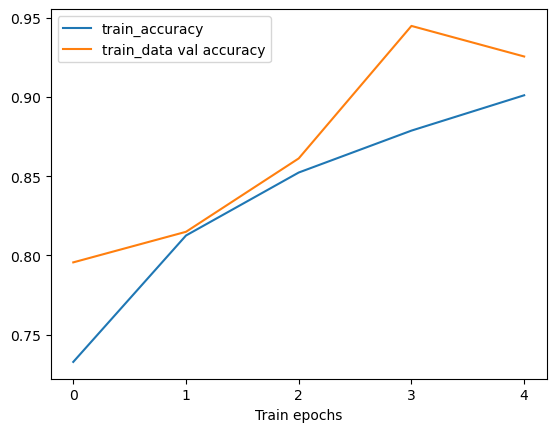

29/29 [==============================] - 0s 288us/step


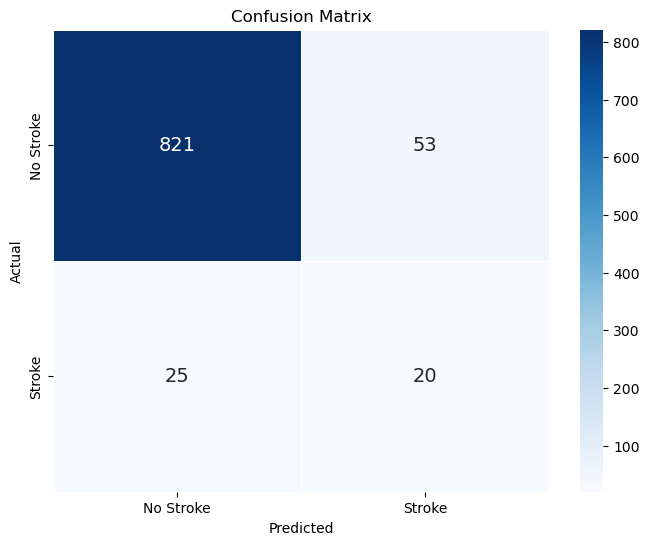

[I 2023-12-10 19:24:43,866] Trial 71 finished with value: 0.6468171068190777 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025287301123212008, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


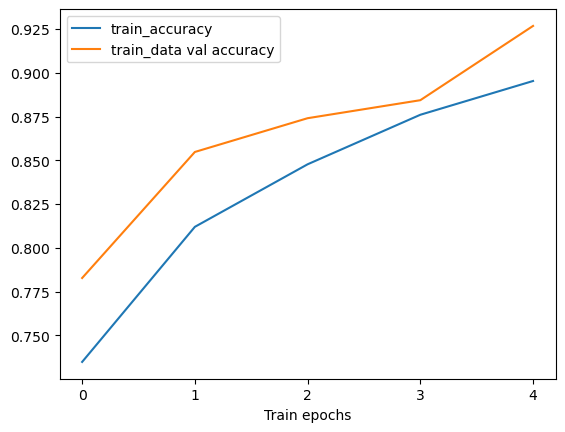

29/29 [==============================] - 0s 279us/step


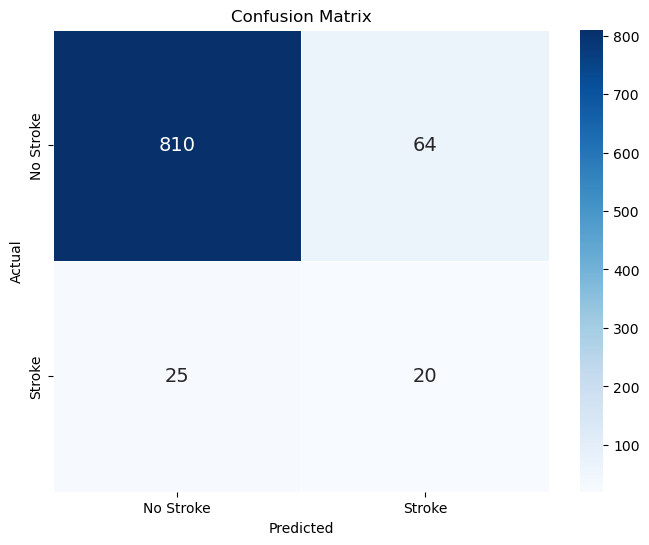

[I 2023-12-10 19:24:44,560] Trial 72 finished with value: 0.6290001406144398 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02436276126365078, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


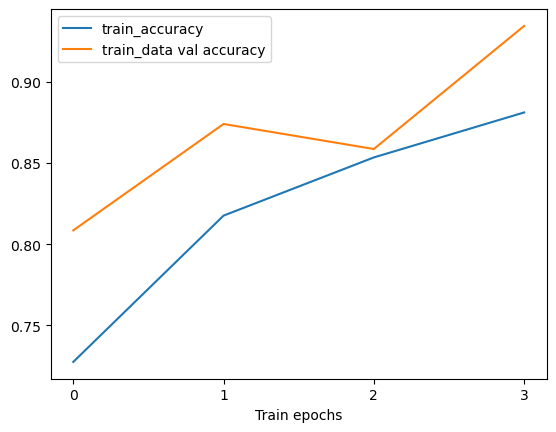

29/29 [==============================] - 0s 265us/step


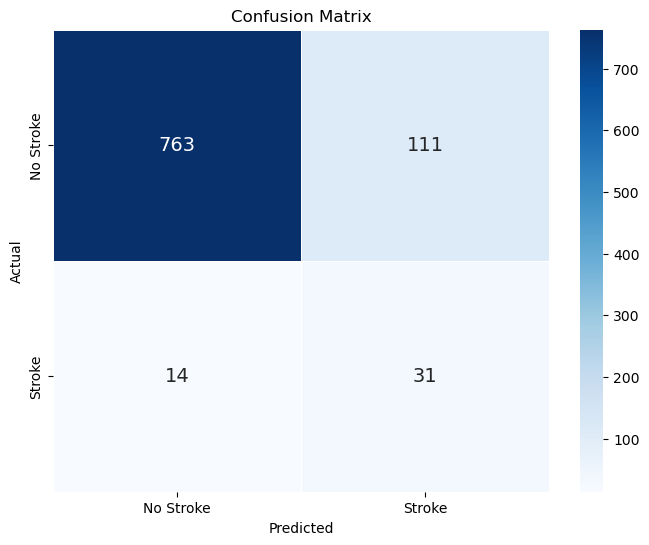

[I 2023-12-10 19:24:45,186] Trial 73 finished with value: 0.6279195561270596 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025987352808835674, 'num_epochs': 4}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


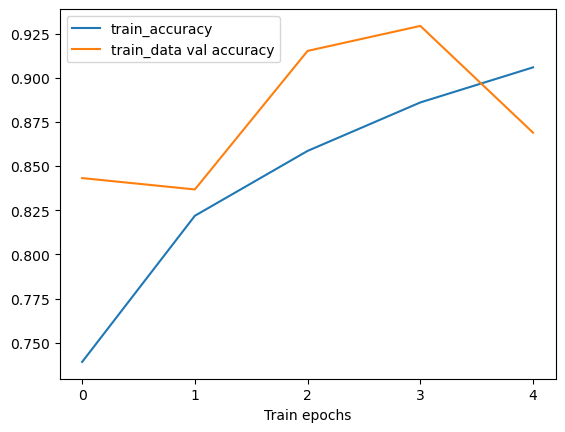

29/29 [==============================] - 0s 275us/step


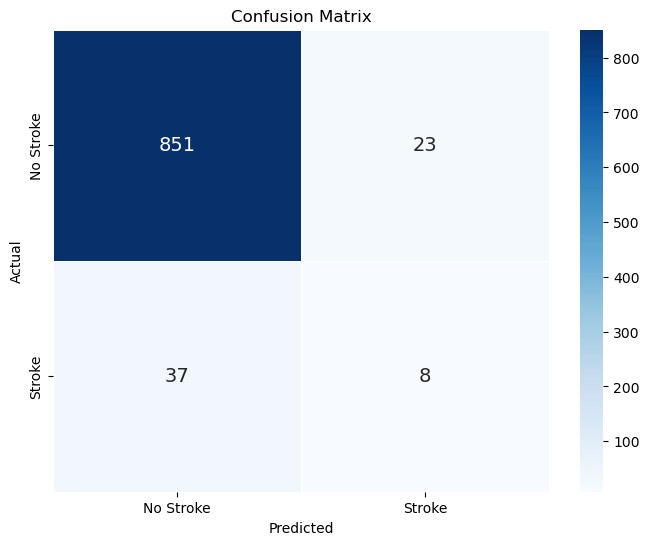

[I 2023-12-10 19:24:45,894] Trial 74 finished with value: 0.5882370511978016 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.028251554181671867, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


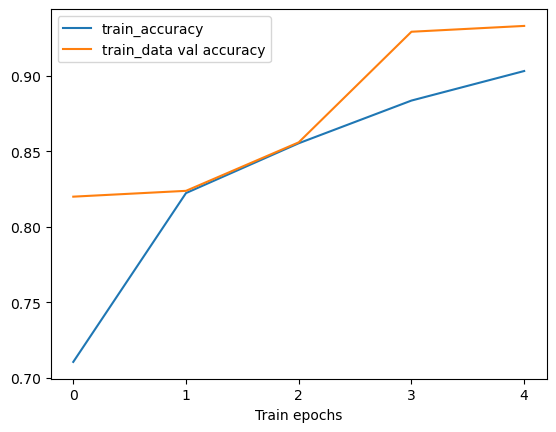

29/29 [==============================] - 0s 287us/step


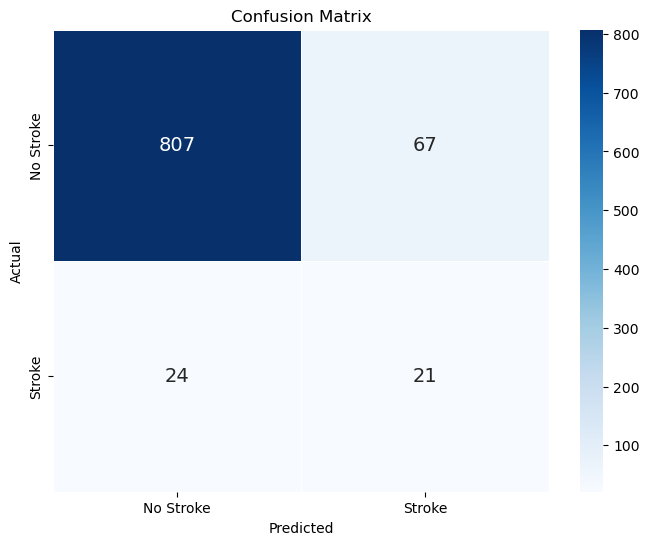

[I 2023-12-10 19:24:46,589] Trial 75 finished with value: 0.6312085198333076 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01918271332589258, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


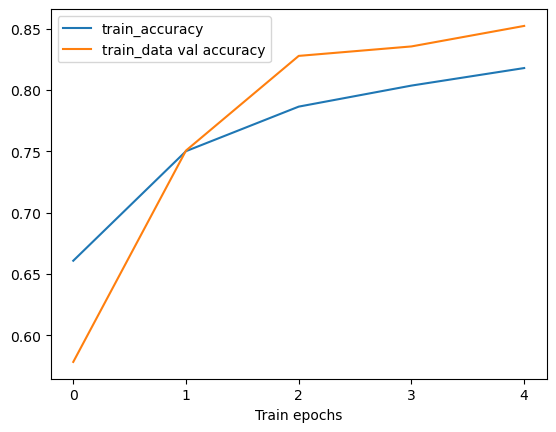

29/29 [==============================] - 0s 287us/step


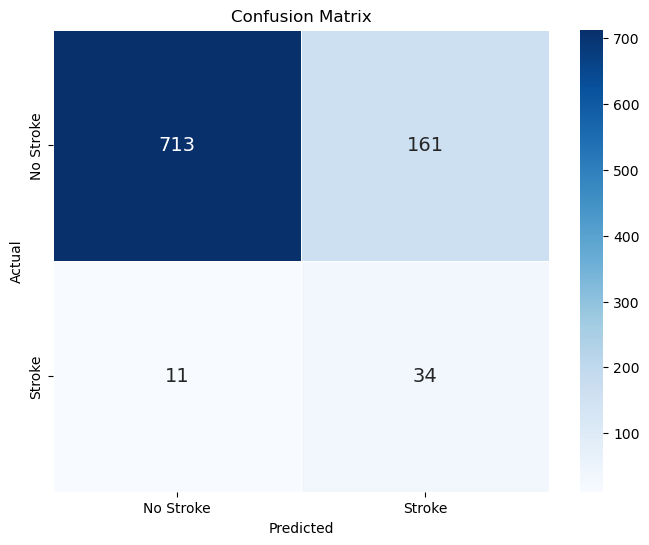

[I 2023-12-10 19:24:47,198] Trial 76 finished with value: 0.5878493950771798 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.02479285928482199, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


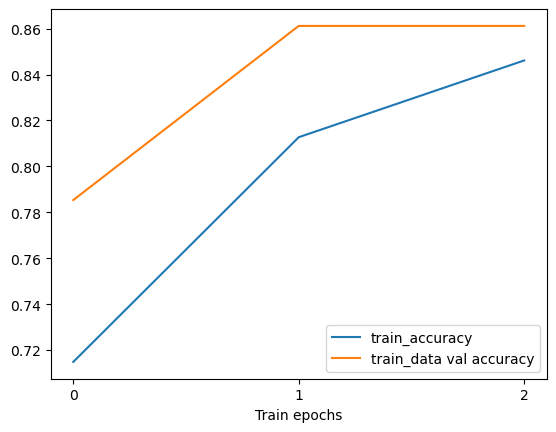

29/29 [==============================] - 0s 269us/step


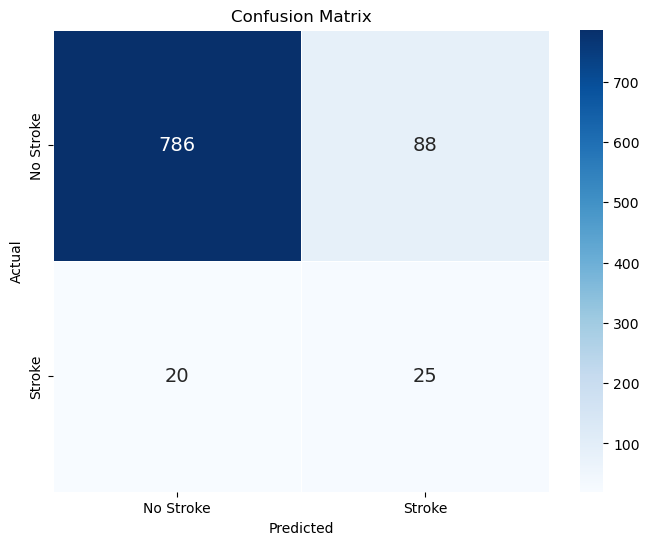

[I 2023-12-10 19:24:47,771] Trial 77 finished with value: 0.6260849909584087 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02175505234052814, 'num_epochs': 3}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


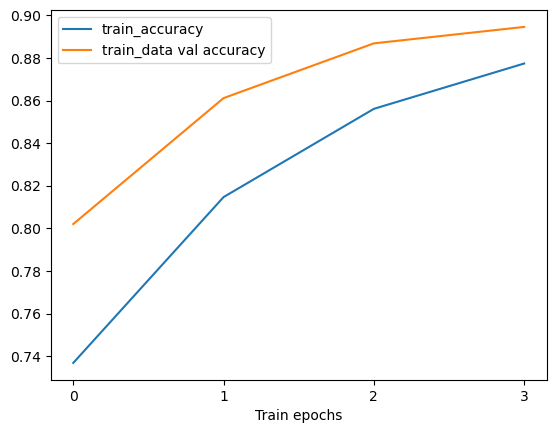

29/29 [==============================] - 0s 297us/step


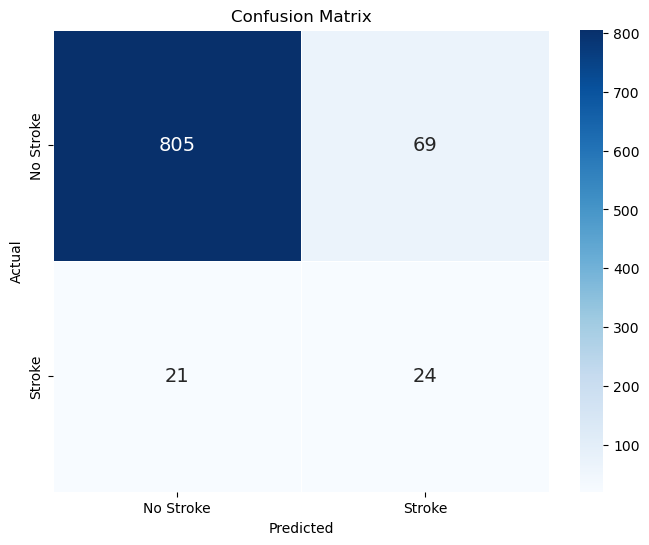

[I 2023-12-10 19:24:48,436] Trial 78 finished with value: 0.6474424552429667 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.027462827331854952, 'num_epochs': 4}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


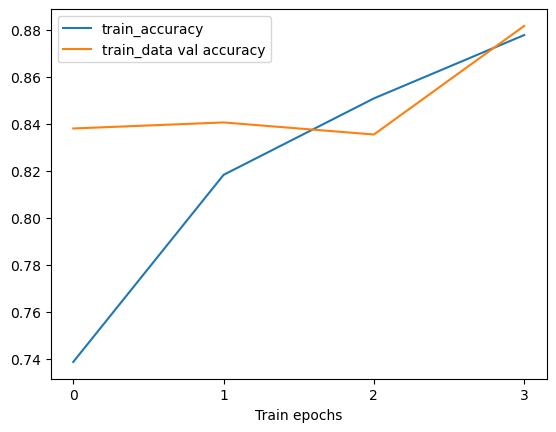

29/29 [==============================] - 0s 273us/step


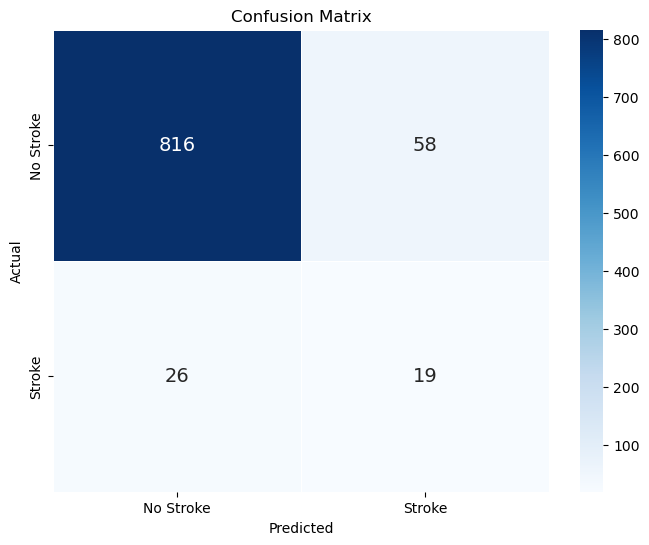

[I 2023-12-10 19:24:49,101] Trial 79 finished with value: 0.6312621804425083 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02732117941470413, 'num_epochs': 4}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


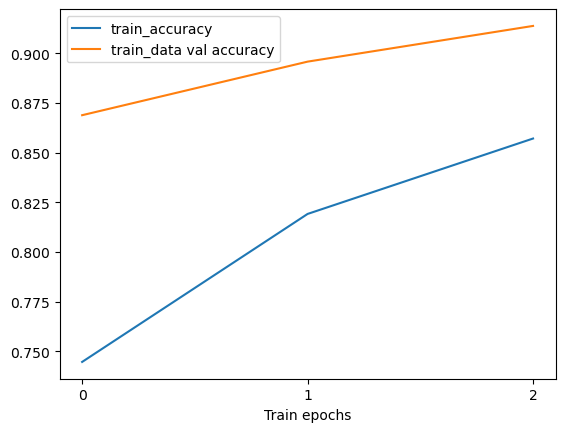

29/29 [==============================] - 0s 266us/step


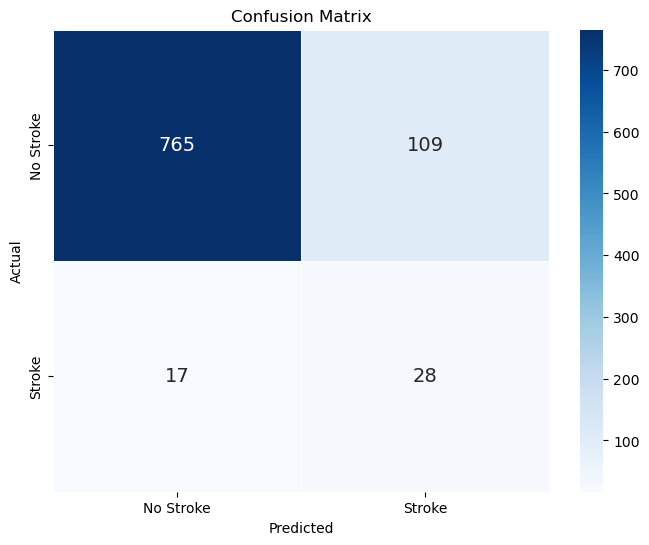

[I 2023-12-10 19:24:49,683] Trial 80 finished with value: 0.6158026755852842 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.03025034488935629, 'num_epochs': 3}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


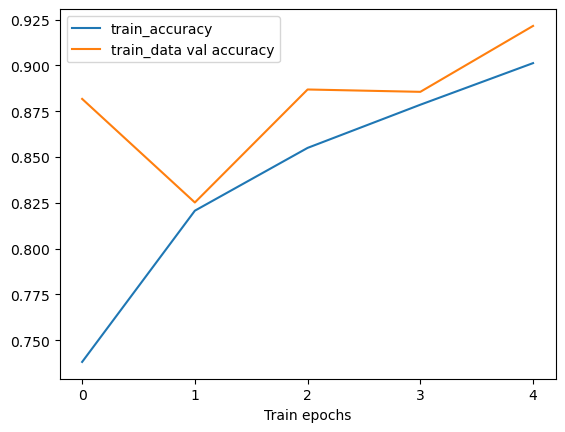

29/29 [==============================] - 0s 268us/step


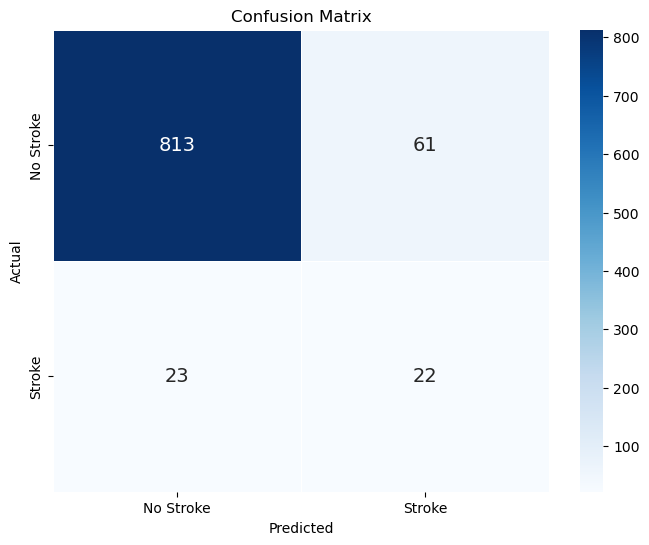

[I 2023-12-10 19:24:50,380] Trial 81 finished with value: 0.6473135964912281 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02565392418685117, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


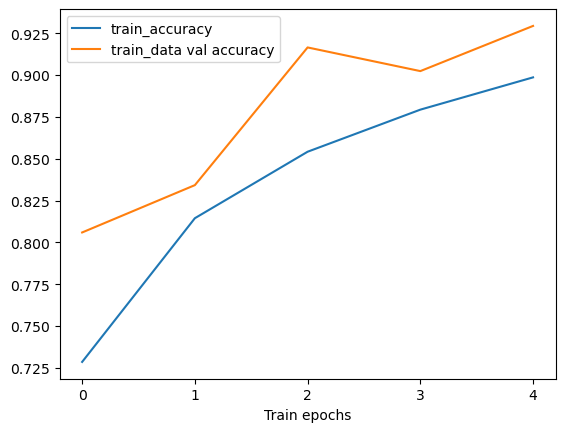

29/29 [==============================] - 0s 249us/step


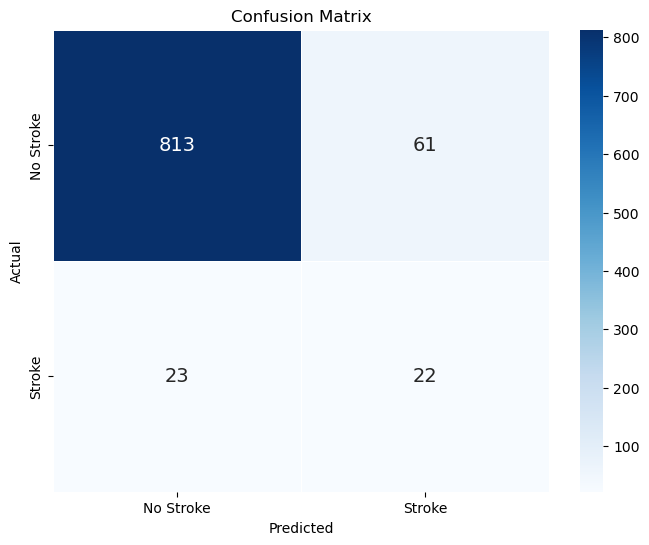

[I 2023-12-10 19:24:51,085] Trial 82 finished with value: 0.6473135964912281 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.022775313265461932, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


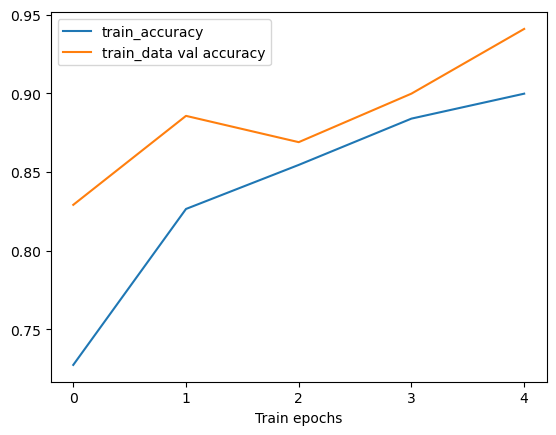

29/29 [==============================] - 0s 282us/step


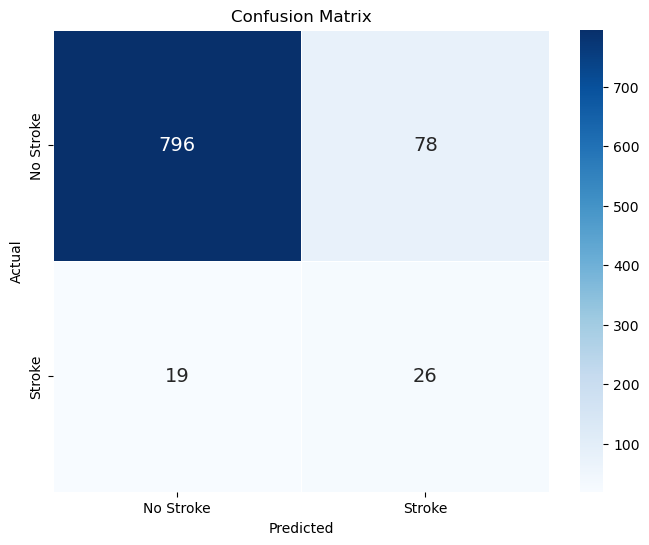

[I 2023-12-10 19:24:51,952] Trial 83 finished with value: 0.6457814281910983 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.023807587779411873, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


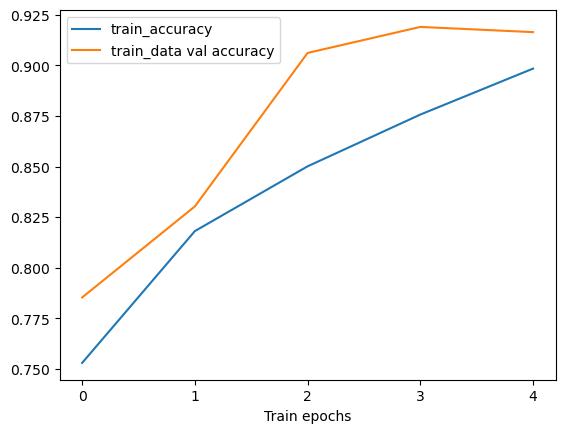

29/29 [==============================] - 0s 261us/step


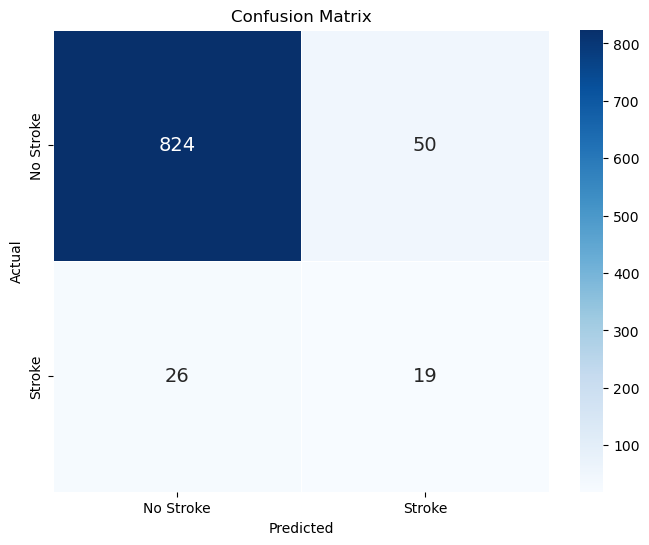

[I 2023-12-10 19:24:52,636] Trial 84 finished with value: 0.6446249033255993 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.023101098984940813, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


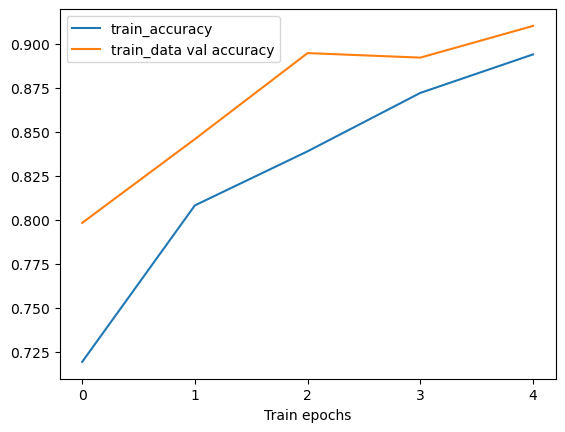

29/29 [==============================] - 0s 263us/step


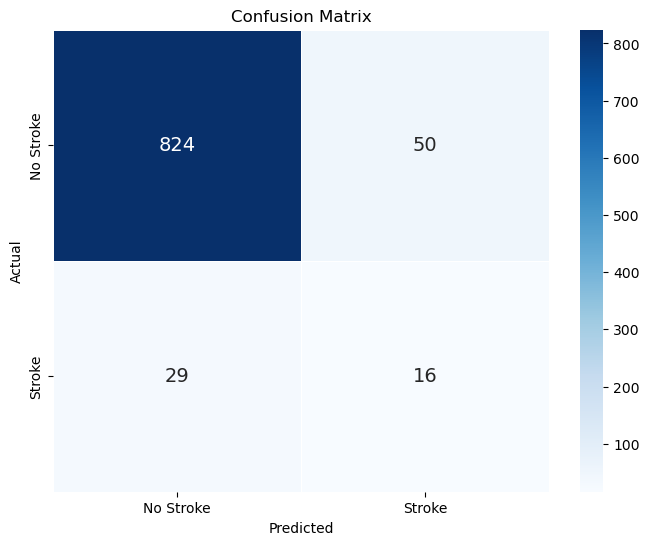

[I 2023-12-10 19:24:53,330] Trial 85 finished with value: 0.6212721117179716 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0233043418995476, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


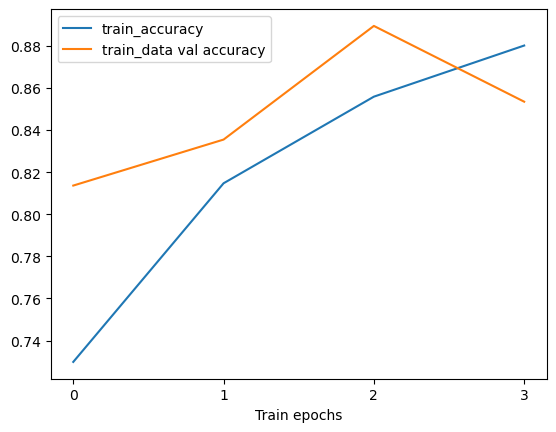

29/29 [==============================] - 0s 254us/step


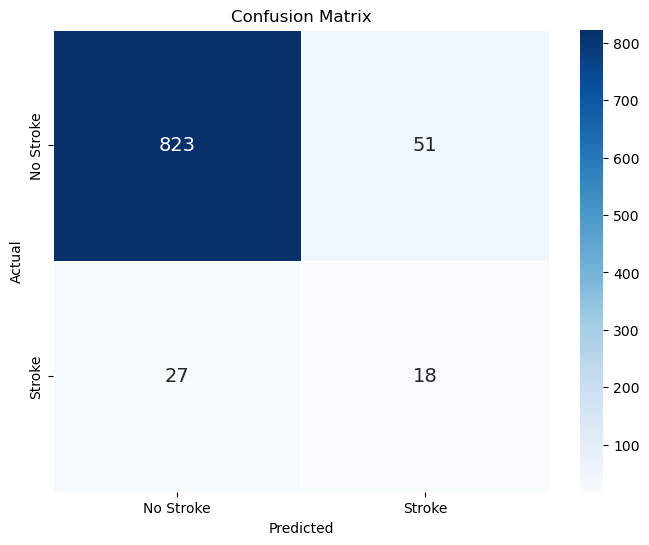

[I 2023-12-10 19:24:53,974] Trial 86 finished with value: 0.6352729270973257 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02097285409149444, 'num_epochs': 4}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


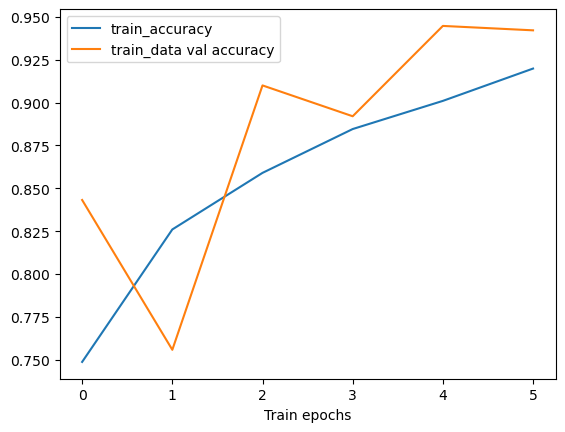

29/29 [==============================] - 0s 270us/step


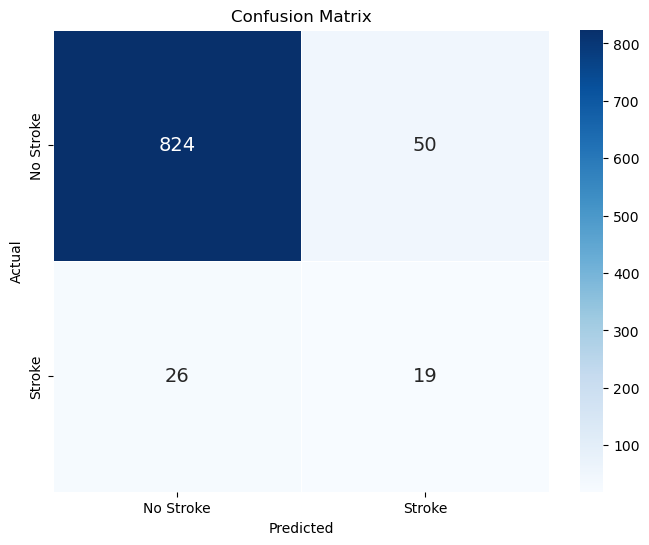

[I 2023-12-10 19:24:54,725] Trial 87 finished with value: 0.6446249033255993 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0230909483297004, 'num_epochs': 6}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


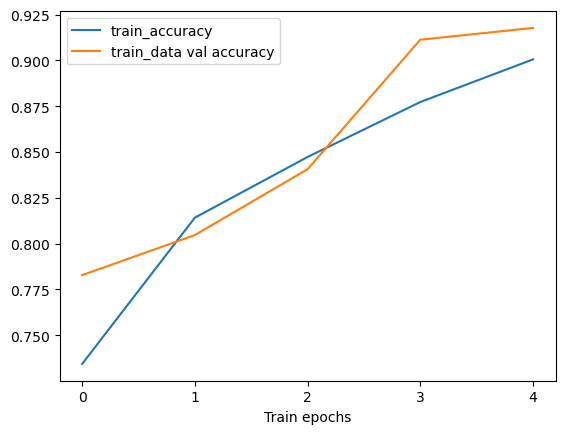

29/29 [==============================] - 0s 280us/step


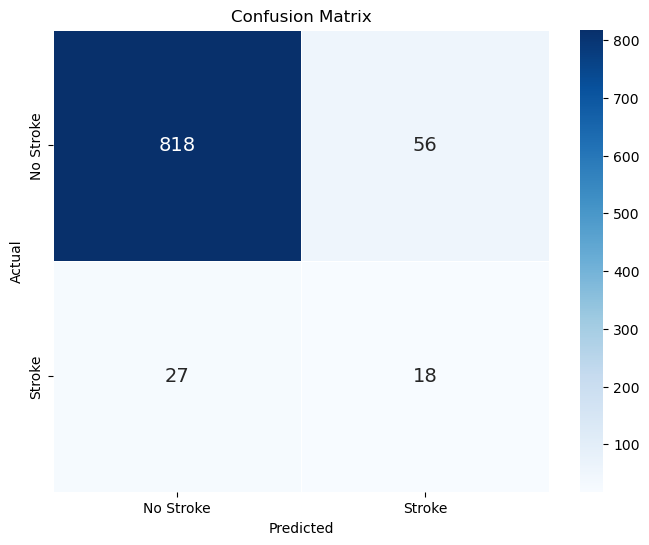

[I 2023-12-10 19:24:55,424] Trial 88 finished with value: 0.6271185612115702 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025092465714618373, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


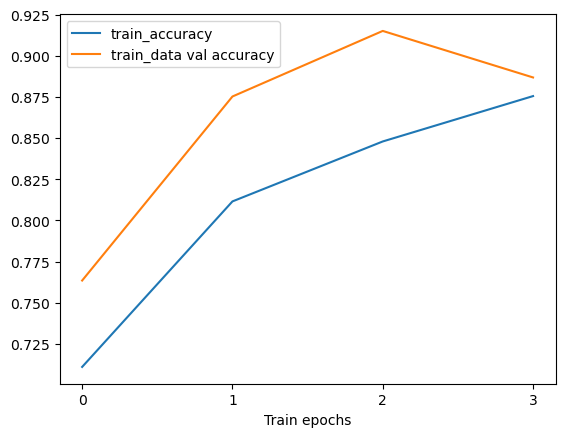

29/29 [==============================] - 0s 263us/step


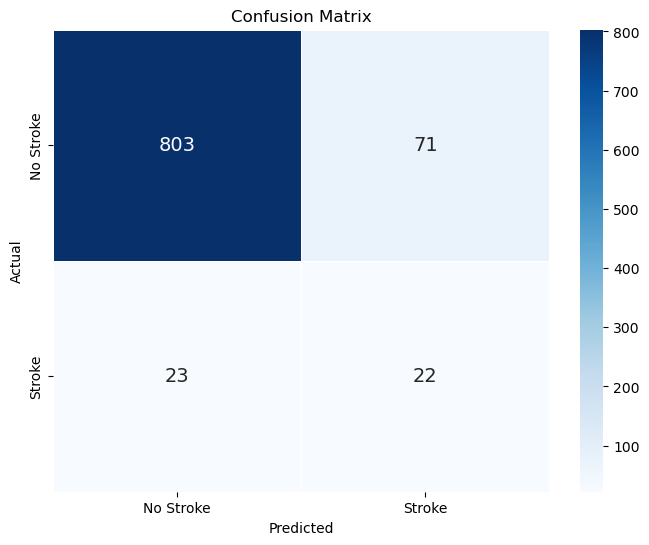

[I 2023-12-10 19:24:56,071] Trial 89 finished with value: 0.631773231031543 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02298987415543904, 'num_epochs': 4}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


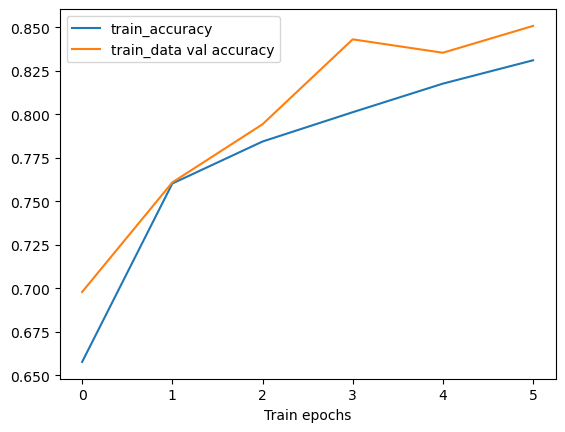

29/29 [==============================] - 0s 260us/step


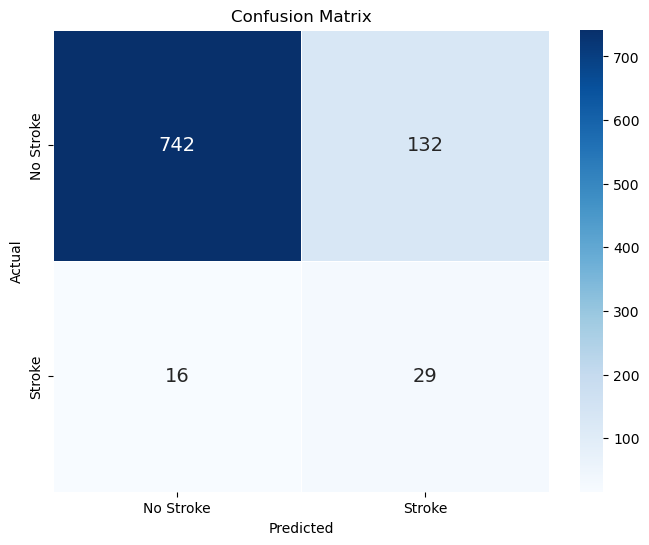

[I 2023-12-10 19:24:56,737] Trial 90 finished with value: 0.5954335617742244 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.02765118219219417, 'num_epochs': 6}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


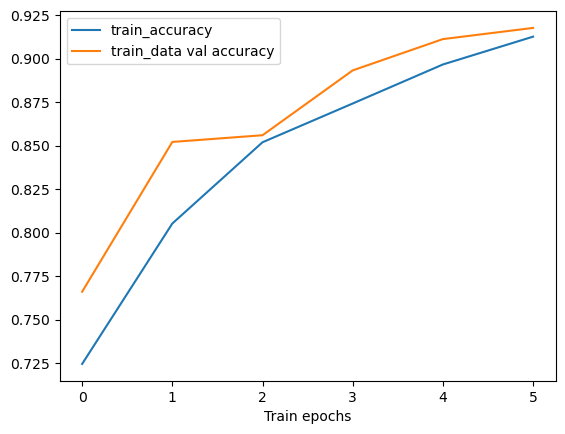

29/29 [==============================] - 0s 254us/step


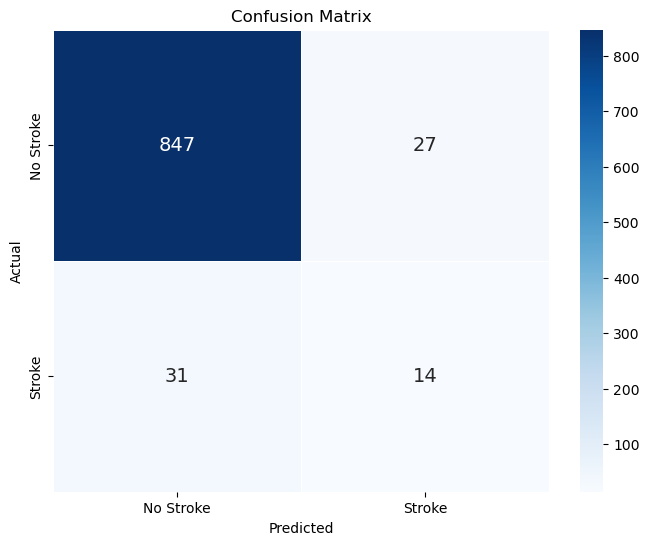

[I 2023-12-10 19:24:57,484] Trial 91 finished with value: 0.6462381862588935 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.023270352579064155, 'num_epochs': 6}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


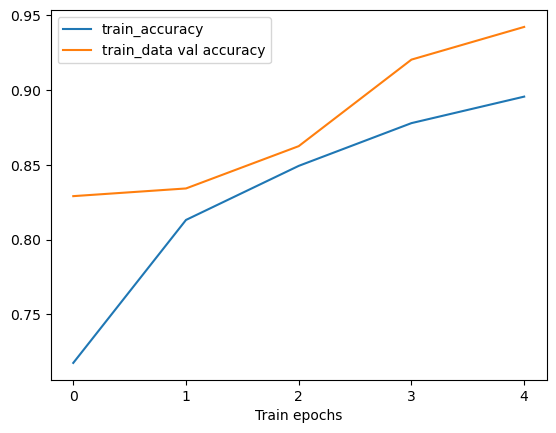

29/29 [==============================] - 0s 262us/step


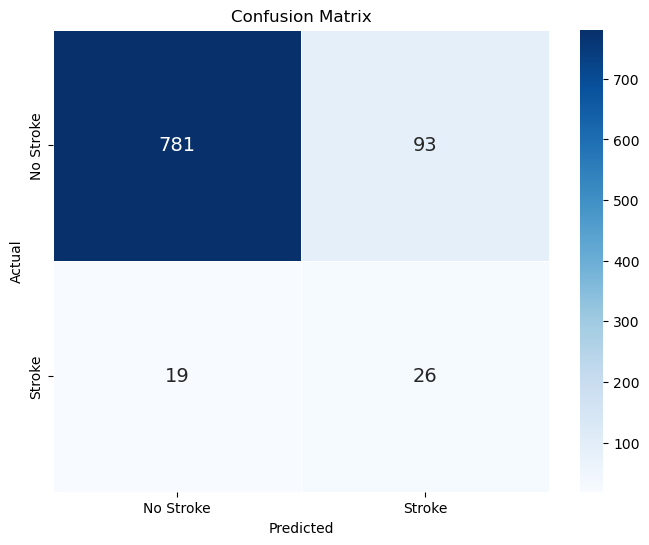

[I 2023-12-10 19:24:58,171] Trial 92 finished with value: 0.6250837777194976 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.021802843154099385, 'num_epochs': 5}. Best is trial 47 with value: 0.6505484773076239.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


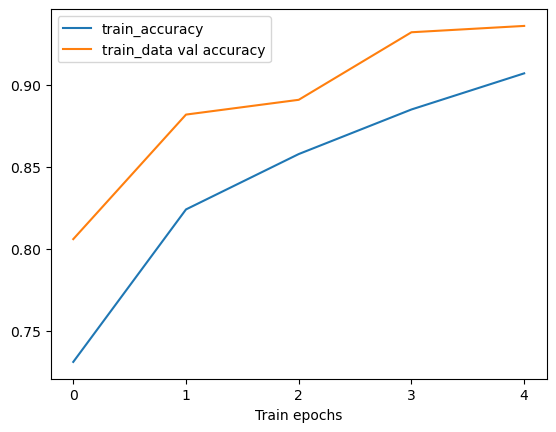

29/29 [==============================] - 0s 249us/step


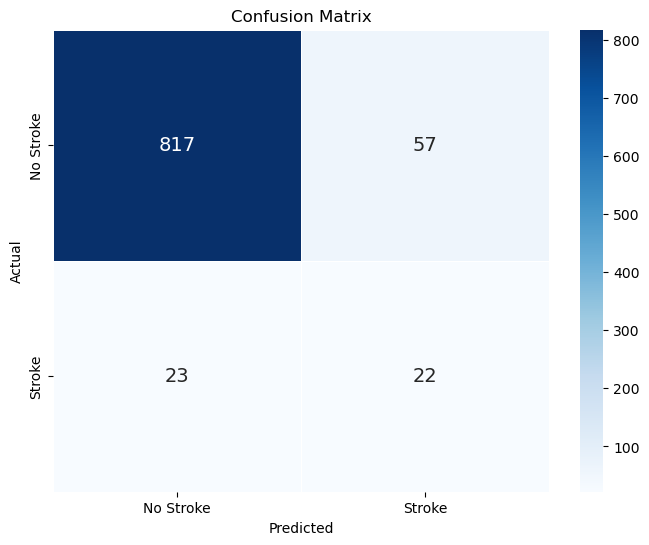

[I 2023-12-10 19:24:58,867] Trial 93 finished with value: 0.6540821319682313 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025342599583490992, 'num_epochs': 5}. Best is trial 93 with value: 0.6540821319682313.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


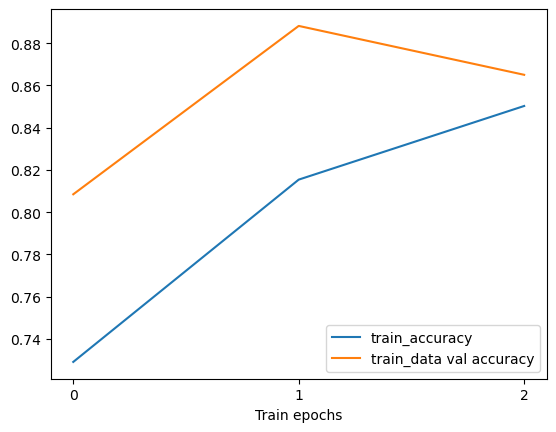

29/29 [==============================] - 0s 278us/step


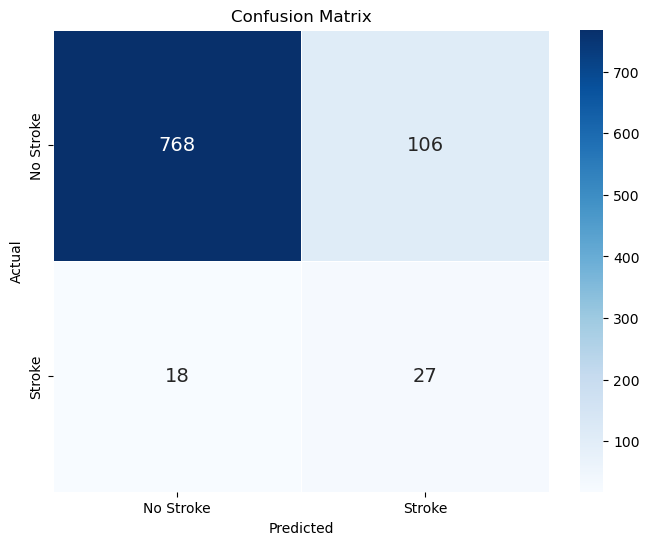

[I 2023-12-10 19:24:59,668] Trial 94 finished with value: 0.6143359956680654 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025617391014407714, 'num_epochs': 3}. Best is trial 93 with value: 0.6540821319682313.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


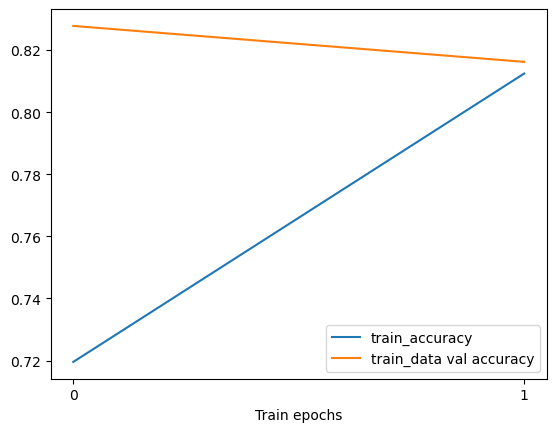

29/29 [==============================] - 0s 302us/step


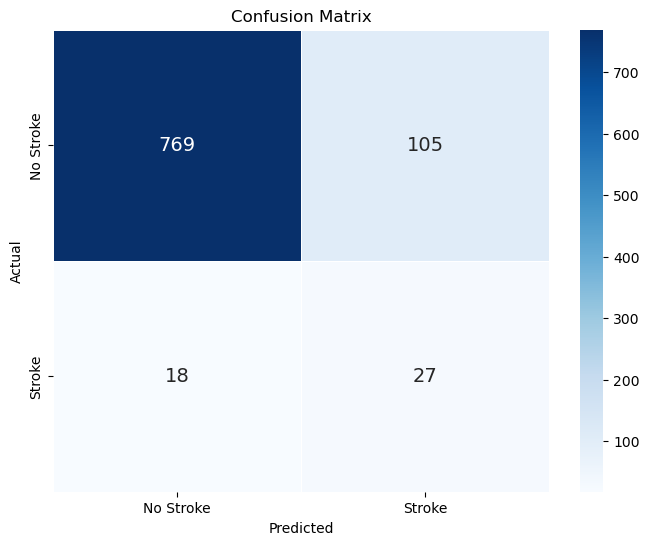

[I 2023-12-10 19:25:00,208] Trial 95 finished with value: 0.6155164848620904 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.024056962242944305, 'num_epochs': 2}. Best is trial 93 with value: 0.6540821319682313.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


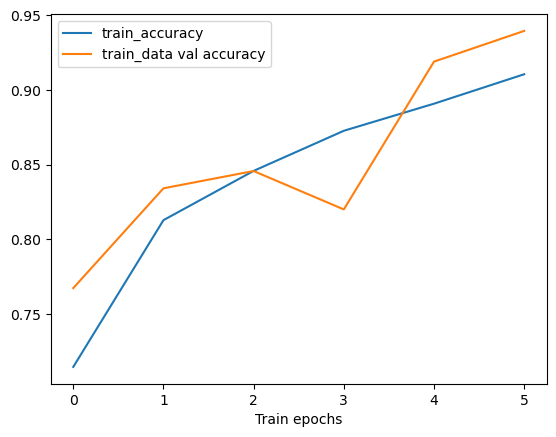

29/29 [==============================] - 0s 325us/step


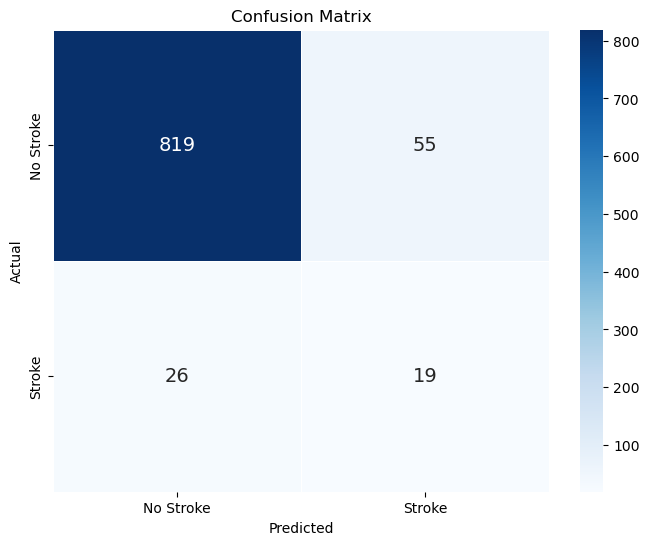

[I 2023-12-10 19:25:00,982] Trial 96 finished with value: 0.6361036561221347 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02058869539677918, 'num_epochs': 6}. Best is trial 93 with value: 0.6540821319682313.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


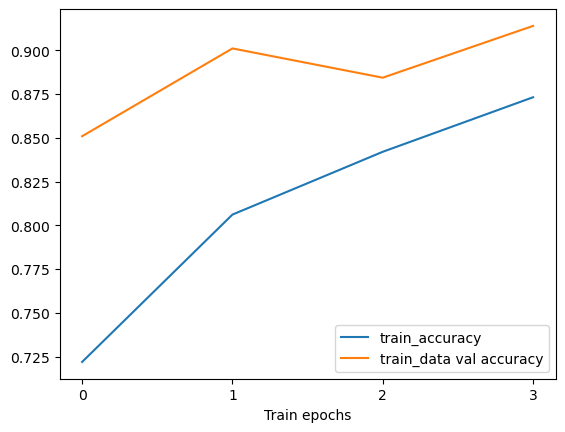

29/29 [==============================] - 0s 264us/step


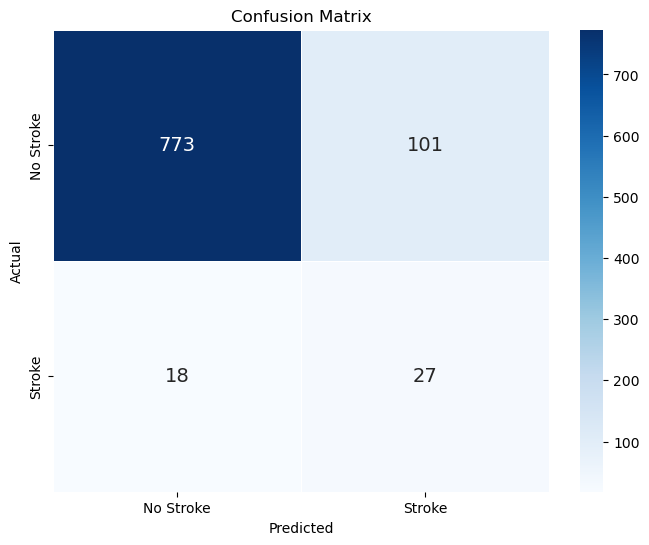

[I 2023-12-10 19:25:01,632] Trial 97 finished with value: 0.6203336284261141 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0263604059563946, 'num_epochs': 4}. Best is trial 93 with value: 0.6540821319682313.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


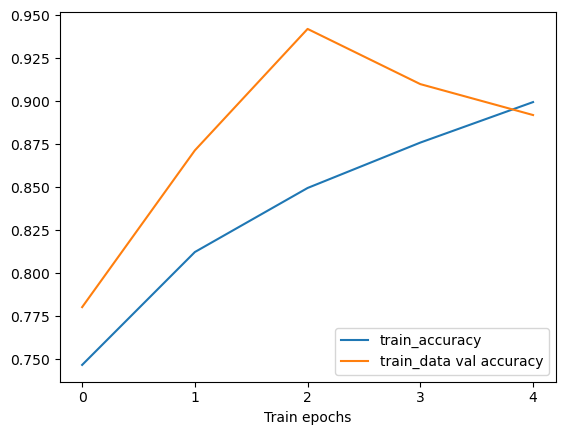

29/29 [==============================] - 0s 260us/step


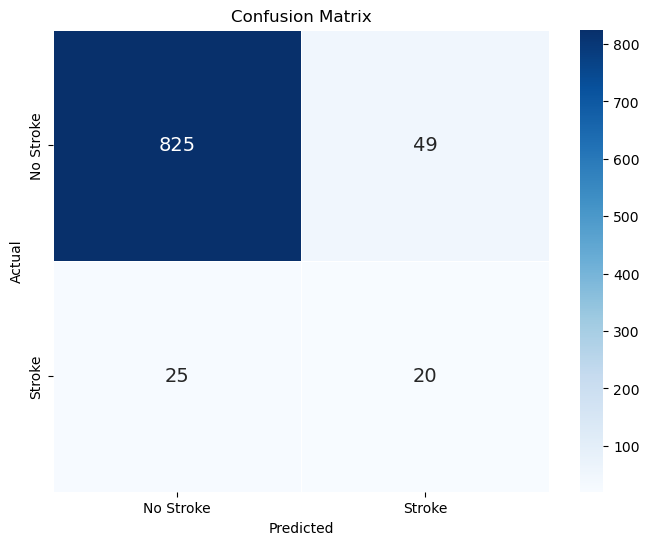

[I 2023-12-10 19:25:02,331] Trial 98 finished with value: 0.6539768795538731 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.02480218725266523, 'num_epochs': 5}. Best is trial 93 with value: 0.6540821319682313.
/Users/snehaldesai/anaconda3/envs/tf/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [1, 97].
  warnings.warn(


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


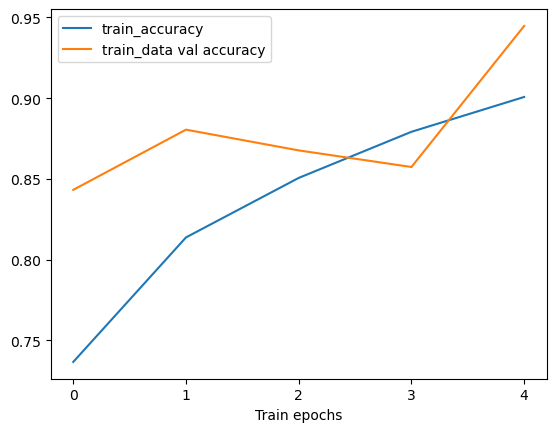

29/29 [==============================] - 0s 247us/step


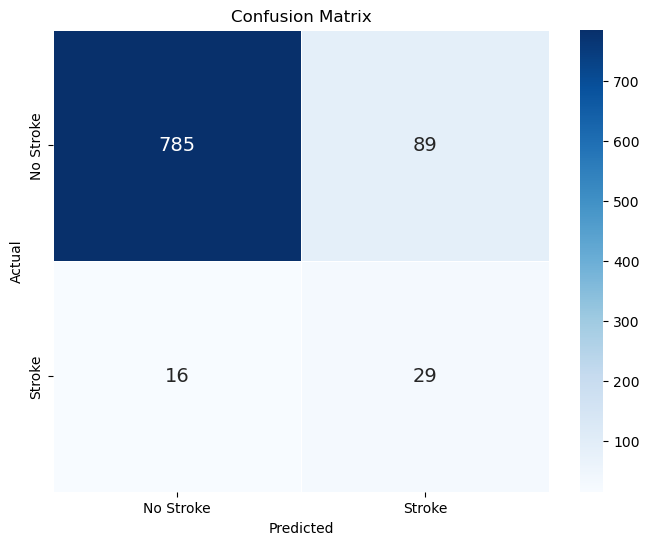

[I 2023-12-10 19:25:03,019] Trial 99 finished with value: 0.6465708268473582 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.028200237271863073, 'num_epochs': 5}. Best is trial 93 with value: 0.6540821319682313.


In [28]:
# Optuna hyperparameters

def func(trial):
    hidden_layer_sizes = trial.suggest_int('units_layer', 1, 128, 32)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)
    num_epochs = trial.suggest_int('num_epochs', 1, 10)
    
    result = train_and_evaluate_for_optuna(hidden_layer_sizes=[hidden_layer_sizes],
                                activation=activation,
                                optimizer=optimizer,
                                learning_rate=learning_rate,
                                num_epochs=num_epochs)
    
    # return result['validation_recall']
    return result['validation_F1_score']
    # return result['validation_precision']
    # return result['validation_pr_auc']

study = optuna.create_study(direction='maximize')
study.optimize(func, n_trials = 100)

In [29]:
print(study.best_params)

{'units_layer': 97, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.025342599583490992, 'num_epochs': 5}


/var/folders/qm/5x5v0r_s4l7f_wq7ssk3m7pw0000gn/T/ipykernel_67328/1891259598.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/var/folders/qm/5x5v0r_s4l7f_wq7ssk3m7pw0000gn/T/ipykernel_67328/1891259598.py:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")
/var/folders/qm/5x5v0r_s4l7f_wq7ssk3m7pw0000gn/T/ipykernel_67328/1891259598.py:6: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(study)
[W 2023-12-10 19:25:03,440] You need to set up the pruning feature to utilize `plot_intermediate_values()`
/

<Axes: title={'center': 'Timeline Plot'}, xlabel='Datetime', ylabel='Trial'>

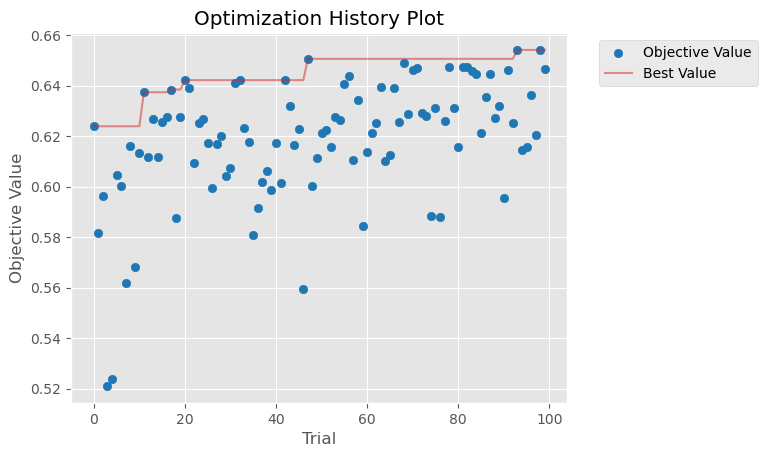

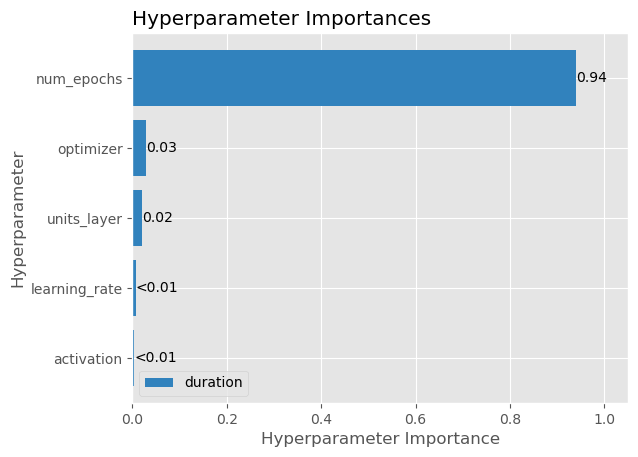

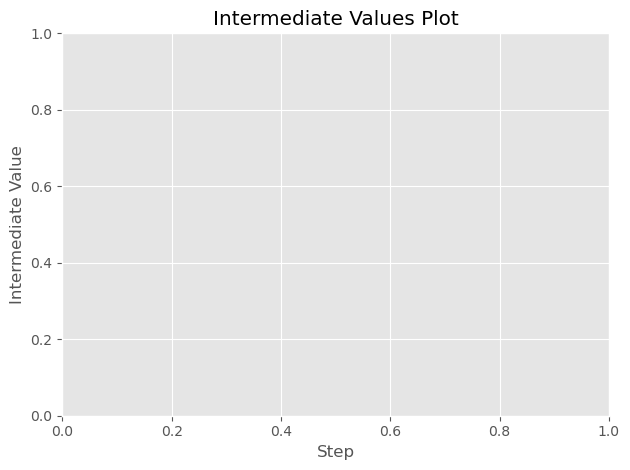

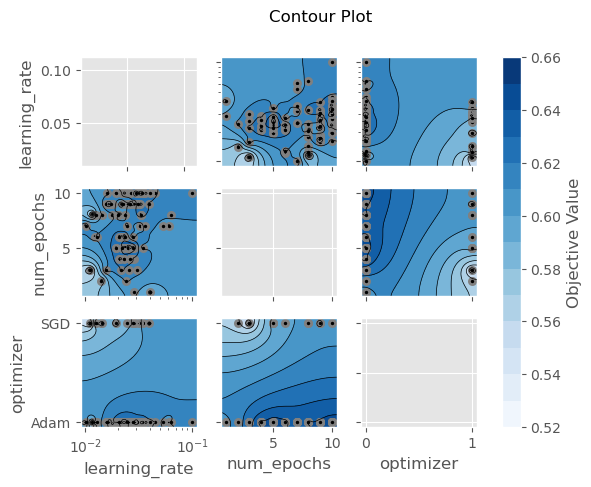

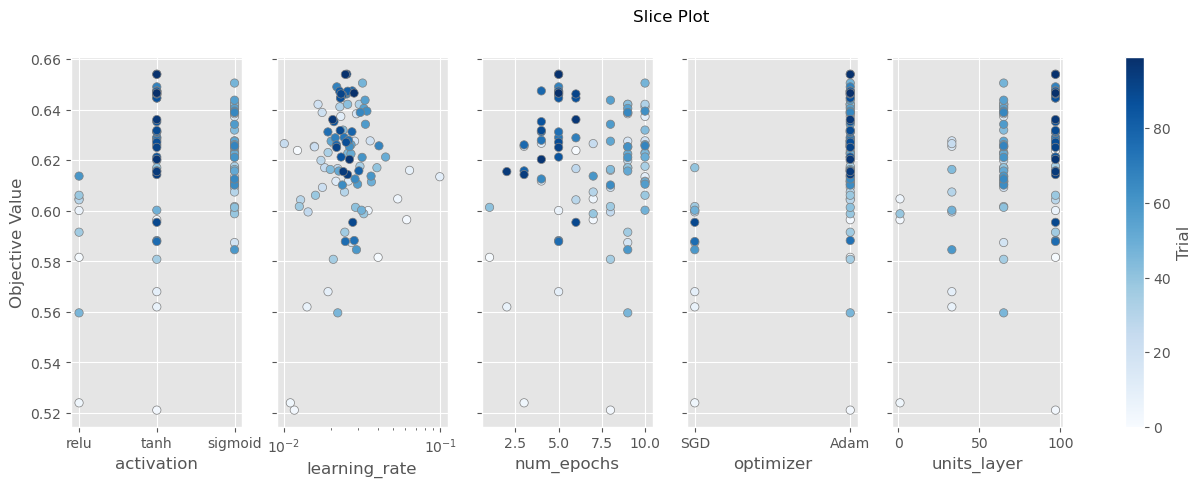

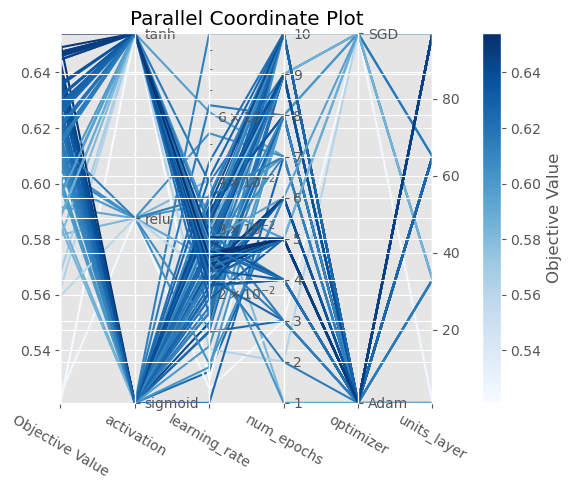

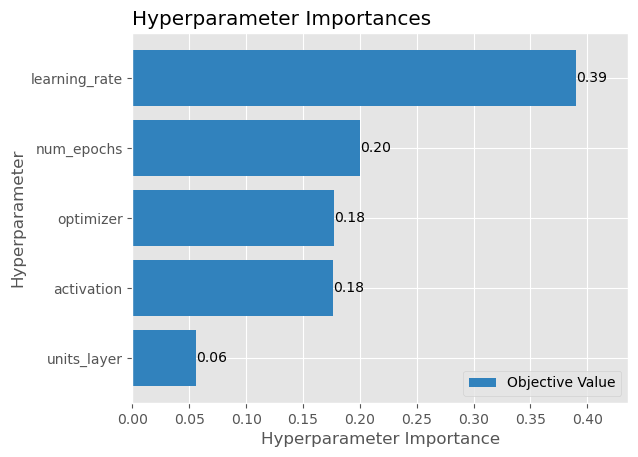

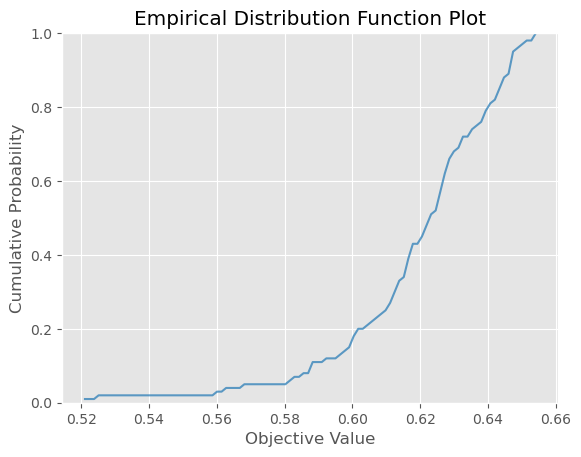

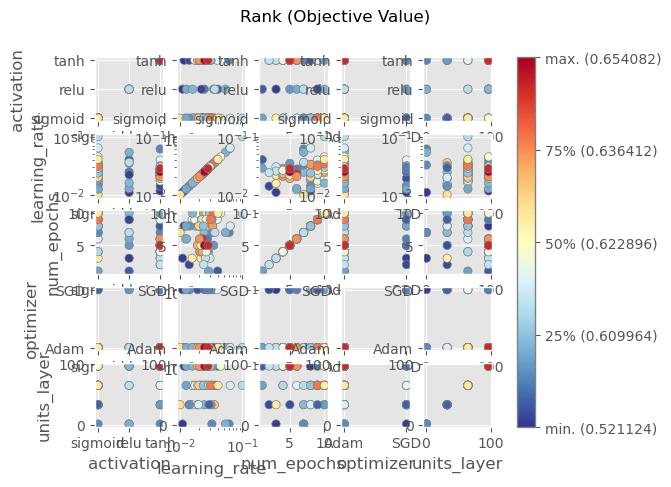

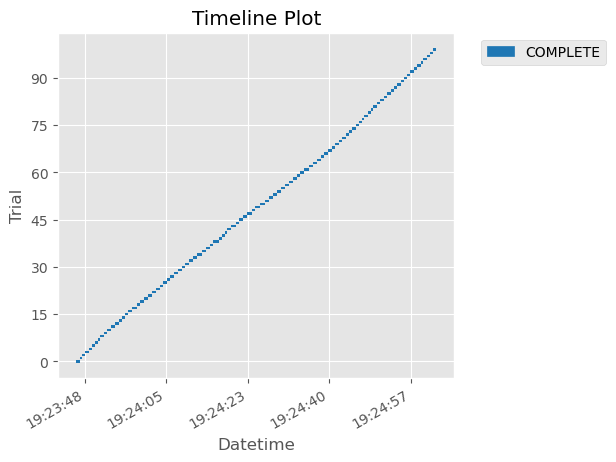

In [30]:

# Visualize the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.matplotlib.plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")
# Visualize the learning curves of the trials
optuna.visualization.matplotlib.plot_intermediate_values(study)
# Visualize hyperparameter relationships - this one is awesome
optuna.visualization.matplotlib.plot_contour(study, params = ['num_epochs', 'learning_rate', 'optimizer'])
# Visualize individual hyperparameters as slice plot
optuna.visualization.matplotlib.plot_slice(study)
# Visualize high-dimensional parameter relationships
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
# Visualize parameter importances
optuna.visualization.matplotlib.plot_param_importances(study)
# Visualize empirical distribution function
optuna.visualization.matplotlib.plot_edf(study)
# Visualize parameter relations with scatter plots colored by objective values
optuna.visualization.matplotlib.plot_rank(study)
# Visualize the optimization timeline of performed trials
optuna.visualization.matplotlib.plot_timeline(study)

# Next Steps
# *************************************************
# Train model with output of "study.best_params()"
# Test the trained model on the hold-out set
# PICK YOURSELF FROM THE FLOOR
# FINISH SLIDES
# PRESENT IN CLASS


In [35]:
print(X_val.shape)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)
best_params = study.best_params

(919, 34)


X_DL_train_optimal.shape =  (9526, 34)
Y_DL_train_optimal.shape =  (9526,)
Training model ...


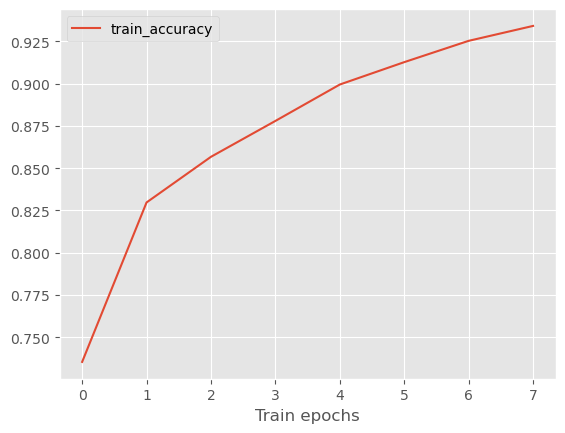

In [43]:
# Train model with output of "study.best_params()", i.e., {'units_layer': 33, 
# 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.08261852614103242, 'num_epochs': 8}

# best_params = {'units_layer': 33, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.08261852614103242, 'num_epochs': 8}

# F1 score compute modification
def train_and_evaluate_on_optimal_params(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5):


  # Build the model
  model = build_model(n_classes=1,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)
    
  # X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

  # Use the full dataset after smoting the validation dataset
  X_DL_train_optimal = pd.concat([X_res, X_val_smote])
  Y_DL_train_optimal = pd.concat([y_res, y_val_smote])

  print("X_DL_train_optimal.shape = ", X_DL_train_optimal.shape)
  print("Y_DL_train_optimal.shape = ", Y_DL_train_optimal.shape)

  # Train the model
  print('Training model ...')
  history = model.fit(
    x=X_DL_train_optimal,
    y=Y_DL_train_optimal,
    epochs=num_epochs,
    batch_size=64,
    # validation_split=0.1,
    verbose=0)

  # Compute the parameter count
  total_params = model.count_params()
    
  # Retrieve the training metrics after each train epoch
  train__optimal_accuracy = history.history['accuracy']
  plt.plot(train__optimal_accuracy, label='train_accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  return model



test_run_model = train_and_evaluate_on_optimal_params(hidden_layer_sizes=[best_params['units_layer']],
                       activation=best_params['activation'],
                       optimizer=best_params['optimizer'],
                       learning_rate=best_params['learning_rate'],
                       num_epochs=best_params['num_epochs'])


In [50]:
    
def test_holdout_set(test_run_model):

  # **** Predictions for the ACTUAL HOLDOUT (TEST) set *****
  test_predictions = test_run_model.predict(X_test)
  # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
  test_predicted_labels = (test_predictions > 0.5).astype(int)

  # Calculate confusion matrix
  cm = confusion_matrix(y_test, test_predicted_labels)
  tn, fp, fn, tp = cm.ravel()
  
  test_f1_score = f1_score(y_test, test_predicted_labels, average='macro')
  test_precision = precision_score(y_test, test_predicted_labels, average='macro')
  test_recall = recall_score(y_test, test_predicted_labels, average='macro')
  test_accuracy = accuracy_score(y_test, test_predicted_labels)

  # Plot the confusion matrix
  plot_confusion_matrix(cm, title='Test Confusion Matrix')
  
  print()
  print("Test data F1_SCORE = ", test_f1_score)
  print("Test data PRECISION = ", test_precision)
  print("Test data RECALL = ", test_recall)
  print("Test data ACCURACY = ", test_accuracy)
    
  print(classification_report(y_test, test_predicted_labels))


4/4 [==============================] - 0s 1ms/step
[[93  5]
 [ 3  2]]


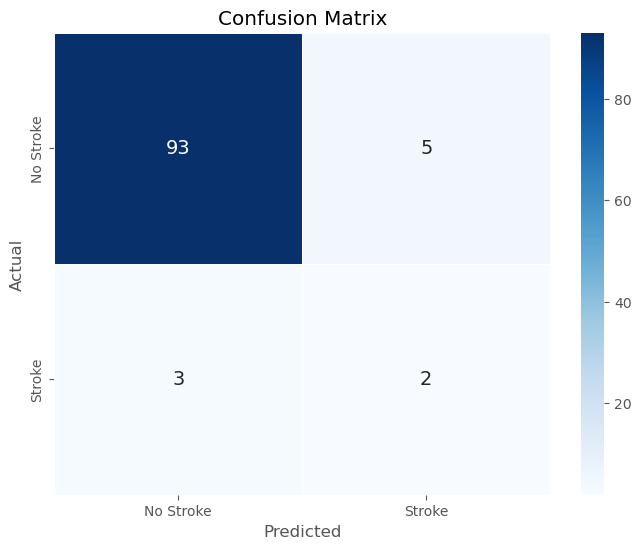


Test data F1_SCORE =  0.6460481099656358
Test data PRECISION =  0.6272321428571428
Test data RECALL =  0.6744897959183673
Test data ACCURACY =  0.9223300970873787
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        98
           1       0.29      0.40      0.33         5

    accuracy                           0.92       103
   macro avg       0.63      0.67      0.65       103
weighted avg       0.94      0.92      0.93       103



In [51]:
test_holdout_set(test_run_model)